In [2]:
import glob
import math
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import torch
from torch.optim import Adam, SGD
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import (
    CacheDataset,
    DataLoader,
    ThreadDataLoader,
    Dataset,
    decollate_batch,
    set_track_meta,
)
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.layers import Act, Norm
from monai.networks.nets import UNet, SwinUNETR, AHNet, VNet

from monai.transforms import (
    EnsureChannelFirstd,
    AsDiscrete,
    Compose,
    CropForegroundd,
    EnsureTyped,
    FgBgToIndicesd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
)
from monai.utils import set_determinism


from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2,3"  # Use the 3rd and 4th GPU. Indexing starts from 0.

# for profiling
import nvtx
from monai.utils.nvtx import Range
import contextlib  # to improve code readability (combining training/validation loop with and without profiling)

#print_config()
set_determinism(0)

2023-10-05 03:08:13.237705: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
In the future `np.object` will be defined as the corresponding NumPy scalar.
In the future `np.object` will be defined as the corresponding NumPy scalar.


In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")

current_directory = os.getcwd()

out_dir = os.path.join(current_directory,"outputs/")

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

root dir is: /tmp/tmpdxl8hrmw


In [4]:
import os
import sys
import gc
import ast
import cv2
import time
import timm
import pickle
import random
import pydicom
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
import nibabel as nib
from PIL import Image
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from sklearn.model_selection import KFold, StratifiedKFold
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, Optional, List
import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F


from timm.layers.conv2d_same import Conv2dSame

def convert_3d(module):

    module_output = module
    if isinstance(module, torch.nn.BatchNorm2d):
        module_output = torch.nn.BatchNorm3d(
            module.num_features,
            module.eps,
            module.momentum,
            module.affine,
            module.track_running_stats,
        )
        if module.affine:
            with torch.no_grad():
                module_output.weight = module.weight
                module_output.bias = module.bias
        module_output.running_mean = module.running_mean
        module_output.running_var = module.running_var
        module_output.num_batches_tracked = module.num_batches_tracked
        if hasattr(module, "qconfig"):
            module_output.qconfig = module.qconfig
            
    elif isinstance(module, Conv2dSame):
        module_output = Conv3dSame(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.Conv2d):
        module_output = torch.nn.Conv3d(
            in_channels=module.in_channels,
            out_channels=module.out_channels,
            kernel_size=module.kernel_size[0],
            stride=module.stride[0],
            padding=module.padding[0],
            dilation=module.dilation[0],
            groups=module.groups,
            bias=module.bias is not None,
            padding_mode=module.padding_mode
        )
        module_output.weight = torch.nn.Parameter(module.weight.unsqueeze(-1).repeat(1,1,1,1,module.kernel_size[0]))

    elif isinstance(module, torch.nn.MaxPool2d):
        module_output = torch.nn.MaxPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            dilation=module.dilation,
            ceil_mode=module.ceil_mode,
        )
    elif isinstance(module, torch.nn.AvgPool2d):
        module_output = torch.nn.AvgPool3d(
            kernel_size=module.kernel_size,
            stride=module.stride,
            padding=module.padding,
            ceil_mode=module.ceil_mode,
        )

    for name, child in module.named_children():
        module_output.add_module(
            name, convert_3d(child)
        )
    del module

    return module_output

# Calculate symmetric padding for a convolution
def get_padding(kernel_size: int, stride: int = 1, dilation: int = 1, **_) -> int:
    padding = ((stride - 1) + dilation * (kernel_size - 1)) // 2
    return padding


# Calculate asymmetric TensorFlow-like 'SAME' padding for a convolution
def get_same_padding(x: int, k: int, s: int, d: int):
    return max((math.ceil(x / s) - 1) * s + (k - 1) * d + 1 - x, 0)


# Can SAME padding for given args be done statically?
def is_static_pad(kernel_size: int, stride: int = 1, dilation: int = 1, **_):
    return stride == 1 and (dilation * (kernel_size - 1)) % 2 == 0


# Dynamically pad input x with 'SAME' padding for conv with specified args
def pad_same(x, k: List[int], s: List[int], d: List[int] = (1, 1, 1), value: float = 0):
    ih, iw, iz = x.size()[-3:]
    pad_h = get_same_padding(ih, k[0], s[0], d[0])
    pad_w = get_same_padding(iw, k[1], s[1], d[1])
    pad_z = get_same_padding(iz, k[2], s[2], d[2])
    if pad_h > 0 or pad_w > 0 or pad_z > 0:
        x = F.pad(x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2, pad_z // 2, pad_z - pad_z // 2], value=value)
    return x


def get_padding_value(padding, kernel_size, **kwargs) -> Tuple[Tuple, bool]:
    dynamic = False
    if isinstance(padding, str):
        # for any string padding, the padding will be calculated for you, one of three ways
        padding = padding.lower()
        if padding == 'same':
            # TF compatible 'SAME' padding, has a performance and GPU memory allocation impact
            if is_static_pad(kernel_size, **kwargs):
                # static case, no extra overhead
                padding = get_padding(kernel_size, **kwargs)
            else:
                # dynamic 'SAME' padding, has runtime/GPU memory overhead
                padding = 0
                dynamic = True
        elif padding == 'valid':
            # 'VALID' padding, same as padding=0
            padding = 0
        else:
            # Default to PyTorch style 'same'-ish symmetric padding
            padding = get_padding(kernel_size, **kwargs)
    return padding, dynamic


def conv3d_same(
        x, weight: torch.Tensor, bias: Optional[torch.Tensor] = None, stride: Tuple[int, int, int] = (1, 1, 1),
        padding: Tuple[int, int, int] = (0, 0, 0), dilation: Tuple[int, int, int] = (1, 1, 1), groups: int = 1):
    x = pad_same(x, weight.shape[-3:], stride, dilation)
    return F.conv3d(x, weight, bias, stride, (0, 0, 0), dilation, groups)


class Conv3dSame(nn.Conv3d):
    """ Tensorflow like 'SAME' convolution wrapper for 3d convolutions
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(Conv3dSame, self).__init__(
            in_channels, out_channels, kernel_size, stride, 0, dilation, groups, bias)

    def forward(self, x):
        return conv3d_same(x, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


def create_conv3d_pad(in_chs, out_chs, kernel_size, **kwargs):
    padding = kwargs.pop('padding', '')
    kwargs.setdefault('bias', False)
    padding, is_dynamic = get_padding_value(padding, kernel_size, **kwargs)
    if is_dynamic:
        return Conv3dSame(in_chs, out_chs, kernel_size, **kwargs)
    else:
        return nn.Conv3d(in_chs, out_chs, kernel_size, padding=padding, **kwargs)

kernel_type = 'timm3d_res18d_unet4b_128_128_128_dsv2_flip12_shift333p7_gd1p5_bs4_lr3e4_20x50ep'
load_kernel = None
load_last = True
n_blocks = 4
n_folds = 5
backbone = 'resnet18d'

init_lr = 3e-3
batch_size = 4
drop_rate = 0.
drop_path_rate = 0.
loss_weights = [1, 1]
p_mixup = 0.1
drop_rate = 0.
drop_path_rate = 0.
out_dim = 6
        
import torch
import torch.nn as nn
import timm
import segmentation_models_pytorch as smp

class TimmSegModel(nn.Module):
    def __init__(self, backbone, segtype='unet', pretrained=False, num_classes=6):
        super(TimmSegModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=3,
            features_only=True,
            drop_rate=0.1,
            drop_path_rate=0.1,
            pretrained=pretrained
        )

        # Modify the first layer of the encoder for 1-channel input
        self.encoder.conv1 = nn.Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)

        self.decoder = smp.Unet(
            encoder_name=backbone,
            encoder_depth=5,
            encoder_weights=None,  # Weights are already loaded in the encoder part
            decoder_use_batchnorm=True,
            decoder_channels=[256, 128, 64, 32, 16],
            decoder_attention_type='scse',
            in_channels=1,
            classes=num_classes,
            activation=None,  # Use 'None' because we handle activation in the loss function (e.g., CrossEntropy)
        )

    def forward(self, x):
        return self.decoder(x)

In [5]:
# Redefining the SEGMENTATION_CODES dictionary and mock data
SEGMENTATION_CODES = {
    #0: 'background',
    1: 'liver',
    2: 'spleen',
    3: 'kidney_left',
    4: 'kidney_right',
    5: 'bowel',
}

In [6]:
def process_and_get_bounding_boxes_v6(tensor):
    """
    Compute bounding boxes, determine the voxel count per depth, and the inner region for each organ.
    Also computes a bounding box that encompasses all organs based on the inner_slices.
    
    Args:
    - tensor (numpy.ndarray): The input tensor with shape (D, H, W).
    
    Returns:
    - dict: Bounding boxes, voxel counts per depth, and inner regions for each organ.
            Also includes the encompassing bounding box for all organs.
    """
    
    # Initialize bounding boxes dictionary
    bounding_boxes = {}
    
    # List to store all coordinates within the inner_slices for all organs
    all_coords_in_inner_slices = []
    
    for organ_label, organ_name in SEGMENTATION_CODES.items():
        if organ_label == 0:  # Skip background
            continue

        # Fourier-based smoothing logic based on organ_name
        fourier_factor = 0
        threshold_factor = 0
        if organ_name == 'liver':
            fourier_factor = 0.05
            threshold_factor = 0.2
        elif organ_name == 'spleen':
            fourier_factor = 0.05
            threshold_factor = 0.3
        elif organ_name == 'kidney_left':
            fourier_factor = 0.05
            threshold_factor = 0.3
        elif organ_name == 'kidney_right':
            fourier_factor = 0.05
            threshold_factor = 0.35
        elif organ_name == 'bowel':
            fourier_factor = 0.025
            threshold_factor = 0.2
        
        # Find the slices where the organ appears
        #print(tensor.shape)
        # Find the slices where the organ appears
        slices = np.where(np.any(tensor[0] == organ_label, axis=(1, 2)))[0]
        
        print(slices.shape)
        if len(slices) == 0:  # If organ does not appear, continue to next organ
            continue
        
        # Compute voxel count for each slice and store in a dictionary with slice index as key
        voxel_counts_per_depth = {slice_idx: np.sum(tensor[0, slice_idx] == organ_label) for slice_idx in slices}
        
        # Fourier-based smoothing and thresholding
        simple_list = list(voxel_counts_per_depth.values())
        smoothed_list = fourier_smoothing(simple_list, fourier_factor)
        
        # Thresholding logic
        max_value = np.max(smoothed_list)
        threshold = threshold_factor * max_value
        in_threshold = np.where(np.array(smoothed_list) >= threshold)[0].tolist()

        # Extract slice indices that are in the inner region
        #inner_slices = get_contiguous_inner_slices(in_threshold, slices)
        
        # Gather all coordinates for this organ that are within the inner_slices
        coords = np.argwhere((tensor[0] == organ_label) & np.isin(tensor[0], in_threshold))
        print(coords.shape)
        all_coords_in_inner_slices.extend(coords)
        
        # Bounding box computation for this organ
        min_coords = coords.min(axis=0)
        max_coords = coords.max(axis=0)
        
        bounding_boxes[organ_name] = {
            "top_left_front": tuple(min_coords),
            "bottom_right_back": tuple(max_coords),
            "depth_range": (min_coords[0], max_coords[0]),
            "voxel_counts_per_depth": voxel_counts_per_depth,
            "inner_slices": inner_slices
        }
    
    # Compute the encompassing bounding box for all organs based on inner_slices
    print(all_coords_in_inner_slices.shape)
    
    all_coords_array = np.array(all_coords_in_inner_slices)
    min_encompassing_coords = all_coords_array.min(axis=0)
    max_encompassing_coords = all_coords_array.max(axis=0)
    bounding_boxes["encompassing"] = {
        "top_left_front": tuple(min_encompassing_coords),
        "bottom_right_back": tuple(max_encompassing_coords),
        "depth_range": (min_encompassing_coords[0], max_encompassing_coords[0])
    }
        
    return bounding_boxes


def fourier_smoothing(y, cutoff_fraction=0.1):
    # Compute the FFT of the input data
    y_fft = np.fft.fft(y)
    
    # Zero out the higher frequencies
    cutoff_idx = int(cutoff_fraction * len(y_fft))
    y_fft[cutoff_idx:-cutoff_idx] = 0
    
    # Compute the inverse FFT to get the smoothed data
    y_smoothed = np.fft.ifft(y_fft).real  # Only take the real part
    
    return y_smoothed
    
def get_contiguous_inner_slices(in_threshold, slices):
    """
    Get contiguous blocks of slices that are above the threshold.
    
    Args:
    - in_threshold (list): A boolean list indicating if the slice is above the threshold.
    - slices (list): List of slice indices.
    
    Returns:
    - list: Contiguous inner slices.
    """
    inner_slices = []
    start_slice = None

    for i, val in enumerate(in_threshold):
        if val:
            if start_slice is None:  # Start of a new block
                start_slice = slices[i]
        else:
            if start_slice is not None:  # End of the current block
                inner_slices.extend(range(start_slice, slices[i]))
                start_slice = None

    if start_slice is not None:  # For the case where the last block reaches the end
        inner_slices.extend(range(start_slice, slices[-1] + 1))

    return inner_slices

# Function to save numpy array as .nii.gz
def save_nii(data, filename):
    img = nib.Nifti1Image(data, affine=np.eye(4))
    nib.save(img, filename)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


def squash(inputs, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param inputs: vectors to be squashed
    :param axis: the axis to squash
    :return: a Tensor with same size as inputs
    """
    norm = torch.norm(inputs, p=2, dim=axis, keepdim=True)
    scale = norm**2 / (1 + norm**2) / (norm + 1e-8)
    return scale * inputs


class DenseCapsule(nn.Module):
    """
    The dense capsule layer. It is similar to Dense (FC) layer. Dense layer has `in_num` inputs, each is a scalar, the
    output of the neuron from the former layer, and it has `out_num` output neurons. DenseCapsule just expands the
    output of the neuron from scalar to vector. So its input size = [None, in_num_caps, in_dim_caps] and output size = \
    [None, out_num_caps, out_dim_caps]. For Dense Layer, in_dim_caps = out_dim_caps = 1.

    :param in_num_caps: number of cpasules inputted to this layer
    :param in_dim_caps: dimension of input capsules
    :param out_num_caps: number of capsules outputted from this layer
    :param out_dim_caps: dimension of output capsules
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, in_num_caps, in_dim_caps, out_num_caps, out_dim_caps, routings=3):
        super(DenseCapsule, self).__init__()
        self.in_num_caps = in_num_caps
        self.in_dim_caps = in_dim_caps
        self.out_num_caps = out_num_caps
        self.out_dim_caps = out_dim_caps
        self.routings = routings
        self.weight = nn.Parameter(0.01 * torch.randn(out_num_caps, in_num_caps, out_dim_caps, in_dim_caps))

    def forward(self, x):
        # x.size=[batch, in_num_caps, in_dim_caps]
        # expanded to    [batch, 1,            in_num_caps, in_dim_caps,  1]
        # weight.size   =[       out_num_caps, in_num_caps, out_dim_caps, in_dim_caps]
        # torch.matmul: [out_dim_caps, in_dim_caps] x [in_dim_caps, 1] -> [out_dim_caps, 1]
        # => x_hat.size =[batch, out_num_caps, in_num_caps, out_dim_caps]
        x_hat = torch.squeeze(torch.matmul(self.weight, x[:, None, :, :, None]), dim=-1)

        # In forward pass, `x_hat_detached` = `x_hat`;
        # In backward, no gradient can flow from `x_hat_detached` back to `x_hat`.
        x_hat_detached = x_hat.detach()

        # The prior for coupling coefficient, initialized as zeros.
        # b.size = [batch, out_num_caps, in_num_caps]
        #b = Variable(torch.zeros(x.size(0), self.out_num_caps, self.in_num_caps)).cuda()
        b = Variable(torch.zeros(x.size(0), self.out_num_caps, self.in_num_caps)).to(x.device)

        assert self.routings > 0, 'The \'routings\' should be > 0.'
        for i in range(self.routings):
            # c.size = [batch, out_num_caps, in_num_caps]
            c = F.softmax(b, dim=1)

            # At last iteration, use `x_hat` to compute `outputs` in order to backpropagate gradient
            if i == self.routings - 1:
                # c.size expanded to [batch, out_num_caps, in_num_caps, 1           ]
                # x_hat.size     =   [batch, out_num_caps, in_num_caps, out_dim_caps]
                # => outputs.size=   [batch, out_num_caps, 1,           out_dim_caps]
                outputs = squash(torch.sum(c[:, :, :, None] * x_hat, dim=-2, keepdim=True))
                # outputs = squash(torch.matmul(c[:, :, None, :], x_hat))  # alternative way
            else:  # Otherwise, use `x_hat_detached` to update `b`. No gradients flow on this path.
                outputs = squash(torch.sum(c[:, :, :, None] * x_hat_detached, dim=-2, keepdim=True))
                # outputs = squash(torch.matmul(c[:, :, None, :], x_hat_detached))  # alternative way

                # outputs.size       =[batch, out_num_caps, 1,           out_dim_caps]
                # x_hat_detached.size=[batch, out_num_caps, in_num_caps, out_dim_caps]
                # => b.size          =[batch, out_num_caps, in_num_caps]
                b = b + torch.sum(outputs * x_hat_detached, dim=-1)

        return torch.squeeze(outputs, dim=-2)

class PrimaryCapsule(nn.Module):
    """
    Apply Conv2D with `out_channels` and then reshape to get capsules
    :param in_channels: input channels
    :param out_channels: output channels
    :param dim_caps: dimension of capsule
    :param kernel_size: kernel size
    :return: output tensor, size=[batch, num_caps, dim_caps]
    """
    def __init__(self, in_channels, out_channels, dim_caps, kernel_size, stride=1, padding=0):
        super(PrimaryCapsule, self).__init__()
        self.dim_caps = dim_caps
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        outputs = self.conv2d(x)
        outputs = outputs.view(x.size(0), -1, self.dim_caps)
        return squash(outputs)

In [39]:
def extract_encompassing_subregion(volume, bounding_boxes):
    # Extract the coordinates from the 'encompassing' bounding box
    top_left_front = bounding_boxes["encompassing"]["top_left_front"]
    bottom_right_back = bounding_boxes["encompassing"]["bottom_right_back"]

    # Use the coordinates to slice into the volume tensor
    subregion = volume[top_left_front[0]:bottom_right_back[0]+1, 
                       top_left_front[1]:bottom_right_back[1]+1, 
                       top_left_front[2]:bottom_right_back[2]+1]

    return subregion
    
def extract_organ_subregion(volume, bounding_boxes, organ_name):
    # Ensure the provided organ_name exists in the bounding_boxes
    if organ_name not in bounding_boxes:
        raise ValueError(f"No bounding box found for organ: {organ_name}")
    
    # Extract the coordinates from the specified organ's bounding box
    top_left_front = bounding_boxes[organ_name]["top_left_front"]
    bottom_right_back = bounding_boxes[organ_name]["bottom_right_back"]

    # Use the coordinates to slice into the volume tensor
    subregion = volume[top_left_front[0]:bottom_right_back[0]+1, 
                       top_left_front[1]:bottom_right_back[1]+1, 
                       top_left_front[2]:bottom_right_back[2]+1]

    return subregion

def preprocess_and_extract_torch(volume, model, device, resize_to=(100, 224, 224), use_three_channel=True, overlap=True):
    """
    Given a 3D volume, this function will preprocess each slice and extract features using the provided model.
    ...
    """

    # Check for CUDA availability and set the device accordingly
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Convert ndarray to tensor and normalize to [0, 1] range
    if isinstance(volume, np.ndarray):
        volume = torch.from_numpy(volume.astype(np.float32)).to(device)
        min_val = torch.min(volume)
        max_val = torch.max(volume)
        volume = (volume - min_val) / (max_val - min_val)

    # Normalization parameters
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1)

    # Resize the slices
    #volume = torch.nn.functional.interpolate(volume, size=resize_to, mode='trilinear', align_corners=True)
    volume = torch.nn.functional.interpolate(volume.unsqueeze(0).unsqueeze(0), size=resize_to, mode='trilinear', align_corners=True).squeeze(0).squeeze(0)

    # Define the step based on whether overlap is desired
    step = 1 if overlap else 3

    # Iterate through the volume
    depth = volume.shape[0]
    features_list = []

    for idx in tqdm(range(1, depth-1, step)):  # Avoiding starting at index 0 and ending at index -1
        if use_three_channel:
            # Create 3-channel image
            slices = volume[max(idx-1, 0):min(idx+2, depth), :, :]
            # Normalize the 3-channel image
            normalized_image = (slices - mean) / std
            normalized_image = normalized_image.unsqueeze(0)  # Add batch dimension
            
            # Extract features and append to the list
            with torch.no_grad():
                features = model(normalized_image)

            #features = features.detach().cpu().numpy()
            features = [f.detach().cpu().numpy() for f in features]

            features_list.append(features)

            del normalized_image
            
    # Delete any unnecessary data to free up CUDA memory
    del mean, std, volume
    # Free up CUDA memory
    torch.cuda.empty_cache()

    return features_list


In [2]:
import os
import pandas as pd
from tqdm import tqdm

# # Get the current working directory
# current_directory = os.getcwd()

# # Construct the path to the train_images directory located one level up
# train_base_directory = os.path.join(current_directory, 'train_images')

# # Collect all the DICOM file paths along with patient IDs and series ID
# dicom_data = []
# for patient_id in tqdm(os.listdir(train_base_directory), desc="Processing Patients"):
#     patient_dir = os.path.join(train_base_directory, patient_id)
#     for series_id in os.listdir(patient_dir):
#         series_dir = os.path.join(patient_dir, series_id)
#         dicom_data.append({'series_dir': series_dir, 'patient_id': patient_id, 'series_id': series_id})

# # Create a DataFrame using the collected data
# dicom_df = pd.DataFrame(dicom_data)

# dicom_df['patient_duplicate_count'] = dicom_df.groupby('patient_id')['patient_id'].transform('count')
# Get the current working directory
current_directory = os.getcwd()

# Construct the path to the train_images directory located one level up
train_base_directory = os.path.join(current_directory, 'train_images')

# Collect all the DICOM file paths along with patient IDs and series ID
dicom_data = []
for patient_id in tqdm(os.listdir(train_base_directory), desc="Processing Patients"):
    patient_dir = os.path.join(train_base_directory, patient_id)
    for series_id in os.listdir(patient_dir):
        series_dir = os.path.join(patient_dir, series_id)

        # Check if the series directory is empty
        if not os.listdir(series_dir):
            print(f"{series_dir} is empty. Skipping...")
            continue

        # Check if all files in the series directory are DICOM files
        all_files_are_dicom = all([f.endswith('.dcm') for f in os.listdir(series_dir)])
        if not all_files_are_dicom:
            print(f"Non-DICOM files found in {series_dir}. Skipping...")
            continue

        dicom_data.append({'series_dir': series_dir, 'patient_id': patient_id, 'series_id': series_id})

# Create a DataFrame using the collected data
dicom_df = pd.DataFrame(dicom_data)

dicom_df['patient_duplicate_count'] = dicom_df.groupby('patient_id')['patient_id'].transform('count')

# Transformation pipeline
# test_org_transforms = Compose(
#     [
#         LoadImaged(keys="image"),
#         EnsureChannelFirstd(keys="image"),
#         Orientationd(keys=["image"], axcodes="RAS"),
#         Spacingd(keys=["image"], pixdim=(2.0, 2.0, 2.0), mode="bilinear"),
#         ScaleIntensityRanged(
#             keys=["image"],
#             a_min=-57,
#             a_max=164,
#             b_min=0.0,
#             b_max=1.0,
#             clip=True,
#         ),
#     ]
# )

Processing Patients: 100%|███████████████████████████████████████████████████████████████████████████| 3147/3147 [00:01<00:00, 2531.89it/s]


In [4]:
import psutil
# Get the virtual memory status
memory_info = psutil.virtual_memory()

# Print the free memory in bytes
print(f"Free RAM: {memory_info.free} bytes")

# If you want the free RAM in GB
print(f"Free RAM: {memory_info.free / (1024 ** 3)} GB")


Free RAM: 5996920832 bytes
Free RAM: 5.5850677490234375 GB


In [11]:
!free -h

              total        used        free      shared  buff/cache   available
Mem:           125G          9G         44G        159M         71G        114G
Swap:          4.0G        687M        3.3G


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

class CombinedFeatureExtractor(nn.Module):
    def __init__(self, input_channels=1, pretrained=True, unet_feature_dim=1024, capsnet_feature_dim=1024):
        super(CombinedFeatureExtractor, self).__init__()

        # Use pre-trained ResNet as encoder but modify for desired input channels
        resnet = models.resnet18(pretrained=pretrained)
        resnet.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])  # Remove the classification head

        # Decoder (U-Net style)
        self.decoder_block1 = self.conv_block(512, 256)
        self.decoder_block2 = self.conv_block(256, 128)
        self.decoder_block3 = self.conv_block(128, 64)
        
        with torch.no_grad():
            x = torch.randn(1, input_channels, 256, 256)
            x = self.encoder(x)
            x = self.decoder_block1(F.interpolate(x, scale_factor=2))
            x = self.decoder_block2(F.interpolate(x, scale_factor=2))
            x = self.decoder_block3(F.interpolate(x, scale_factor=2))
        
        # Calculate the number of features and initialize the fully connected layer
        num_features = x.shape[1] * x.shape[2] * x.shape[3]
        # Calculate the number of features for U-Net and initialize the fully connected layer
        self.fc_unet = nn.Linear(num_features, unet_feature_dim)  # Assuming 256x256 input size
        
        # CapsNet Layer
        self.primary_capsules = PrimaryCapsule(in_channels=512, out_channels=256, dim_caps=8, kernel_size=1)

        self.digit_capsules = DenseCapsule(in_num_caps=2048, 
                                           in_dim_caps=self.primary_capsules.dim_caps,
                                           out_num_caps=capsnet_feature_dim // 8,  # Adjust the number of capsules based on desired feature dimension
                                           out_dim_caps=8, 
                                           routings=3)
        
        self.fc_caps = nn.Linear(capsnet_feature_dim, capsnet_feature_dim)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder (pre-trained CNN)
        encoded_x = self.encoder(x)

        # Decoder (U-Net)
        unet_features = self.decoder_block1(F.interpolate(encoded_x, scale_factor=2))
        unet_features = self.decoder_block2(F.interpolate(unet_features, scale_factor=2))
        unet_features = self.decoder_block3(F.interpolate(unet_features, scale_factor=2))
        
        # Flatten and pass through the fully connected layer for 1D feature vector
        unet_features = unet_features.view(unet_features.size(0), -1)
        unet_features = self.fc_unet(unet_features)
 
        x_reshaped = encoded_x.view(encoded_x.size(0), 512, 1, 1)
        x_reshaped = F.interpolate(x_reshaped, size=(8, 8), mode='nearest')  # Upsample to [batch_size, 512, 7, 7]

        caps_features = self.primary_capsules(x_reshaped)

        caps_features = self.digit_capsules(caps_features)
        caps_features = self.fc_caps(caps_features.view(caps_features.size(0), -1))

        # Combine the features from U-Net and CapsNet
        combined_features = torch.cat([unet_features, caps_features], dim=1)

        return unet_features, caps_features


In [13]:
import os
import pydicom as dicom
import numpy as np
from skimage.transform import resize
from scipy.ndimage import zoom
from numba import jit

@jit(nopython=True)
def adjust_pixel_values(pixel_array, slope, intercept, center, width):
    pixel_array = (pixel_array * slope) + intercept
    low = center - width / 2
    high = center + width / 2
    pixel_array = np.clip(pixel_array, low, high)
    pixel_array -= np.min(pixel_array)
    pixel_array = (pixel_array / np.max(pixel_array) * 255).astype(np.int16)
    return pixel_array


def sample_patient_volume(folder, depth_downsample_rate=None, lw_downsample_rate=None, 
                          adjust_pixel_spacing="no", standardize_pixel_array="yes", 
                          target_pixel_spacing=[1.0, 1.0], target_thickness=None):
    """
    Load and optionally adjust and standardize the pixel array from DICOM metadata.
    """
    
    filenames = sorted([int(filename.split('.')[0]) for filename in os.listdir(folder)])
    filenames = [str(filename) + '.dcm' for filename in filenames]
    
    volume = []
    original_thicknesses = []
    for filename in filenames:
        filepath = os.path.join(folder, filename)
        dcm = dicom.dcmread(filepath)
        original_thicknesses.append(float(dcm.SliceThickness))
        
        pixel_array = dcm.pixel_array

        # Adjust pixel spacing if required
        if standardize_pixel_array.lower() == "yes":
            if dcm.PixelRepresentation == 1:
                bit_shift = dcm.BitsAllocated - dcm.BitsStored
                dtype = pixel_array.dtype 
                pixel_array = (pixel_array << bit_shift).astype(dtype) >> bit_shift

            intercept = float(dcm.RescaleIntercept)
            slope = float(dcm.RescaleSlope)
            center = int(dcm.WindowCenter)
            width = int(dcm.WindowWidth)
            pixel_array = adjust_pixel_values(pixel_array, slope, intercept, center, width)
            
        if adjust_pixel_spacing.lower() == "yes":
            row_spacing, col_spacing = dcm.PixelSpacing
            new_shape = (int(pixel_array.shape[0] * (row_spacing/target_pixel_spacing[0])), 
                         int(pixel_array.shape[1] * (col_spacing/target_pixel_spacing[1])))
            pixel_array = resize(pixel_array, new_shape)

        if lw_downsample_rate:
            pixel_array = pixel_array[::lw_downsample_rate, ::lw_downsample_rate]

        volume.append(pixel_array)
        
    volume = np.array(volume)
    print(volume.shape)
    # Adjust the slice thickness if needed
    if target_thickness is not None:
        original_thickness = np.mean(original_thicknesses)
        z_zoom_factor = original_thickness / target_thickness
        volume = zoom(volume, (z_zoom_factor, 1, 1), order=1)  # order=1 for bilinear interpolation
        
    return volume

In [31]:
train_info

patient_id  bowel_healthy  bowel_injury  extravasation_healthy  \
0         10004              1             0                      0   
1         10005              1             0                      1   
2         10007              1             0                      1   
3         10026              1             0                      1   
4         10051              1             0                      1   
...         ...            ...           ...                    ...   
3142       9951              1             0                      1   
3143       9960              1             0                      1   
3144       9961              1             0                      1   
3145       9980              1             0                      1   
3146       9983              1             0                      1   

      extravasation_injury  kidney_healthy  kidney_low  kidney_high  \
0                        1               0           1            0   
1                        0               1           0            0   
2                        0               1           0            0   
3                        0               1           0            0   
4                        0               1           0            0   
...                    ...             ...         ...          ...   
3142                     0               1           0            0   
3143                     0               1           0            0   
3144                     0               1           0            0   
3145                     0               1           0            0   
3146                     0               1           0            0   

      liver_healthy  liver_low  liver_high  spleen_healthy  spleen_low  \
0                 1          0           0               0           0   
1                 1          0           0               1           0   
2                 1          0           0               1           0   
3                 1          0           0               1           0   
4                 1          0           0               0           1   
...             ...        ...         ...             ...         ...   
3142              1          0           0               1           0   
3143              1          0           0               1           0   
3144              1          0           0               1           0   
3145              1          0           0               0           0   
3146              1          0           0               0           0   

      spleen_high  any_injury  
0               1           1  
1               0           0  
2               0           0  
3               0           0  
4               0           1  
...           ...         ...  
3142            0           0  
3143            0           0  
3144            0           0  
3145            1           1  
3146            1           1  

[3147 rows x 15 columns]

In [5]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load data
train_info = pd.read_csv('train.csv')
train_info.patient_id = train_info.patient_id.astype(str)

curr_df = dicom_df#dicom_df[dicom_df.patient_duplicate_count == 2]
train_info = train_info[train_info.patient_id.isin(curr_df.patient_id)]
#train_info = train_info[train_info.extravasation_injury == 1]
curr_df = curr_df[curr_df.patient_id.isin(train_info.patient_id)]

unique_patients = np.unique(curr_df.patient_id)

# Directory where the .nii.gz files are saved
vol_directory = "/workspace/0728tot/ATD/patient_nii"


# seg_model_device = torch.device("cuda:0")
# feature_extractor_device = torch.device("cuda:1")

# # Create the model
# seg_model = TimmSegModel(backbone = 'resnet18', segtype='unet', pretrained = True)
# seg_model = convert_3d(seg_model)
# # Test the model (just to ensure everything is working)
# seg_model = seg_model.to(seg_model_device)

# seg_model.load_state_dict(torch.load(os.path.join(current_directory, "resnet18_unet_best_metric_model.pt")))
# seg_model.eval()


# feature_extractor = CombinedFeatureExtractor(input_channels = 3, pretrained=True, unet_feature_dim=1024, capsnet_feature_dim=1024)
# feature_extractor = feature_extractor.to(feature_extractor_device)
# feature_extractor.eval()

In [6]:
# Load data
train_info = pd.read_csv('train.csv')
train_info.patient_id = train_info.patient_id.astype(str)

curr_df = dicom_df#dicom_df[dicom_df.patient_duplicate_count == 2]
train_info = train_info[train_info.patient_id.isin(curr_df.patient_id)]
#train_info = train_info[train_info.extravasation_injury == 1]
curr_df = curr_df[curr_df.patient_id.isin(train_info.patient_id)]

unique_patients = np.unique(curr_df.patient_id)


In [33]:
dicom_df.to_csv('patient_series_mapping.csv')

In [25]:
df_g = train_info[train_info.patient_id.isin(np.array(curr_df.iloc[4579:]['patient_id']))]

In [26]:
np.array(curr_df.iloc[4579:]['patient_id'])

array(['58480', '31985', '14429', '18053', '18653', '61229', '36414',
       '42602', '1758', '1758', '10005', '47709', '47709', '9553', '9553',
       '44769', '2675', '2675', '37551', '51476', '59704', '59704',
       '36356', '36356', '37520', '25840', '49598', '49598', '25922',
       '25922', '43201', '43201', '32072', '42422', '44507', '403', '403',
       '40800', '37436', '37436', '58316', '16310', '16310', '61987',
       '61987', '706', '706', '10697', '10697', '26628', '26628', '44991',
       '44991', '8889', '8889', '64019', '64019', '58834', '58077',
       '58077', '15151', '43947', '43947', '64982', '64982', '36738',
       '36738', '62513', '62513', '33029', '33029', '5584', '5584',
       '40269', '18775', '65005', '42319', '42319', '34386', '27648',
       '57574', '54596', '58773', '58773', '951', '951', '49479', '49479',
       '49773', '44499', '44499', '43786', '50916', '50916', '61499',
       '38059', '38059', '40792', '7026', '7026', '7642', '11829',
       '5

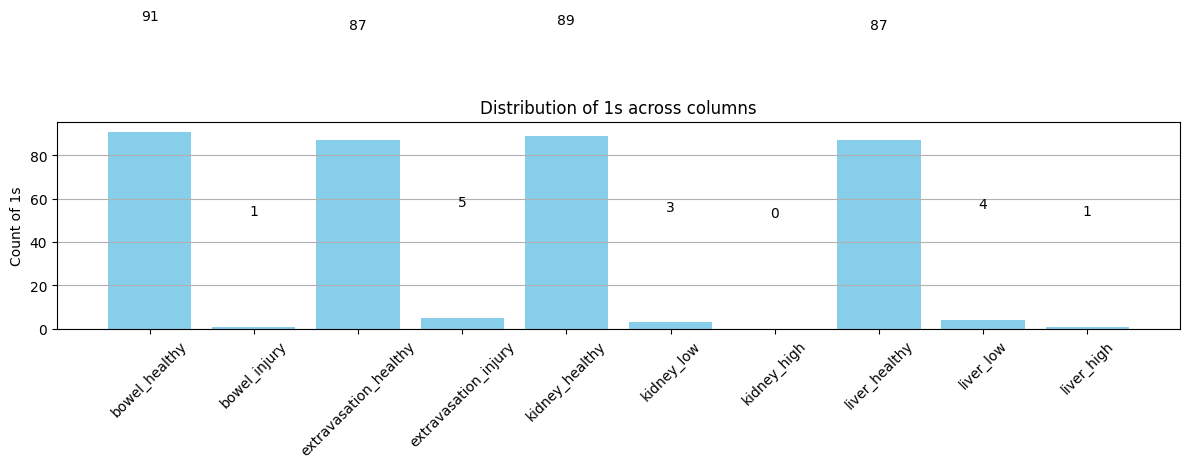

In [28]:
import matplotlib.pyplot as plt

def plot_distribution_of_ones(df, columns):
    """
    Plots the distribution of 1s for each specified column in the dataframe.

    Args:
    - df (pd.DataFrame): The input dataframe.
    - columns (list of str): List of column names to be plotted.
    """
    
    # Count the number of 1s in each column
    ones_count = df[columns].sum()
    
    # Plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(ones_count.index, ones_count.values, color='skyblue')
    
    # Add annotations to bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 50, round(yval, 2), ha='center', va='bottom')
    
    plt.ylabel('Count of 1s')
    plt.title('Distribution of 1s across columns')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

# List of columns to be plotted
columns = [
    'bowel_healthy', 'bowel_injury', 'extravasation_healthy',
    'extravasation_injury', 'kidney_healthy', 'kidney_low',
    'kidney_high', 'liver_healthy', 'liver_low', 'liver_high'
]

# Assuming df is your dataframe
plot_distribution_of_ones(df_g, columns)


In [29]:
# List of injury-related columns
injury_columns = [
    'bowel_injury', 'extravasation_injury',
    'kidney_low', 'kidney_high', 'liver_low', 'liver_high'
]

# Filter the dataframe to get rows with a 1 in any of the injury columns
injury_df = df_g[df_g[injury_columns].sum(axis=1) > 0]


In [1]:
import os
import pandas as pd
import numpy as np
# Define the base directory path
base_dir = 'entire_volume_features'

# Create lists to hold the extracted data
series_ids = []
file_paths = []
file_names = []
organ_names = []

# Expected organs
expected_organs = ["liver", "encompassing", "kidney_left", "kidney_right", "bowel", "spleen"]

# Iterate over each folder (series) in the base directory
for series_folder in os.listdir(base_dir):
    series_folder_path = os.path.join(base_dir, series_folder)
    
    # Check if it's a directory (series folder)
    if os.path.isdir(series_folder_path):
        present_organs = []
        
        # Iterate over the files (numpy files) inside the series folder
        for npy_file in os.listdir(series_folder_path):
            if npy_file.endswith('_features.npy'):
                num_underscores = npy_file.count('_')
                if num_underscores == 3:  # kidney_left or kidney_right
                    organ_name = "_".join(npy_file.split('_')[1:3])
                elif num_underscores == 2:  # all other organs
                    organ_name = npy_file.split('_')[1]
                else:
                    continue  # skip files that don't match the expected format
                
                present_organs.append(organ_name)
                file_path = os.path.join(series_folder_path, npy_file)

                # Append data to the lists
                series_ids.append(series_folder)
                file_paths.append(file_path)
                file_names.append(npy_file)
                organ_names.append(organ_name)

        # Check for missing organs and mark them as missing
        for organ in expected_organs:
            if organ not in present_organs:
                series_ids.append(series_folder)
                file_paths.append("-")
                file_names.append("-")
                organ_names.append(organ)


# Create a DataFrame from the extracted data
df = pd.DataFrame({'series_id': series_ids, 'file_path': file_paths, 'file_name': file_names, 'organ_name': organ_names})

# Read the patient_series_mapping CSV
mapping = pd.read_csv('patient_series_mapping.csv')
mapping = mapping.drop([mapping.columns[0],mapping.columns[1]], axis=1)
df['series_id'] = df['series_id'].astype(str)
mapping['series_id'] = mapping['series_id'].astype(str)

# Merge df with the mapping to get the patient_id for each series_id
df = pd.merge(df, mapping, on='series_id', how='left')

# # Read the train_info CSV
train_info = pd.read_csv('train.csv')

In [2]:
official_mapping = mapping[mapping['series_id'].isin(np.unique(df['series_id']))][['patient_id','series_id']]
official_mapping = official_mapping.reset_index(drop=True)
train_info = train_info[train_info['patient_id'].isin(official_mapping['patient_id'])]

In [3]:
# Merge the dataframes
merged_df = pd.merge(train_info, official_mapping, on='patient_id', how='left')

# Reorder the columns to have series_id next to patient_id
cols = merged_df.columns.tolist()
col_idx = cols.index('patient_id')
cols = cols[:col_idx] + ['series_id', 'patient_id'] + cols[col_idx+1:-1]
merged_df = merged_df[cols]

subset_df = df[df.eq('-').any(axis=1)]
bad_train_series_cases = subset_df[subset_df['organ_name'].isin(['bowel', 'liver'])]['series_id']
merged = merged_df[~merged_df['series_id'].isin(bad_train_series_cases)]
df = df[~df['series_id'].isin(bad_train_series_cases)]
merged = merged.drop(['bowel_injury','extravasation_injury','any_injury'],axis=1)

In [4]:
import numpy as np
import pandas as pd
from skmultilearn.model_selection import IterativeStratification

# Assuming df is your dataframe
labels = merged[['bowel_healthy', 'extravasation_healthy', 
             'kidney_healthy', 'kidney_low', 'kidney_high', 'liver_healthy', 'liver_low', 
             'liver_high', 'spleen_healthy', 'spleen_low', 'spleen_high']].values

n_splits = 5
stratifier = IterativeStratification(n_splits=n_splits, order=1)
train_indexes, test_indexes = [], []

for train_index, test_index in stratifier.split(merged, labels):
    train_indexes.append(train_index)
    test_indexes.append(test_index)

# # Access train and test using the indexes:
# for i in range(n_splits):
#     train_subset = df.iloc[train_indexes[i]]
#     test_subset = df.iloc[test_indexes[i]]
#     # Do your training and evaluation with train_subset and test_subset


In [5]:
df

series_id                                          file_path  \
0         17473  entire_volume_features/17473/17473_bowel_featu...   
1         17473  entire_volume_features/17473/17473_encompassin...   
2         17473  entire_volume_features/17473/17473_liver_featu...   
3         17473  entire_volume_features/17473/17473_kidney_left...   
4         17473  entire_volume_features/17473/17473_spleen_feat...   
...         ...                                                ...   
27475      5472  entire_volume_features/5472/5472_liver_feature...   
27476      5472  entire_volume_features/5472/5472_spleen_featur...   
27477      5472  entire_volume_features/5472/5472_bowel_feature...   
27478      5472  entire_volume_features/5472/5472_encompassing_...   
27479      5472  entire_volume_features/5472/5472_kidney_left_f...   

                             file_name    organ_name  patient_id  \
0             17473_bowel_features.npy         bowel        2482   
1      17473_encompassing_features.npy  encompassing        2482   
2             17473_liver_features.npy         liver        2482   
3       17473_kidney_left_features.npy   kidney_left        2482   
4            17473_spleen_features.npy        spleen        2482   
...                                ...           ...         ...   
27475          5472_liver_features.npy         liver       24984   
27476         5472_spleen_features.npy        spleen       24984   
27477          5472_bowel_features.npy         bowel       24984   
27478   5472_encompassing_features.npy  encompassing       24984   
27479    5472_kidney_left_features.npy   kidney_left       24984   

       patient_duplicate_count  
0                            2  
1                            2  
2                            2  
3                            2  
4                            2  
...                        ...  
27475                        2  
27476                        2  
27477                        2  
27478                        2  
27479                        2  

[27396 rows x 6 columns]

In [6]:
encompassing_df = df[df['organ_name']=='encompassing']

In [7]:
loaded_data = {}

for index, row in encompassing_df.iterrows():
    series_id = row['series_id']
    file_path = row['file_path']
    
    # Load the numpy file
    data = np.load(file_path)
    
    # Store it in the dictionary
    if series_id not in loaded_data:
        loaded_data[series_id] = [data]
    else:
        loaded_data[series_id].append(data)


In [91]:
from scipy.stats import skew, kurtosis

def mean_aggregation(features):
    return np.mean(features, axis=0)
def max_pooling_aggregation(features):
    return np.max(features, axis=0)
def min_pooling_aggregation(features):
    return np.min(features, axis=0)
def summation_aggregation(features):
    return np.sum(features, axis=0)
def compute_skewness(matrix):
    return skew(matrix, axis=0)
def compute_kurtosis(matrix):
    return kurtosis(matrix, axis=0)

def apply_low_pass_filter(noisy_signal, cutoff_frequency=0.1):
    # Obtain the Fourier Transform
    t = np.arange(len(noisy_signal))  # Assuming uniformly sampled signal
    frequencies = np.fft.fftfreq(len(t))
    fft_values = np.fft.fft(noisy_signal)

    # Apply a low-pass filter (retain only the low frequency components)
    filtered_fft_values = fft_values.copy()
    filtered_fft_values[np.abs(frequencies) > cutoff_frequency] = 0

    # Apply Inverse Fourier Transform to obtain the smoothed signal
    smoothed_signal = np.fft.ifft(filtered_fft_values).real  # Take the real part to ensure the result is real
    
    return smoothed_signal

In [64]:
loaded_data.keys()

dict_keys(['17473', '64331', '7246', '2797', '4964', '12474', '13781', '39625', '10981', '41330', '17227', '36813', '40255', '63418', '33395', '4127', '52469', '50659', '46845', '25542', '62596', '36139', '19581', '41309', '26153', '22004', '48405', '10730', '43956', '37127', '41416', '22402', '12221', '19919', '48184', '16534', '50397', '32735', '40900', '34831', '24508', '17217', '29262', '41875', '18935', '29964', '38794', '40313', '1845', '42217', '41530', '64992', '41245', '39530', '63036', '5223', '29869', '34841', '29104', '46685', '27601', '53006', '53843', '2003', '9877', '19927', '18971', '15854', '62654', '56073', '35095', '36584', '63028', '44841', '52692', '63010', '34371', '39192', '23049', '18437', '4789', '47675', '34388', '26627', '62953', '59729', '37142', '19196', '23511', '23935', '36313', '13342', '47672', '52421', '43659', '42486', '25458', '17861', '58679', '13590', '40382', '18096', '40068', '63928', '17320', '30630', '60750', '60075', '58431', '15853', '23767',

In [86]:
save = compute_features(loaded_data['181'][0].transpose(2, 1, 0, 3)[0][1])

In [87]:
save['energy']

[0.0008519443,
 0.00019321083,
 0.018147461,
 0.0065693334,
 0.126552,
 0.0018928838,
 0.01097773,
 0.00036610197,
 0.22828346,
 0.07651885,
 0.03002321,
 0.22117856,
 0.058348976,
 0.0063904934,
 0.09347297,
 0.15011135,
 0.18334585,
 0.20701778,
 0.00027040363,
 0.05937933,
 0.046486,
 0.2370295,
 0.043905243,
 0.11707129,
 0.07233842,
 0.0037895148,
 2.633637e-07,
 0.066995144,
 0.0064341445,
 0.072968826,
 0.12456074,
 0.118065804,
 0.09362174,
 0.13327917,
 0.00959602,
 0.13110754,
 0.19827181,
 0.23191819,
 0.20774047,
 0.23372336,
 0.20884687,
 0.09776302,
 0.016784381,
 0.011037282,
 0.0039046663,
 0.070875384,
 0.10175436,
 0.0026794702,
 0.07986818,
 0.027255798,
 0.0019312891,
 0.012421845,
 0.019468576,
 0.02174572,
 0.2079988,
 0.07418251,
 0.006048631,
 0.03089767,
 0.006579969,
 0.054118656,
 0.0996858,
 0.02863437,
 0.15707241,
 0.23875949,
 0.087901786,
 0.11669074,
 0.017401624,
 0.14048123,
 0.047435004,
 0.037188407,
 0.0073737996,
 0.07668488,
 0.20876923,
 0.02876

In [92]:
# Create a dictionary to store aggregated features for each series_id
aggregated_data = {}

# Iterate through each series_id and its corresponding data in loaded_data
for series_id, data_item in loaded_data.items():
    # Apply the aggregation functions
    local_item = data_item[0].transpose(2, 1, 0, 3)[0][0]
    unet_mean_features = apply_low_pass_filter(mean_aggregation(local_item),0.2)
    unet_max_features = apply_low_pass_filter(max_pooling_aggregation(local_item),0.2)
    unet_min_features = apply_low_pass_filter(min_pooling_aggregation(local_item),0.2)
    unet_sum_features = apply_low_pass_filter(summation_aggregation(local_item),0.2)
    unet_kurt_features = compute_kurtosis(local_item)
    unet_skew_features = compute_skewness(local_item)

    local_item = data_item[0].transpose(2, 1, 0, 3)[0][1]
    caps_mean_features = apply_low_pass_filter(mean_aggregation(local_item),0.2)
    caps_max_features = apply_low_pass_filter(max_pooling_aggregation(local_item),0.2)
    caps_min_features = apply_low_pass_filter(min_pooling_aggregation(local_item),0.2)
    caps_sum_features = apply_low_pass_filter(summation_aggregation(local_item),0.2)
    caps_kurt_features = compute_kurtosis(local_item)
    caps_skew_features = compute_skewness(local_item)

    # Store the aggregated features in the dictionary
    aggregated_data[series_id] = {
        'unet_mean': unet_mean_features,
        'unet_max': unet_max_features,
        'unet_min': unet_min_features,
        'unet_sum': unet_sum_features,
        'unet_kurt': unet_kurt_features,
        'unet_skew': unet_skew_features,
        
        'caps_mean': caps_mean_features,
        'caps_max': caps_max_features,
        'caps_min': caps_min_features,
        'caps_sum': caps_sum_features,
        'caps_kurt': caps_kurt_features,
        'caps_skew': caps_skew_features
    }

In [93]:
features_list = ['unet_mean', 'unet_max', 'unet_min', 'unet_sum', 'unet_kurt', 'unet_skew','caps_mean', 'caps_max', 'caps_min', 'caps_sum', 'caps_kurt','caps_skew']

X = []
series_ids = list(aggregated_data.keys())
for series_id in series_ids:
    row = []
    for feature in features_list:
        row.extend(aggregated_data[series_id][feature])
    X.append(row)

X = np.array(X)

In [94]:
# Assuming df is the name of your dataframe and it has a column 'series_id' and the labels in other columns
df_filtered = merged_df[merged_df['series_id'].isin(series_ids)]
y = df_filtered.drop(columns=['series_id','patient_id']).values

In [95]:
injury_columns = df_filtered.drop(columns=['series_id','patient_id','any_injury']).columns

In [105]:
# Create a combined injury representation for each patient
df_filtered['combined_injury'] = df_filtered[injury_columns].apply(tuple, axis=1)

# Identify minority injury combinations
injury_counts = df_filtered['combined_injury'].value_counts()
minority_injuries = injury_counts[(injury_counts < 4000) & (injury_counts > 6)].index.tolist()

/tmp/ipykernel_894686/1712603749.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['combined_injury'] = df_filtered[injury_columns].apply(tuple, axis=1)


In [106]:
minority_data = df_filtered[df_filtered['combined_injury'].isin(minority_injuries)]
X_minority = minority_data[injury_columns]  # Assuming 'feature_columns' lists all feature columns
y_minority = minority_data['combined_injury']

In [107]:
from sklearn.preprocessing import LabelEncoder

# Convert the tuple into a string representation
y_minority_str = y_minority.apply(str)

# Now use LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y_minority_str)

In [100]:
np.unique(y_encoded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [ ]:
from imblearn.over_sampling import SVMSMOTE
# Now, use SVMSMOTE on the binarized labels
svmsmote = SVMSMOTE(random_state=42)
X_resampled, y_resampled_binarized = svmsmote.fit_resample(X_minority, y_encoded)


In [104]:
y_resampled_binarized

array([16, 16, 16, ..., 15, 15, 15])

(array([3201., 3436., 1154., 3296., 1860., 3190., 3251., 1534., 3843.,
        4931.]),
 array([ 0. ,  1.6,  3.2,  4.8,  6.4,  8. ,  9.6, 11.2, 12.8, 14.4, 16. ]),
 <BarContainer object of 10 artists>)

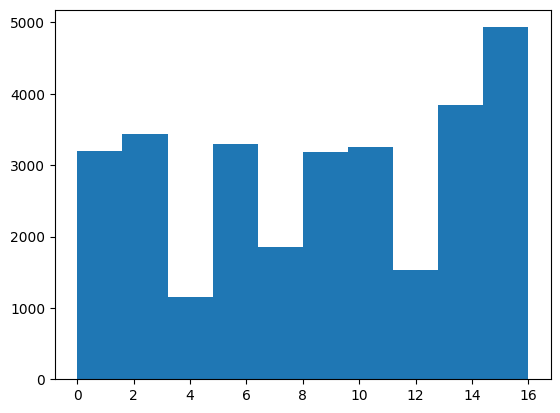

In [103]:
plt.hist(y_resampled_binarized)

In [30]:
import matplotlib.pyplot as plt

(array([2482.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4277.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

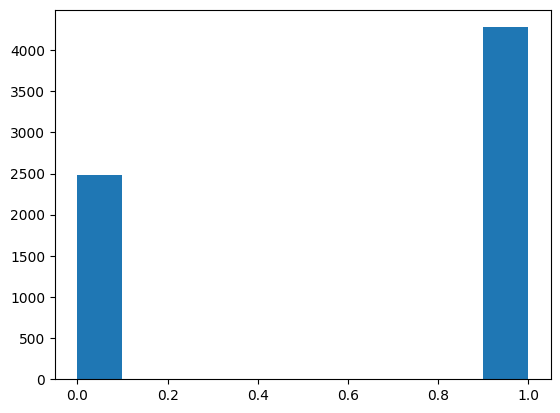

In [81]:
plt.hist(y_resampled)

In [17]:
def process_and_get_bounding_boxes_v6(tensor):
    """
    Compute bounding boxes, determine the voxel count per depth, and the inner region for each organ.
    Also computes a bounding box that encompasses all organs based on the inner_slices.
    
    Args:
    - tensor (numpy.ndarray): The input tensor with shape (D, H, W).
    
    Returns:
    - dict: Bounding boxes, voxel counts per depth, and inner regions for each organ.
            Also includes the encompassing bounding box for all organs.
    """
    
    # Initialize bounding boxes dictionary
    bounding_boxes = {}
    
    # List to store all coordinates within the inner_slices for all organs
    all_coords_in_inner_slices = []
    
    for organ_label, organ_name in SEGMENTATION_CODES.items():
        if organ_label == 0:  # Skip background
            continue

        # Fourier-based smoothing logic based on organ_name
        fourier_factor = 0
        threshold_factor = 0
        if organ_name == 'liver':
            fourier_factor = 0.05
            threshold_factor = 0.2
        elif organ_name == 'spleen':
            fourier_factor = 0.05
            threshold_factor = 0.3
        elif organ_name == 'kidney_left':
            fourier_factor = 0.05
            threshold_factor = 0.3
        elif organ_name == 'kidney_right':
            fourier_factor = 0.05
            threshold_factor = 0.35
        elif organ_name == 'bowel':
            fourier_factor = 0.025
            threshold_factor = 0.2
        
        # Find the slices where the organ appears
        slices = np.where(np.any(tensor[0] == organ_label, axis=(1, 2)))[0]
        
        if len(slices) == 0:  # If organ does not appear, continue to next organ
            continue
        
        # Compute voxel count for each slice and store in a dictionary with slice index as key
        voxel_counts_per_depth = {slice_idx: np.sum(tensor[0, slice_idx] == organ_label) for slice_idx in slices}
        
        # Fourier-based smoothing and thresholding
        # simple_list = list(voxel_counts_per_depth.values())
        # smoothed_list = fourier_smoothing(simple_list, fourier_factor)
        
        # # Thresholding logic
        # max_value = np.max(smoothed_list)
        # threshold = threshold_factor * max_value
        # in_threshold = np.where(np.array(smoothed_list) >= threshold)[0].tolist()

        # Fourier-based smoothing
        depths = list(voxel_counts_per_depth.keys())
        values = list(voxel_counts_per_depth.values())
        smoothed_values = fourier_smoothing(values, fourier_factor)
        voxel_counts_smoothed = dict(zip(depths, smoothed_values))
        
        # Thresholding logic
        max_value = np.max(smoothed_values)
        threshold = threshold_factor * max_value
        in_threshold = [depth for depth, value in voxel_counts_smoothed.items() if value >= threshold]
        # Extract slice indices that are in the inner region
        # inner_slices = get_contiguous_inner_slices(in_threshold, slices)

        # Gather all coordinates for this organ that are within the inner_slices
        # coords = np.argwhere((tensor[0] == organ_label) & np.isin(tensor[0], in_threshold))
        depth_mask = np.isin(np.arange(tensor.shape[1]), in_threshold)
        organ_mask = tensor[0] == organ_label
        combined_mask = np.logical_and(organ_mask, depth_mask[:, None, None])

        
        coords = np.argwhere(combined_mask)

        all_coords_in_inner_slices.extend(coords)
        
        # Bounding box computation for this organ
        min_coords = coords.min(axis=0)
        max_coords = coords.max(axis=0)
        
        bounding_boxes[organ_name] = {
            "top_left_front": tuple(min_coords),
            "bottom_right_back": tuple(max_coords),
            "depth_range": (min_coords[0], max_coords[0]),
            "voxel_counts_per_depth": voxel_counts_per_depth,
            "inner_slices": in_threshold
        }
    
    # Compute the encompassing bounding box for all organs based on inner_slices
    all_coords_array = np.array(all_coords_in_inner_slices)

    min_encompassing_coords = all_coords_array.min(axis=0)
    max_encompassing_coords = all_coords_array.max(axis=0)
    bounding_boxes["encompassing"] = {
        "top_left_front": tuple(min_encompassing_coords),
        "bottom_right_back": tuple(max_encompassing_coords),
        "depth_range": (min_encompassing_coords[0], max_encompassing_coords[0])
    }
        
    return bounding_boxes


def fourier_smoothing(y, cutoff_fraction=0.1):
    # Compute the FFT of the input data
    y_fft = np.fft.fft(y)
    
    # Zero out the higher frequencies
    cutoff_idx = int(cutoff_fraction * len(y_fft))
    y_fft[cutoff_idx:-cutoff_idx] = 0
    
    # Compute the inverse FFT to get the smoothed data
    y_smoothed = np.fft.ifft(y_fft).real  # Only take the real part
    
    return y_smoothed
    
def get_contiguous_inner_slices(in_threshold, slices):
    """
    Get contiguous blocks of slices that are above the threshold.
    
    Args:
    - in_threshold (list): A boolean list indicating if the slice is above the threshold.
    - slices (list): List of slice indices.
    
    Returns:
    - list: Contiguous inner slices.
    """
    inner_slices = []
    start_slice = None

    for i, val in enumerate(in_threshold):
        if val:
            if start_slice is None:  # Start of a new block
                start_slice = slices[i]
        else:
            if start_slice is not None:  # End of the current block
                inner_slices.extend(range(start_slice, slices[i]))
                start_slice = None

    if start_slice is not None:  # For the case where the last block reaches the end
        inner_slices.extend(range(start_slice, slices[-1] + 1))

    return inner_slices

# Function to save numpy array as .nii.gz
def save_nii(data, filename):
    img = nib.Nifti1Image(data, affine=np.eye(4))
    nib.save(img, filename)

In [33]:
# Iterate over unique patients
patient_id = unique_patients[10]
#for patient_id in tqdm(unique_patients[0:1]):
eval_df = curr_df[curr_df.patient_id == patient_id]
paths = np.array(eval_df.series_dir)
series_names = np.array(eval_df.series_id)

volumes = []

# For each series in a patient, sample the volume
for path, series_name in zip(paths, series_names):
    vol = sample_patient_volume(path, depth_downsample_rate=None, lw_downsample_rate=None, 
                              adjust_pixel_spacing="no", standardize_pixel_array="yes", 
                              target_pixel_spacing=[1.0, 1.0], target_thickness=None)
    volumes.append((series_name, vol))

# Filtering based on depth criterion
depths = [vol.shape[0] for _, vol in volumes]
max_depth = max(depths)

# Remove volumes that don't meet the depth criterion from the list
volumes = [(series_name, vol) for series_name, vol in volumes if vol.shape[0] >= 0.4 * max_depth]

# Save volumes and keep track of saved filepaths
saved_filepaths = []

for series_name, vol in volumes:
    filename = os.path.join(vol_directory, f"{series_name}.nii.gz")
    save_nii(vol, filename)
    saved_filepaths.append(filename)

# Create a data list for the Dataset using the saved_filepaths list
data_list = [{"image": filepath} for filepath in saved_filepaths]

(513, 512, 512)
(526, 512, 512)


In [34]:
#from torch.utils.data import DataLoader, Dataset

# Create DataLoader
test_org_ds = Dataset(data=data_list, transform=test_org_transforms)
test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=0)

# Initialize an empty list to store bounding box data
bbox_data_list = []

with torch.no_grad():
    # Loop through both filepaths (from DataLoader) and volumes
    for (test_data, (series_name, vol)) in zip(test_org_loader, volumes):

        test_inputs = test_data["image"].to(seg_model_device)
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        curr_data = sliding_window_inference(test_inputs, roi_size, sw_batch_size, seg_model)
        ideal_size = list(test_data['image_meta_dict']['spatial_shape'][0].cpu().detach().numpy())
        print(ideal_size)
        # Process the data
        segmented = curr_data.cpu()
        segmented_shape = segmented.shape
        
        #upsampled = F.interpolate(segmented, size=[ideal_size[0], segmented.shape[3], segmented.shape[4]], mode='trilinear', align_corners=True)

        merged = torch.argmax(segmented, dim=1)# + 1  # add 1 to move the range from 0-5 to 1-6

        print(merged.shape)

        bounding_boxes_result_v3 = process_and_get_bounding_boxes_v6(merged)
        
        # Given scale factors
        depth_scale_factor = ideal_size[0] / segmented_shape[2]
        height_scale_factor = ideal_size[1] / segmented_shape[3]
        width_scale_factor = ideal_size[2] / segmented_shape[4]
        
        # Scale the bounding box coordinates
        for organ_name, box_info in bounding_boxes_result_v3.items():
            # Scaling top_left_front
            min_coords = box_info["top_left_front"]
            scaled_min_coords = (
                round(min_coords[0] * depth_scale_factor),
                round(min_coords[1] * height_scale_factor),
                round(min_coords[2] * width_scale_factor)
            )
            box_info["top_left_front"] = scaled_min_coords
            
            # Scaling bottom_right_back
            max_coords = box_info["bottom_right_back"]
            scaled_max_coords = (
                round(max_coords[0] * depth_scale_factor),
                round(max_coords[1] * height_scale_factor),
                round(max_coords[2] * width_scale_factor)
            )
            box_info["bottom_right_back"] = scaled_max_coords
            
            # Scaling depth_range
            depth_range = box_info["depth_range"]
            scaled_depth_range = (
                round(depth_range[0] * depth_scale_factor),
                round(depth_range[1] * depth_scale_factor)
            )
            box_info["depth_range"] = scaled_depth_range

        
        del merged
        del segmented
        #del upsampled
        del curr_data
        del ideal_size
        
        torch.cuda.empty_cache()

        extracted_vol = extract_encompassing_subregion(vol, bounding_boxes_result_v3)
        extract_organ_subregion(vol, bounding_boxes_result_v3, organ_name)
        print(bounding_boxes_result_v3['encompassing'])
        print(extracted_vol.shape)
        break
        # # Initialize the CapsuleFeatureExtractor
        # cur_features = preprocess_and_extract_torch(volume = extracted_vol, 
        #                                             model = feature_extractor,
        #                                             device = feature_extractor_device,
        #                                             resize_to=(500, 224, 224), 
        #                                             use_three_channel=True, 
        #                                             overlap=True)
        

        # base_directory = os.path.join(current_directory, "entire_volume_features")
        # if not os.path.exists(base_directory):
        #     os.makedirs(base_directory)  # Create the 'entire_volume_features' directory
        
        # patient_directory = os.path.join(base_directory, str(series_name))
        # if not os.path.exists(patient_directory):
        #     os.makedirs(patient_directory)  # Create the subdirectory for the 'series_name'
            
                
        # feature_path = os.path.join(patient_directory, f"{series_name}_features.npy")
        # np.save(feature_path, cur_features)

[513, 512, 512]
torch.Size([1, 257, 256, 256])
{'top_left_front': (34, 36, 56), 'bottom_right_back': (411, 338, 428), 'depth_range': (34, 411)}
(378, 303, 373)


In [ ]:
# Iterate over unique patients
for patient_id in tqdm(unique_patients):
    eval_df = curr_df[curr_df.patient_id == patient_id]
    paths = np.array(eval_df.series_dir)
    series_names = np.array(eval_df.series_id)
    
    volumes = []
    
    # For each series in a patient, sample the volume
    for path, series_name in zip(paths, series_names):
        vol = sample_patient_volume(path, depth_downsample_rate=None, lw_downsample_rate=None, 
                                  adjust_pixel_spacing="no", standardize_pixel_array="yes", 
                                  target_pixel_spacing=[1.0, 1.0], target_thickness=None)
        volumes.append((series_name, vol))
    
    # Filtering based on depth criterion
    depths = [vol.shape[0] for _, vol in volumes]
    max_depth = max(depths)
    
    # Remove volumes that don't meet the depth criterion from the list
    volumes = [(series_name, vol) for series_name, vol in volumes if vol.shape[0] >= 0.4 * max_depth]
    
    # Save volumes and keep track of saved filepaths
    saved_filepaths = []
    
    for series_name, vol in volumes:
        filename = os.path.join(vol_directory, f"{series_name}.nii.gz")
        save_nii(vol, filename)
        saved_filepaths.append(filename)
    
    # Create a data list for the Dataset using the saved_filepaths list
    data_list = [{"image": filepath} for filepath in saved_filepaths]
    
    # Create DataLoader
    test_org_ds = Dataset(data=data_list, transform=test_org_transforms)
    test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=0)
    
    # Initialize an empty list to store bounding box data
    bbox_data_list = []
    
    with torch.no_grad():
        # Loop through both filepaths (from DataLoader) and volumes
        for (test_data, (series_name, vol)) in zip(test_org_loader, volumes):
    
            test_inputs = test_data["image"].to(seg_model_device)
            roi_size = (96, 96, 96)
            sw_batch_size = 4
            curr_data = sliding_window_inference(test_inputs, roi_size, sw_batch_size, seg_model)
            ideal_size = list(test_data['image_meta_dict']['spatial_shape'][0].cpu().detach().numpy())
            # Process the data
            segmented = curr_data.cpu()
            segmented_shape = segmented.shape
                
            merged = torch.argmax(segmented, dim=1)# + 1  # add 1 to move the range from 0-5 to 1-6
    
            # print(merged.shape)
    
            bounding_boxes_result_v3 = process_and_get_bounding_boxes_v6(merged)
            
            # Given scale factors
            depth_scale_factor = ideal_size[0] / segmented_shape[2]
            height_scale_factor = ideal_size[1] / segmented_shape[3]
            width_scale_factor = ideal_size[2] / segmented_shape[4]
            
            # Scale the bounding box coordinates
            for organ_name, box_info in bounding_boxes_result_v3.items():
                # Scaling top_left_front
                min_coords = box_info["top_left_front"]
                scaled_min_coords = (
                    round(min_coords[0] * depth_scale_factor),
                    round(min_coords[1] * height_scale_factor),
                    round(min_coords[2] * width_scale_factor)
                )
                box_info["top_left_front"] = scaled_min_coords
                
                # Scaling bottom_right_back
                max_coords = box_info["bottom_right_back"]
                scaled_max_coords = (
                    round(max_coords[0] * depth_scale_factor),
                    round(max_coords[1] * height_scale_factor),
                    round(max_coords[2] * width_scale_factor)
                )
                box_info["bottom_right_back"] = scaled_max_coords
                
                # Scaling depth_range
                depth_range = box_info["depth_range"]
                scaled_depth_range = (
                    round(depth_range[0] * depth_scale_factor),
                    round(depth_range[1] * depth_scale_factor)
                )
                box_info["depth_range"] = scaled_depth_range
    
            
            del merged
            del segmented
            del curr_data
            del ideal_size
            
            torch.cuda.empty_cache()
                # Ensure each organ has a bounding box. If not, set its volume to None.
            organs_volumes = {
                "encompassing": extract_encompassing_subregion(vol, bounding_boxes_result_v3) if "encompassing" in bounding_boxes_result_v3 else None,
                "liver": extract_organ_subregion(vol, bounding_boxes_result_v3, 'liver') if "liver" in bounding_boxes_result_v3 else None,
                "spleen": extract_organ_subregion(vol, bounding_boxes_result_v3, 'spleen') if "spleen" in bounding_boxes_result_v3 else None,
                "kidney_left": extract_organ_subregion(vol, bounding_boxes_result_v3, 'kidney_left') if "kidney_left" in bounding_boxes_result_v3 else None,
                "kidney_right": extract_organ_subregion(vol, bounding_boxes_result_v3, 'kidney_right') if "kidney_right" in bounding_boxes_result_v3 else None,
                "bowel": extract_organ_subregion(vol, bounding_boxes_result_v3, 'bowel') if "bowel" in bounding_boxes_result_v3 else None
            }
            
            # Dictionary for depths to resize to for each organ
            resize_depths = {
                "encompassing": 250,
                "liver": 100,
                "spleen": 50,
                "kidney_left": 50,
                "kidney_right": 50,
                "bowel": 150
            }
            
            for organ_name, organ_vol in organs_volumes.items():
                # Only proceed if the organ has a valid volume (not None)
                if organ_vol is not None:
                    depth_to_resize = resize_depths[organ_name]
                    
                    cur_features = preprocess_and_extract_torch(volume = organ_vol, 
                                                                model = feature_extractor,
                                                                device = feature_extractor_device,
                                                                resize_to=(depth_to_resize, 224, 224), 
                                                                use_three_channel=True, 
                                                                overlap=True)
                
                    base_directory = os.path.join(current_directory, "entire_volume_features")
                    if not os.path.exists(base_directory):
                        os.makedirs(base_directory)  # Create the 'entire_volume_features' directory
                
                    patient_directory = os.path.join(base_directory, str(series_name))
                    if not os.path.exists(patient_directory):
                        os.makedirs(patient_directory)  # Create the subdirectory for the 'series_name'
                
                    # Modify the feature_path to include the organ name
                    feature_path = os.path.join(patient_directory, f"{series_name}_{organ_name}_features.npy")
                    np.save(feature_path, cur_features)
            # print(bounding_boxes_result_v3['encompassing'])
            #print(extracted_vol.shape)
            # Initialize the CapsuleFeatureExtractor
            # cur_features = preprocess_and_extract_torch(volume = extracted_vol, 
            #                                             model = feature_extractor,
            #                                             device = feature_extractor_device,
            #                                             resize_to=(250, 224, 224), 
            #                                             use_three_channel=True, 
            #                                             overlap=True)
            
    
            # base_directory = os.path.join(current_directory, "entire_volume_features")
            # if not os.path.exists(base_directory):
            #     os.makedirs(base_directory)  # Create the 'entire_volume_features' directory
            
            # patient_directory = os.path.join(base_directory, str(series_name))
            # if not os.path.exists(patient_directory):
            #     os.makedirs(patient_directory)  # Create the subdirectory for the 'series_name'
                
                    
            # feature_path = os.path.join(patient_directory, f"{series_name}_features.npy")
            # np.save(feature_path, cur_features)

  0%|                                                           | 0/3147 [00:00<?, ?it/s]

(1022, 512, 512)
(1044, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 320.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 319.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 320.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 320.59it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 319.92it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 317.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 318.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 319.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 318.00it/s]

(103, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 317.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 318.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.78it/s]

  0%|                                                | 2/3147 [01:04<23:53:33, 27.35s/it]

(116, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 317.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 317.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.97it/s]

  0%|                                                | 3/3147 [01:09<15:08:48, 17.34s/it]

(169, 512, 713)
(515, 512, 582)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.78it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 317.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.73it/s]

  0%|                                                | 4/3147 [01:30<16:13:16, 18.58s/it]

(203, 512, 512)
(173, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 317.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 317.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.23it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.70it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 318.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.08it/s]

(167, 512, 512)
(168, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.28it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.33it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.21it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.74it/s]

(163, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.97it/s]

  0%|                                                | 7/3147 [02:04<11:11:47, 12.84s/it]

(219, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.87it/s]

  0%|                                                 | 8/3147 [02:12<9:52:42, 11.33s/it]

(106, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.01it/s]

  0%|▏                                                | 9/3147 [02:17<8:07:50,  9.33s/it]

(584, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.14it/s]

  0%|▏                                              | 10/3147 [02:36<10:36:57, 12.18s/it]

(803, 512, 512)
(701, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.86it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.12it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.75it/s]

(671, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.05it/s]

  0%|▏                                              | 12/3147 [03:45<19:36:39, 22.52s/it]

(205, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.02it/s]

  0%|▏                                              | 13/3147 [03:53<15:46:38, 18.12s/it]

(763, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.00it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.49it/s]

  0%|▏                                              | 14/3147 [04:16<17:03:15, 19.60s/it]

(394, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.56it/s]

  0%|▏                                              | 15/3147 [04:28<15:06:36, 17.37s/it]

(93, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 299.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.54it/s]

  1%|▏                                              | 16/3147 [04:33<11:48:41, 13.58s/it]

(690, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.30it/s]

  1%|▎                                              | 17/3147 [04:56<14:17:58, 16.45s/it]

(391, 512, 512)
(747, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.29it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.65it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.62it/s]

(602, 512, 512)
(858, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.97it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.42it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.49it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.32it/s]

(162, 512, 512)
(116, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.71it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.59it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 298.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.78it/s]

(98, 512, 512)
(57, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.82it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.64it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.50it/s]

  1%|▎                                              | 21/3147 [06:39<16:57:38, 19.53s/it]

(87, 512, 512)
(133, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 300.70it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.65it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 283.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 279.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 297.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 292.82it/s]

  1%|▎                                              | 22/3147 [06:49<14:39:22, 16.88s/it]

(89, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.49it/s]

  1%|▎                                              | 23/3147 [06:54<11:31:26, 13.28s/it]

(228, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.82it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.50it/s]

  1%|▎                                              | 24/3147 [07:03<10:21:48, 11.95s/it]

(171, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.95it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.16it/s]

  1%|▍                                               | 25/3147 [07:10<9:06:22, 10.50s/it]

(563, 512, 512)
(363, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 289.00it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 301.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 298.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.99it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.20it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.67it/s]

(327, 512, 512)
(327, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.74it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.76it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.36it/s]

(857, 512, 512)
(360, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.28it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.52it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.47it/s]

(794, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.81it/s]

  1%|▍                                              | 29/3147 [09:08<21:41:19, 25.04s/it]

(207, 512, 512)
(208, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.67it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.94it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.54it/s]

(265, 512, 512)
(122, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.82it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.42it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 315.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.25it/s]

(53, 512, 710)
(94, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.37it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.34it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.61it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.02it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.06it/s]

  1%|▍                                              | 32/3147 [09:50<14:43:55, 17.03s/it]

(200, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.03it/s]

  1%|▍                                              | 33/3147 [09:59<12:33:04, 14.51s/it]

(773, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.80it/s]

  1%|▌                                              | 34/3147 [10:23<15:06:27, 17.47s/it]

(220, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.67it/s]

  1%|▌                                              | 35/3147 [10:31<12:39:19, 14.64s/it]

(892, 512, 512)
(528, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.70it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.13it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.23it/s]

(211, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.03it/s]

  1%|▌                                              | 37/3147 [11:29<17:25:21, 20.17s/it]

(78, 512, 512)
(194, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.96it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.94it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.05it/s]

  1%|▌                                              | 38/3147 [11:41<15:16:57, 17.70s/it]

(128, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.65it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.13it/s]

  1%|▌                                              | 39/3147 [11:52<13:22:36, 15.49s/it]

(285, 512, 512)
(183, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.13it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.64it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.53it/s]

(59, 512, 512)
(210, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.01it/s]

  1%|▌                                              | 41/3147 [12:17<11:47:53, 13.67s/it]

(582, 512, 512)
(318, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.97it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.93it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.19it/s]

(830, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.77it/s]

  1%|▋                                              | 43/3147 [13:15<18:14:44, 21.16s/it]

(168, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.53it/s]

  1%|▋                                              | 44/3147 [13:22<14:32:15, 16.87s/it]

(187, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.27it/s]

  1%|▋                                              | 45/3147 [13:29<12:02:12, 13.97s/it]

(623, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.77it/s]

  1%|▋                                              | 46/3147 [13:51<14:01:12, 16.28s/it]

(706, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.00it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.58it/s]

  1%|▋                                              | 47/3147 [14:14<15:51:48, 18.42s/it]

(220, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.53it/s]

  2%|▋                                              | 48/3147 [14:23<13:19:52, 15.49s/it]

(501, 512, 512)
(505, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.46it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.59it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.92it/s]

(113, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.87it/s]

  2%|▋                                              | 50/3147 [14:59<13:27:34, 15.65s/it]

(124, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.46it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.18it/s]

  2%|▊                                              | 51/3147 [15:04<10:52:24, 12.64s/it]

(221, 512, 512)
(365, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.86it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.39it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.61it/s]

(164, 512, 512)
(166, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.47it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.33it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.25it/s]

(109, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.49it/s]

  2%|▊                                              | 54/3147 [15:44<10:04:39, 11.73s/it]

(765, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.93it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.13it/s]

  2%|▊                                              | 55/3147 [16:06<12:56:12, 15.06s/it]

(416, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.87it/s]

  2%|▊                                              | 56/3147 [16:30<15:06:01, 17.59s/it]

(229, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.71it/s]

  2%|▊                                              | 57/3147 [16:38<12:45:03, 14.86s/it]

(268, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 279.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.93it/s]

  2%|▊                                              | 58/3147 [16:48<11:21:52, 13.24s/it]

(95, 512, 512)
(166, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.82it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.79it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.14it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 315.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.90it/s]

  2%|▉                                              | 59/3147 [16:59<10:44:45, 12.53s/it]

(665, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.35it/s]

  2%|▉                                              | 60/3147 [17:19<12:40:58, 14.79s/it]

(84, 512, 512)
(160, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.98it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.20it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.50it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.00it/s]

  2%|▉                                              | 61/3147 [17:33<12:36:44, 14.71s/it]

(327, 512, 512)
(375, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.04it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.54it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 300.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.75it/s]

(211, 512, 512)
(81, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.63it/s]

  2%|▉                                              | 63/3147 [18:06<12:43:08, 14.85s/it]

(80, 512, 512)
(190, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.58it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.66it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.38it/s]

  2%|▉                                              | 64/3147 [18:19<12:08:19, 14.17s/it]

(116, 512, 512)
(170, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.34it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.64it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.52it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.70it/s]

(215, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.51it/s]

  2%|▉                                              | 66/3147 [18:39<10:16:44, 12.01s/it]

(651, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.96it/s]

  2%|█                                              | 67/3147 [19:01<12:49:18, 14.99s/it]

(99, 512, 789)
(172, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 292.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.92it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.19it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.53it/s]

  2%|█                                              | 68/3147 [19:14<12:15:37, 14.34s/it]

(199, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.40it/s]

  2%|█                                              | 69/3147 [19:22<10:39:40, 12.47s/it]

(578, 512, 512)
(571, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.33it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.04it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.12it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.90it/s]

(451, 512, 512)
(457, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.95it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.89it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.38it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.50it/s]

(195, 512, 512)
(81, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.15it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.02it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.53it/s]

  2%|█                                              | 72/3147 [20:38<16:12:23, 18.97s/it]

(650, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.59it/s]

  2%|█                                              | 73/3147 [21:00<16:57:55, 19.87s/it]

(87, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.46it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.48it/s]

  2%|█                                              | 74/3147 [21:04<13:01:00, 15.25s/it]

(162, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.47it/s]

  2%|█                                              | 75/3147 [21:11<10:47:19, 12.64s/it]

(648, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.29it/s]

  2%|█▏                                             | 76/3147 [21:32<12:51:29, 15.07s/it]

(637, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.08it/s]

  2%|█▏                                             | 77/3147 [21:53<14:22:11, 16.85s/it]

(630, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.07it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.45it/s]

  2%|█▏                                             | 78/3147 [22:14<15:27:22, 18.13s/it]

(936, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.72it/s]

  3%|█▏                                             | 79/3147 [22:43<18:12:08, 21.36s/it]

(663, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.55it/s]

  3%|█▏                                             | 80/3147 [23:04<18:17:38, 21.47s/it]

(621, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.03it/s]

  3%|█▏                                             | 81/3147 [23:23<17:41:36, 20.78s/it]

(106, 512, 512)
(164, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.18it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.62it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.61it/s]

(170, 512, 512)
(320, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.53it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.32it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 292.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.08it/s]

(841, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.86it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.80it/s]

  3%|█▎                                             | 84/3147 [24:34<20:00:39, 23.52s/it]

(768, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.57it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.78it/s]

  3%|█▎                                             | 85/3147 [25:23<26:40:36, 31.36s/it]

(788, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.21it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.32it/s]

  3%|█▎                                             | 86/3147 [25:49<25:10:28, 29.61s/it]

(232, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.22it/s]

  3%|█▎                                             | 87/3147 [25:58<19:53:27, 23.40s/it]

(603, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 288.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.64it/s]

  3%|█▎                                             | 88/3147 [26:18<19:11:05, 22.58s/it]

(171, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.97it/s]

  3%|█▎                                             | 89/3147 [26:25<15:11:32, 17.88s/it]

(473, 512, 512)
(314, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.38it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.07it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.89it/s]

(85, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.71it/s]

  3%|█▎                                             | 91/3147 [26:56<13:13:28, 15.58s/it]

(853, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.73it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.31it/s]

  3%|█▎                                             | 92/3147 [27:22<15:58:34, 18.83s/it]

(188, 512, 512)
(126, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.72it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.94it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.03it/s]

(611, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.71it/s]

  3%|█▍                                             | 94/3147 [27:55<15:13:00, 17.94s/it]

(253, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.96it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.36it/s]

  3%|█▍                                             | 95/3147 [28:04<12:59:27, 15.32s/it]

(66, 512, 512)
(198, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.86it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.13it/s]

  3%|█▍                                             | 96/3147 [28:13<11:17:31, 13.32s/it]

(287, 512, 512)
(171, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.67it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.48it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.46it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.98it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.53it/s]

(300, 512, 512)
(300, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.52it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.14it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.84it/s]

(168, 512, 676)
(72, 512, 791)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.72it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.30it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.95it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.97it/s]

  3%|█▍                                             | 99/3147 [29:04<12:59:09, 15.34s/it]

(191, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.06it/s]

  3%|█▍                                            | 100/3147 [29:12<11:00:25, 13.00s/it]

(91, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.33it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.47it/s]

  3%|█▌                                             | 101/3147 [29:16<8:55:11, 10.54s/it]

(853, 512, 512)
(662, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.78it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.01it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.08it/s]

(95, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.21it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.77it/s]

  3%|█▌                                            | 103/3147 [30:08<13:51:28, 16.39s/it]

(313, 512, 512)
(313, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.84it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.92it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.03it/s]

(187, 512, 512)
(74, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.67it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.48it/s]

  3%|█▌                                            | 105/3147 [30:37<12:27:22, 14.74s/it]

(743, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.14it/s]

  3%|█▌                                            | 106/3147 [31:00<14:40:07, 17.37s/it]

(225, 512, 512)
(226, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.98it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.11it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.13it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.31it/s]

(151, 512, 512)
(114, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.61it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.30it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.07it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.16it/s]

(795, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.19it/s]

  3%|█▌                                            | 109/3147 [31:52<15:12:28, 18.02s/it]

(107, 512, 512)
(173, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.53it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.49it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.42it/s]

(664, 512, 512)
(664, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.18it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.20it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.15it/s]

(261, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.93it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.16it/s]

  4%|█▋                                            | 112/3147 [32:55<16:18:00, 19.33s/it]

(104, 512, 662)
(196, 512, 732)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.74it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.52it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 276.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.55it/s]

(292, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.00it/s]

  4%|█▋                                            | 114/3147 [33:21<13:29:35, 16.02s/it]

(193, 512, 512)
(165, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.40it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 301.93it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.80it/s]

(206, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.14it/s]

  4%|█▋                                            | 116/3147 [33:43<11:10:09, 13.27s/it]

(287, 512, 512)
(287, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.28it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.57it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.71it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.31it/s]

(103, 512, 512)
(127, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.63it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.30it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

  4%|█▋                                            | 118/3147 [34:15<11:47:32, 14.02s/it]

(317, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.83it/s]

  4%|█▋                                            | 119/3147 [34:25<10:56:33, 13.01s/it]

(195, 512, 512)
(91, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.06it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.88it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.18it/s]

(178, 512, 512)
(118, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.65it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.14it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.40it/s]

(986, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.27it/s]

  4%|█▊                                            | 122/3147 [35:20<14:56:17, 17.78s/it]

(749, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.89it/s]

  4%|█▊                                            | 123/3147 [35:45<16:50:17, 20.05s/it]

(197, 512, 512)
(197, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.31it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.60it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.96it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.01it/s]

(106, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.20it/s]

  4%|█▊                                            | 125/3147 [36:06<12:17:53, 14.65s/it]

(130, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

  4%|█▊                                            | 126/3147 [36:12<10:01:18, 11.94s/it]

(327, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.34it/s]

  4%|█▉                                             | 127/3147 [36:22<9:38:36, 11.50s/it]

(186, 512, 512)
(136, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.89it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.00it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.93it/s]

(85, 512, 512)
(167, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.21it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.47it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.13it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.82it/s]

  4%|█▉                                             | 129/3147 [36:47<9:51:38, 11.76s/it]

(839, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.22it/s]

  4%|█▉                                            | 130/3147 [37:12<13:14:12, 15.79s/it]

(707, 512, 512)
(751, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.14it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.47it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.90it/s]

(289, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.30it/s]

  4%|█▉                                            | 132/3147 [38:07<16:55:05, 20.20s/it]

(242, 512, 512)
(210, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.87it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.95it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.86it/s]

(249, 512, 777)
(255, 512, 621)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.63it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.27it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.29it/s]

(147, 512, 512)
(125, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.19it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.96it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.37it/s]

(676, 512, 512)
(667, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.28it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.90it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.83it/s]

(324, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.21it/s]

  4%|██                                            | 137/3147 [39:52<17:28:31, 20.90s/it]

(442, 512, 512)
(1000, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.52it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.62it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.61it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.77it/s]

(635, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.93it/s]

  4%|██                                            | 139/3147 [40:59<21:53:19, 26.20s/it]

(573, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.93it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.89it/s]

  4%|██                                            | 140/3147 [41:19<20:16:56, 24.28s/it]

(101, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.39it/s]

  4%|██                                            | 141/3147 [41:24<15:26:10, 18.49s/it]

(529, 512, 512)
(529, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.51it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.39it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.57it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.68it/s]

(149, 512, 512)
(298, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.69it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 307.87it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.35it/s]

(87, 512, 512)
(154, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 300.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.87it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 308.30it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.36it/s]

  5%|██                                            | 144/3147 [42:26<15:11:36, 18.21s/it]

(123, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.63it/s]

  5%|██                                            | 145/3147 [42:31<12:00:49, 14.41s/it]

(125, 512, 512)
(187, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 281.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.39it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 308.52it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.02it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.72it/s]

(221, 512, 512)
(217, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.77it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.20it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.33it/s]

(143, 512, 512)
(210, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 291.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.79it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 303.35it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.38it/s]

(371, 512, 512)
(465, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.59it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 303.91it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.70it/s]

(235, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.08it/s]

  5%|██▏                                           | 150/3147 [43:51<12:59:45, 15.61s/it]

(108, 512, 512)
(169, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.72it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 309.93it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.93it/s]

(239, 512, 512)
(323, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.91it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.26it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.24it/s]

(711, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.29it/s]

  5%|██▏                                           | 153/3147 [44:46<15:09:12, 18.22s/it]

(68, 512, 512)
(247, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.76it/s]

  5%|██▎                                           | 154/3147 [44:55<12:52:42, 15.49s/it]

(634, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.29it/s]

  5%|██▎                                           | 155/3147 [45:16<14:19:06, 17.23s/it]

(110, 512, 512)
(189, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.76it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.75it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.45it/s]

(476, 512, 512)
(210, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.23it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.68it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.16it/s]

(718, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.51it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.32it/s]

  5%|██▎                                           | 158/3147 [46:15<16:20:22, 19.68s/it]

(441, 512, 512)
(193, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.07it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.16it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.75it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.98it/s]

(643, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.12it/s]

  5%|██▎                                           | 160/3147 [46:57<17:00:59, 20.51s/it]

(625, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.80it/s]

  5%|██▎                                           | 161/3147 [47:19<17:12:38, 20.75s/it]

(215, 512, 512)
(233, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.11it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.71it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.86it/s]

(297, 512, 512)
(378, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.51it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.32it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.94it/s]

(119, 512, 512)
(188, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.40it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.93it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.46it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.01it/s]

(279, 512, 512)
(287, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.65it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.24it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.18it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.05it/s]

(279, 512, 512)
(540, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.58it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.86it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.00it/s]

(666, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.08it/s]

  5%|██▍                                           | 167/3147 [49:21<18:08:16, 21.91s/it]

(157, 512, 512)
(182, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.74it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.29it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.89it/s]

(215, 512, 512)
(220, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.88it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.12it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.78it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.39it/s]

(92, 512, 512)
(145, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.88it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.99it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.98it/s]

(314, 512, 512)
(569, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.19it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.16it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.26it/s]

(657, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.93it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.51it/s]

  5%|██▌                                           | 172/3147 [50:54<17:21:52, 21.01s/it]

(174, 512, 512)
(209, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.86it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.14it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.14it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.47it/s]

(260, 512, 512)
(340, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.50it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.43it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.11it/s]

(495, 512, 512)
(330, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.88it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.11it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.76it/s]

(90, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.86it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.89it/s]

  6%|██▌                                           | 176/3147 [52:03<13:57:27, 16.91s/it]

(225, 512, 512)
(62, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.63it/s]

  6%|██▌                                           | 177/3147 [52:12<12:03:17, 14.61s/it]

(94, 512, 512)
(164, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.39it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.68it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.47it/s]

(389, 512, 512)
(369, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.74it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 308.95it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.01it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.39it/s]

(715, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.33it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.52it/s]

  6%|██▋                                           | 180/3147 [53:12<15:34:36, 18.90s/it]

(278, 512, 512)
(271, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.87it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.09it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.11it/s]

(70, 512, 512)
(211, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.56it/s]

  6%|██▋                                           | 182/3147 [53:39<13:01:37, 15.82s/it]

(663, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.60it/s]

  6%|██▋                                           | 183/3147 [54:01<14:26:39, 17.54s/it]

(55, 512, 512)
(101, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.02it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.07it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.77it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.20it/s]

  6%|██▋                                           | 184/3147 [54:10<12:14:32, 14.87s/it]

(207, 512, 512)
(114, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.76it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.65it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.93it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.51it/s]

(257, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.05it/s]

  6%|██▋                                           | 186/3147 [54:32<10:34:55, 12.87s/it]

(274, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.31it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.33it/s]

  6%|██▊                                            | 187/3147 [54:42<9:49:02, 11.94s/it]

(99, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.82it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.20it/s]

  6%|██▊                                            | 188/3147 [54:47<7:58:37,  9.71s/it]

(180, 512, 512)
(107, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.15it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.45it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.83it/s]

(129, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.72it/s]

  6%|██▊                                            | 190/3147 [55:05<7:26:02,  9.05s/it]

(84, 512, 512)
(174, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.69it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.50it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 289.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.74it/s]

  6%|██▊                                            | 191/3147 [55:17<8:10:27,  9.96s/it]

(71, 512, 512)
(189, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.03it/s]

  6%|██▊                                            | 192/3147 [55:24<7:33:29,  9.21s/it]

(196, 512, 512)
(132, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 300.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.08it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.52it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.30it/s]

(163, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.50it/s]

  6%|██▉                                            | 194/3147 [55:45<7:42:21,  9.39s/it]

(579, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.98it/s]

  6%|██▊                                           | 195/3147 [56:05<10:22:50, 12.66s/it]

(327, 512, 512)
(297, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.82it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.92it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.39it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.37it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.22it/s]

(632, 512, 512)
(724, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 299.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.58it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.32it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.22it/s]

(134, 512, 512)
(189, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.78it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.02it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.57it/s]

(284, 512, 512)
(284, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.78it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.76it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.90it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.90it/s]

(192, 512, 512)
(106, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.37it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.70it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.90it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.08it/s]

(371, 512, 512)
(371, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.90it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.46it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

(111, 512, 512)
(197, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.68it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.93it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.98it/s]

(175, 512, 512)
(104, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.03it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.04it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.27it/s]

(747, 512, 512)
(196, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

  6%|██▉                                           | 204/3147 [59:21<16:07:49, 19.73s/it]

(254, 512, 512)
(545, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.11it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.41it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.20it/s]

(274, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.34it/s]

  7%|███                                           | 206/3147 [59:58<14:56:26, 18.29s/it]

(293, 512, 512)
(293, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.51it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.27it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.40it/s]

(249, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.98it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.30it/s]

  7%|██▉                                         | 208/3147 [1:00:27<12:52:38, 15.77s/it]

(199, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.01it/s]

  7%|██▉                                         | 209/3147 [1:00:35<10:59:55, 13.48s/it]

(111, 512, 512)
(182, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.29it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.14it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.07it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.19it/s]

(177, 512, 512)
(115, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.79it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.11it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.91it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.53it/s]

(110, 512, 512)
(160, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.67it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.12it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.59it/s]

(61, 512, 512)
(187, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.69it/s]

  7%|███                                          | 213/3147 [1:01:22<9:35:37, 11.77s/it]

(671, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.90it/s]

  7%|██▉                                         | 214/3147 [1:01:43<11:53:21, 14.59s/it]

(1247, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.02it/s]

  7%|███                                         | 215/3147 [1:02:17<16:29:36, 20.25s/it]

(633, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.14it/s]

  7%|███                                         | 216/3147 [1:02:38<16:42:33, 20.52s/it]

(741, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.34it/s]

  7%|███                                         | 217/3147 [1:02:59<16:52:18, 20.73s/it]

(231, 512, 512)
(198, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.90it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.24it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.37it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.98it/s]

(343, 512, 512)
(781, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.39it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 307.29it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 274.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.01it/s]

(441, 512, 512)
(266, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.46it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.62it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.66it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.16it/s]

(324, 512, 512)
(696, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 293.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.36it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 308.34it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.31it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.82it/s]

(192, 512, 512)
(179, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.95it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.64it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.30it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.67it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 301.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.77it/s]

(503, 512, 512)
(331, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.56it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.74it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.97it/s]

(105, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.48it/s]

  7%|███▏                                        | 224/3147 [1:05:45<15:58:14, 19.67s/it]

(189, 512, 512)
(81, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.08it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.43it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.21it/s]

  7%|███▏                                        | 225/3147 [1:05:56<13:55:43, 17.16s/it]

(170, 512, 512)
(108, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.73it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.08it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.52it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.93it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.28it/s]

(107, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.01it/s]

  7%|███▏                                        | 227/3147 [1:06:14<10:13:13, 12.60s/it]

(329, 512, 512)
(329, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.55it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.34it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.51it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.12it/s]

(617, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.56it/s]

  7%|███▏                                        | 229/3147 [1:06:55<13:11:00, 16.26s/it]

(241, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.74it/s]

  7%|███▏                                        | 230/3147 [1:07:03<11:22:23, 14.04s/it]

(190, 512, 512)
(369, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.46it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.42it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 299.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.58it/s]

(243, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.79it/s]

  7%|███▏                                        | 232/3147 [1:07:31<10:55:21, 13.49s/it]

(336, 512, 512)
(289, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.02it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.83it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.77it/s]

(225, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.73it/s]

  7%|███▎                                        | 234/3147 [1:08:05<11:43:18, 14.49s/it]

(89, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.56it/s]

  7%|███▎                                         | 235/3147 [1:08:09<9:17:20, 11.48s/it]

(701, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.47it/s]

  7%|███▎                                        | 236/3147 [1:08:32<11:58:37, 14.81s/it]

(216, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.89it/s]

  8%|███▎                                        | 237/3147 [1:08:41<10:32:06, 13.03s/it]

(158, 512, 512)
(209, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.46it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.86it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.59it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

(170, 512, 512)
(116, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.39it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.19it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.58it/s]

(386, 512, 512)
(582, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.91it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.02it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

(790, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.52it/s]

  8%|███▎                                        | 241/3147 [1:10:02<16:12:00, 20.07s/it]

(245, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.39it/s]

  8%|███▍                                        | 242/3147 [1:10:11<13:34:04, 16.81s/it]

(157, 512, 512)
(156, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.03it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.48it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.26it/s]

(713, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.11it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.47it/s]

  8%|███▍                                        | 244/3147 [1:10:46<14:12:14, 17.61s/it]

(180, 512, 580)
(105, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.78it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.04it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.93it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.58it/s]

(233, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.44it/s]

  8%|███▍                                        | 246/3147 [1:11:07<11:07:26, 13.80s/it]

(104, 512, 512)
(199, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.68it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.89it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.64it/s]

  8%|███▍                                        | 247/3147 [1:11:21<10:59:18, 13.64s/it]

(344, 512, 512)
(760, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.23it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.30it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

(899, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.10it/s]

  8%|███▍                                        | 249/3147 [1:12:27<18:36:47, 23.12s/it]

(682, 512, 512)
(401, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.65it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.89it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.82it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.00it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.51it/s]

(513, 512, 512)
(526, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.35it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.01it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.33it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.71it/s]

(207, 512, 512)
(133, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.26it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.37it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.20it/s]

(104, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.56it/s]

  8%|███▌                                        | 253/3147 [1:13:56<15:03:44, 18.74s/it]

(117, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.03it/s]

  8%|███▌                                        | 254/3147 [1:14:01<11:50:48, 14.74s/it]

(212, 512, 512)
(91, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.33it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.91it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.38it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.51it/s]

  8%|███▌                                        | 255/3147 [1:14:14<11:19:49, 14.10s/it]

(108, 512, 512)
(177, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.83it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.40it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.38it/s]

(743, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.96it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.57it/s]

  8%|███▌                                        | 257/3147 [1:14:50<13:16:26, 16.54s/it]

(202, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.24it/s]

  8%|███▌                                        | 258/3147 [1:14:58<11:15:15, 14.02s/it]

(108, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.78it/s]

  8%|███▋                                         | 259/3147 [1:15:03<9:11:16, 11.45s/it]

(95, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.94it/s]

  8%|███▋                                         | 260/3147 [1:15:08<7:34:15,  9.44s/it]

(403, 512, 512)
(170, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.38it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.73it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.80it/s]

(95, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.85it/s]

  8%|███▋                                         | 262/3147 [1:15:31<7:58:18,  9.95s/it]

(173, 512, 512)
(121, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.51it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.96it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.82it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.11it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 299.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.45it/s]

(197, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.28it/s]

  8%|███▊                                         | 264/3147 [1:15:52<7:56:21,  9.91s/it]

(324, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.34it/s]

  8%|███▊                                         | 265/3147 [1:16:03<8:11:30, 10.23s/it]

(180, 512, 512)
(190, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.42it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.87it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.28it/s]

(742, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.66it/s]

  8%|███▋                                        | 267/3147 [1:16:41<12:10:26, 15.22s/it]

(681, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.84it/s]

  9%|███▋                                        | 268/3147 [1:17:03<13:47:06, 17.24s/it]

(209, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.54it/s]

  9%|███▊                                        | 269/3147 [1:17:11<11:35:25, 14.50s/it]

(137, 512, 512)
(211, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.38it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.49it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.44it/s]

(196, 512, 512)
(331, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 298.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 299.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 299.70it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 298.63it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.22it/s]

(169, 512, 512)
(181, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.56it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.66it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.84it/s]

(170, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 289.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 295.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 297.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 296.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 297.27it/s]

  9%|███▊                                        | 273/3147 [1:18:05<10:10:05, 12.74s/it]

(194, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.22it/s]

  9%|███▉                                         | 274/3147 [1:18:13<9:01:43, 11.31s/it]

(161, 512, 512)
(74, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 293.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.91it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 303.47it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.52it/s]

  9%|███▉                                         | 275/3147 [1:18:23<8:43:26, 10.94s/it]

(696, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.30it/s]

  9%|███▊                                        | 276/3147 [1:18:47<11:57:05, 14.99s/it]

(287, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.83it/s]

  9%|███▊                                        | 277/3147 [1:18:57<10:40:34, 13.39s/it]

(612, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.01it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.64it/s]

  9%|███▉                                        | 278/3147 [1:19:18<12:24:41, 15.57s/it]

(112, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.35it/s]

  9%|███▉                                        | 279/3147 [1:19:25<10:20:46, 12.99s/it]

(230, 512, 512)
(1531, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 300.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.41it/s]

  9%|███▉                                        | 280/3147 [1:20:15<19:12:31, 24.12s/it]

(632, 512, 512)
(403, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.76it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 309.76it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.31it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.85it/s]

(631, 512, 512)
(631, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.54it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.40it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.49it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.69it/s]

(139, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.95it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.14it/s]

  9%|███▉                                        | 283/3147 [1:21:37<18:52:12, 23.72s/it]

(100, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.51it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.79it/s]

  9%|███▉                                        | 284/3147 [1:21:42<14:25:06, 18.13s/it]

(180, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.51it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.04it/s]

  9%|███▉                                        | 285/3147 [1:21:49<11:49:04, 14.87s/it]

(185, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.74it/s]

  9%|████                                         | 286/3147 [1:21:56<9:59:15, 12.57s/it]

(113, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.00it/s]

  9%|████                                         | 287/3147 [1:22:02<8:16:49, 10.42s/it]

(618, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.46it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.44it/s]

  9%|████                                        | 288/3147 [1:22:21<10:20:48, 13.03s/it]

(181, 512, 512)
(183, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 284.21it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.82it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.92it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.60it/s]

(117, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.73it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.59it/s]

  9%|████▏                                        | 290/3147 [1:22:41<8:46:15, 11.05s/it]

(120, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.31it/s]

  9%|████▏                                        | 291/3147 [1:22:46<7:27:02,  9.39s/it]

(217, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.39it/s]

  9%|████▏                                        | 292/3147 [1:22:55<7:15:50,  9.16s/it]

(172, 512, 512)
(118, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.74it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.26it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.21it/s]

(684, 512, 512)
(246, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.37it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.58it/s]

  9%|████                                        | 294/3147 [1:23:32<11:35:05, 14.62s/it]

(214, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.02it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.82it/s]

  9%|████                                        | 295/3147 [1:23:40<10:02:35, 12.68s/it]

(85, 512, 512)
(207, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.38it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.68it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.35it/s]

  9%|████▏                                        | 296/3147 [1:23:53<9:57:22, 12.57s/it]

(74, 512, 512)
(159, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.31it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.47it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.98it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.47it/s]

  9%|████▏                                        | 297/3147 [1:24:03<9:26:47, 11.93s/it]

(399, 512, 512)
(613, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.56it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.67it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.28it/s]

(663, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.75it/s]

 10%|████▏                                       | 299/3147 [1:25:01<15:44:36, 19.90s/it]

(144, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.59it/s]

 10%|████▏                                       | 300/3147 [1:25:09<12:56:15, 16.36s/it]

(878, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.08it/s]

 10%|████▏                                       | 301/3147 [1:25:36<15:38:35, 19.79s/it]

(209, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.86it/s]

 10%|████▏                                       | 302/3147 [1:25:45<12:57:25, 16.40s/it]

(806, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.11it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.59it/s]

 10%|████▏                                       | 303/3147 [1:26:09<14:46:59, 18.71s/it]

(188, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.52it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.13it/s]

 10%|████▎                                       | 304/3147 [1:26:17<12:06:53, 15.34s/it]

(656, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.65it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.14it/s]

 10%|████▎                                       | 305/3147 [1:26:47<15:46:37, 19.98s/it]

(122, 512, 512)
(166, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.33it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.54it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 316.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.54it/s]

 10%|████▎                                       | 306/3147 [1:26:59<13:50:16, 17.54s/it]

(52, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.69it/s]

 10%|████▎                                       | 307/3147 [1:27:03<10:33:27, 13.38s/it]

(100, 512, 512)
(152, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.01it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.19it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 315.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.20it/s]

(91, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.61it/s]

 10%|████▍                                        | 309/3147 [1:27:19<8:10:02, 10.36s/it]

(633, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.92it/s]

 10%|████▎                                       | 310/3147 [1:27:41<10:48:33, 13.72s/it]

(55, 512, 512)
(194, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.16it/s]

 10%|████▍                                        | 311/3147 [1:27:49<9:29:42, 12.05s/it]

(53, 512, 512)
(95, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.93it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.65it/s]

 10%|████▍                                        | 312/3147 [1:27:57<8:35:34, 10.91s/it]

(610, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.34it/s]

 10%|████▍                                       | 313/3147 [1:28:17<10:46:33, 13.69s/it]

(187, 512, 512)
(195, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.77it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.10it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.72it/s]

(88, 512, 512)
(175, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.90it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.85it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.37it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.99it/s]

 10%|████▍                                       | 315/3147 [1:28:43<10:26:52, 13.28s/it]

(107, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.97it/s]

 10%|████▌                                        | 316/3147 [1:28:49<8:31:24, 10.84s/it]

(696, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.15it/s]

 10%|████▍                                       | 317/3147 [1:29:13<11:39:05, 14.82s/it]

(725, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.75it/s]

 10%|████▍                                       | 318/3147 [1:29:33<12:58:39, 16.51s/it]

(323, 512, 512)
(588, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.26it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.05it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.72it/s]

(89, 512, 512)
(169, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.87it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.64it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 315.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.13it/s]

 10%|████▍                                       | 320/3147 [1:30:16<14:12:23, 18.09s/it]

(1516, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.49it/s]

 10%|████▍                                       | 321/3147 [1:31:00<20:23:26, 25.98s/it]

(203, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.92it/s]

 10%|████▌                                       | 322/3147 [1:31:08<16:08:37, 20.57s/it]

(104, 512, 512)
(152, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.32it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.46it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.71it/s]

(74, 512, 512)
(211, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.73it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.88it/s]

 10%|████▌                                       | 324/3147 [1:31:29<11:58:19, 15.27s/it]

(132, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.94it/s]

 10%|████▋                                        | 325/3147 [1:31:35<9:49:15, 12.53s/it]

(131, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.03it/s]

 10%|████▋                                        | 326/3147 [1:31:41<8:13:52, 10.50s/it]

(139, 512, 512)
(70, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.51it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.35it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.66it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.46it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.11it/s]

 10%|████▋                                        | 327/3147 [1:31:51<8:05:56, 10.34s/it]

(735, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.44it/s]

 10%|████▌                                       | 328/3147 [1:32:14<11:03:12, 14.12s/it]

(61, 512, 512)
(202, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.90it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.57it/s]

 10%|████▋                                        | 329/3147 [1:32:23<9:45:01, 12.46s/it]

(157, 512, 512)
(101, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.49it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.90it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.06it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.91it/s]

(166, 512, 512)
(139, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.02it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.14it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.99it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.46it/s]

(168, 512, 512)
(132, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.90it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.76it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.69it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.25it/s]

(423, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.52it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.31it/s]

 11%|████▊                                        | 333/3147 [1:33:13<9:53:42, 12.66s/it]

(717, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.33it/s]

 11%|████▋                                       | 334/3147 [1:33:36<12:23:35, 15.86s/it]

(196, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.11it/s]

 11%|████▋                                       | 335/3147 [1:33:44<10:31:42, 13.48s/it]

(86, 512, 512)
(140, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.96it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.79it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.20it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.11it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.07it/s]

 11%|████▊                                        | 336/3147 [1:33:54<9:48:26, 12.56s/it]

(48, 512, 512)
(94, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.95it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.91it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.99it/s]

 11%|████▊                                        | 337/3147 [1:34:03<8:52:19, 11.37s/it]

(193, 512, 512)
(174, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.93it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.90it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.09it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

(120, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.62it/s]

 11%|████▊                                        | 339/3147 [1:34:24<8:08:08, 10.43s/it]

(90, 512, 512)
(64, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.45it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.51it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.14it/s]

 11%|████▊                                        | 340/3147 [1:34:34<8:11:57, 10.52s/it]

(740, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.65it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.50it/s]

 11%|████▊                                       | 341/3147 [1:34:58<11:19:55, 14.54s/it]

(301, 512, 512)
(165, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.90it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.63it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.85it/s]

(109, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.26it/s]

 11%|████▉                                        | 343/3147 [1:35:20<9:22:36, 12.04s/it]

(268, 512, 512)
(171, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.56it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.84it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.78it/s]

(173, 512, 879)
(103, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.57it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.21it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.46it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.17it/s]

(195, 512, 512)
(100, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.08it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 302.20it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.90it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 301.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.22it/s]

 11%|████▊                                       | 346/3147 [1:36:04<10:28:39, 13.47s/it]

(169, 512, 512)
(106, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.27it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.44it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.62it/s]

(262, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.09it/s]

 11%|████▉                                        | 348/3147 [1:36:25<9:12:12, 11.84s/it]

(215, 512, 512)
(157, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.51it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.64it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.40it/s]

(290, 512, 512)
(173, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.63it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.09it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.15it/s]

(119, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 293.68it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.19it/s]

 11%|█████                                        | 351/3147 [1:37:02<8:49:28, 11.36s/it]

(109, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.28it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.14it/s]

 11%|█████                                        | 352/3147 [1:37:07<7:24:03,  9.53s/it]

(180, 512, 512)
(62, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.50it/s]

 11%|█████                                        | 353/3147 [1:37:14<6:54:30,  8.90s/it]

(92, 512, 512)
(59, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.78it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 309.88it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.32it/s]

 11%|█████                                        | 354/3147 [1:37:22<6:45:09,  8.70s/it]

(723, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.36it/s]

 11%|█████                                        | 355/3147 [1:37:44<9:40:57, 12.48s/it]

(157, 512, 512)
(106, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.41it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.84it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.57it/s]

(54, 512, 512)
(85, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.82it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.30it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.68it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.62it/s]

 11%|█████                                        | 357/3147 [1:38:04<8:35:07, 11.08s/it]

(114, 512, 512)
(176, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.28it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.64it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.16it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.88it/s]

(315, 512, 512)
(193, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.64it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.38it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.00it/s]

(278, 512, 624)
(258, 512, 597)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.77it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.60it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.19it/s]

(154, 512, 512)
(93, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.60it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.09it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.96it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.11it/s]

 11%|█████                                       | 361/3147 [1:39:11<11:35:55, 14.99s/it]

(185, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.48it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.01it/s]

 12%|█████▏                                       | 362/3147 [1:39:18<9:43:19, 12.57s/it]

(205, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.93it/s]

 12%|█████▏                                       | 363/3147 [1:39:27<8:47:29, 11.37s/it]

(175, 512, 512)
(197, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.83it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.83it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.43it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.46it/s]

(246, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 298.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.35it/s]

 12%|█████▏                                       | 365/3147 [1:39:51<8:52:24, 11.48s/it]

(1028, 512, 512)
(1060, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.46it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.62it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.23it/s]

(93, 512, 512)
(123, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.68it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.34it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.98it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.60it/s]

 12%|█████▏                                      | 367/3147 [1:41:02<16:37:31, 21.53s/it]

(105, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.62it/s]

 12%|█████▏                                      | 368/3147 [1:41:07<12:46:41, 16.55s/it]

(771, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.48it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.81it/s]

 12%|█████▏                                      | 369/3147 [1:41:32<14:45:16, 19.12s/it]

(203, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.08it/s]

 12%|█████▏                                      | 370/3147 [1:41:40<12:14:13, 15.86s/it]

(1157, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.02it/s]

 12%|█████▏                                      | 371/3147 [1:42:11<15:42:47, 20.38s/it]

(665, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 293.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.54it/s]

 12%|█████▏                                      | 372/3147 [1:42:32<15:51:42, 20.58s/it]

(298, 512, 512)
(296, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.52it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.14it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.48it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.68it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.35it/s]

(767, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.83it/s]

 12%|█████▏                                      | 374/3147 [1:43:17<16:33:28, 21.50s/it]

(706, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.58it/s]

 12%|█████▏                                      | 375/3147 [1:43:40<16:55:20, 21.98s/it]

(204, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.47it/s]

 12%|█████▎                                      | 376/3147 [1:43:48<13:46:14, 17.89s/it]

(96, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.28it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.25it/s]

 12%|█████▎                                      | 377/3147 [1:43:55<11:14:22, 14.61s/it]

(616, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.73it/s]

 12%|█████▎                                      | 378/3147 [1:44:15<12:27:18, 16.19s/it]

(215, 512, 512)
(210, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.82it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 299.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 268.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.31it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.10it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.28it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.82it/s]

(381, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.89it/s]

 12%|█████▎                                      | 380/3147 [1:44:43<11:24:10, 14.84s/it]

(173, 512, 512)
(134, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.08it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.91it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.73it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.01it/s]

(83, 512, 512)
(200, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.31it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.24it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.03it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.68it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.52it/s]

(785, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.94it/s]

 12%|█████▎                                      | 383/3147 [1:45:34<13:23:10, 17.44s/it]

(609, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.52it/s]

 12%|█████▎                                      | 384/3147 [1:45:55<14:03:04, 18.31s/it]

(707, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.81it/s]

 12%|█████▍                                      | 385/3147 [1:46:18<15:14:49, 19.87s/it]

(196, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.26it/s]

 12%|█████▍                                      | 386/3147 [1:46:26<12:31:39, 16.33s/it]

(208, 512, 512)
(81, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.01it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.92it/s]

 12%|█████▍                                      | 387/3147 [1:46:38<11:24:26, 14.88s/it]

(233, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.31it/s]

 12%|█████▌                                       | 388/3147 [1:46:46<9:59:20, 13.03s/it]

(178, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.21it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.49it/s]

 12%|█████▌                                       | 389/3147 [1:46:53<8:37:13, 11.25s/it]

(124, 512, 512)
(162, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.50it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.38it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 315.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.79it/s]

 12%|█████▌                                       | 390/3147 [1:47:06<8:56:47, 11.68s/it]

(303, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.44it/s]

 12%|█████▌                                       | 391/3147 [1:47:16<8:29:59, 11.10s/it]

(356, 512, 512)
(931, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.33it/s]

 12%|█████▍                                      | 392/3147 [1:47:49<13:37:17, 17.80s/it]

(260, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.80it/s]

 12%|█████▍                                      | 393/3147 [1:47:59<11:38:39, 15.22s/it]

(88, 512, 512)
(201, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.70it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.68it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.25it/s]

 13%|█████▌                                      | 394/3147 [1:48:11<10:59:33, 14.37s/it]

(173, 512, 664)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.14it/s]

 13%|█████▋                                       | 395/3147 [1:48:19<9:29:56, 12.43s/it]

(744, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.67it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.57it/s]

 13%|█████▌                                      | 396/3147 [1:48:45<12:36:38, 16.50s/it]

(101, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.22it/s]

 13%|█████▋                                       | 397/3147 [1:48:50<9:54:22, 12.97s/it]

(121, 512, 512)
(192, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.09it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.09it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.46it/s]

(178, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.40it/s]

 13%|█████▋                                       | 399/3147 [1:49:17<9:44:51, 12.77s/it]

(124, 512, 512)
(81, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.49it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.22it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.26it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.48it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.53it/s]

(252, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.64it/s]

 13%|█████▋                                       | 401/3147 [1:49:37<8:37:33, 11.31s/it]

(569, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.73it/s]

 13%|█████▌                                      | 402/3147 [1:49:56<10:21:15, 13.58s/it]

(485, 512, 512)
(235, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.92it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.41it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 292.43it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.08it/s]

(163, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.90it/s]

 13%|█████▋                                      | 404/3147 [1:50:26<10:22:40, 13.62s/it]

(347, 512, 512)
(248, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.65it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.93it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.90it/s]

(708, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.19it/s]

 13%|█████▋                                      | 406/3147 [1:51:12<14:00:29, 18.40s/it]

(732, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.69it/s]

 13%|█████▋                                      | 407/3147 [1:51:35<15:09:16, 19.91s/it]

(102, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.65it/s]

 13%|█████▋                                      | 408/3147 [1:51:40<11:41:07, 15.36s/it]

(661, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.18it/s]

 13%|█████▋                                      | 409/3147 [1:52:02<13:07:51, 17.27s/it]

(682, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.07it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.67it/s]

 13%|█████▋                                      | 410/3147 [1:52:23<13:55:31, 18.32s/it]

(679, 512, 512)
(601, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 298.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 298.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 299.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.60it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.02it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.51it/s]

(174, 512, 512)
(197, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.67it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.66it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.73it/s]

(128, 512, 512)
(211, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.13it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.36it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.04it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.07it/s]

(82, 512, 512)
(199, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.30it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.63it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.09it/s]

(118, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.90it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.08it/s]

 13%|█████▊                                      | 415/3147 [1:53:57<11:11:39, 14.75s/it]

(486, 512, 512)
(465, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.43it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.31it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.42it/s]

(250, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.72it/s]

 13%|█████▊                                      | 417/3147 [1:54:37<12:18:47, 16.24s/it]

(561, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.35it/s]

 13%|█████▊                                      | 418/3147 [1:54:55<12:42:26, 16.76s/it]

(127, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.49it/s]

 13%|█████▊                                      | 419/3147 [1:55:00<10:11:24, 13.45s/it]

(571, 512, 512)
(567, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.32it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.63it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.82it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.71it/s]

(197, 512, 512)
(332, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.30it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.94it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.21it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.07it/s]

(708, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.05it/s]

 13%|█████▉                                      | 422/3147 [1:56:19<15:46:00, 20.83s/it]

(662, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.65it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.54it/s]

 13%|█████▉                                      | 423/3147 [1:56:41<16:00:18, 21.15s/it]

(99, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.25it/s]

 13%|█████▉                                      | 424/3147 [1:56:46<12:18:26, 16.27s/it]

(621, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.38it/s]

 14%|█████▉                                      | 425/3147 [1:57:06<13:14:50, 17.52s/it]

(129, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.20it/s]

 14%|█████▉                                      | 426/3147 [1:57:12<10:35:03, 14.00s/it]

(98, 512, 512)
(161, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.76it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.44it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.67it/s]

(639, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.23it/s]

 14%|█████▉                                      | 428/3147 [1:57:44<11:35:33, 15.35s/it]

(227, 512, 512)
(111, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.57it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.41it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.06it/s]

(215, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.82it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.98it/s]

 14%|██████▏                                      | 430/3147 [1:58:06<9:47:49, 12.98s/it]

(193, 512, 512)
(343, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.00it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 307.32it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 265.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.22it/s]

(159, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.79it/s]

 14%|██████▏                                      | 432/3147 [1:58:33<9:27:45, 12.55s/it]

(710, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.25it/s]

 14%|██████                                      | 433/3147 [1:58:56<11:47:19, 15.64s/it]

(177, 512, 721)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.48it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.59it/s]

 14%|██████                                      | 434/3147 [1:59:04<10:06:54, 13.42s/it]

(167, 512, 512)
(193, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.38it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.95it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.40it/s]

(351, 512, 512)
(532, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.92it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.62it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.34it/s]

(125, 512, 512)
(172, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.46it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.01it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.64it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.44it/s]

(180, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.78it/s]

 14%|██████                                      | 438/3147 [2:00:10<10:39:32, 14.16s/it]

(92, 512, 512)
(192, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.92it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.90it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.47it/s]

 14%|██████▏                                     | 439/3147 [2:00:29<11:42:45, 15.57s/it]

(299, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.56it/s]

 14%|██████▏                                     | 440/3147 [2:00:38<10:21:33, 13.78s/it]

(702, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.78it/s]

 14%|██████▏                                     | 441/3147 [2:01:00<12:11:41, 16.22s/it]

(108, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.14it/s]

 14%|██████▎                                      | 442/3147 [2:01:06<9:43:59, 12.95s/it]

(279, 512, 512)
(279, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.55it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.75it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.54it/s]

(231, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.19it/s]

 14%|██████▎                                      | 444/3147 [2:01:32<9:28:46, 12.63s/it]

(178, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.23it/s]

 14%|██████▎                                      | 445/3147 [2:01:39<8:15:29, 11.00s/it]

(584, 512, 512)
(573, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.47it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.37it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.33it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.19it/s]

(156, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.00it/s]

 14%|██████▏                                     | 447/3147 [2:02:22<11:12:32, 14.95s/it]

(93, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.85it/s]

 14%|██████▍                                      | 448/3147 [2:02:26<8:50:59, 11.80s/it]

(153, 512, 512)
(127, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.55it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.62it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.84it/s]

(290, 512, 512)
(282, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.50it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.55it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.21it/s]

(604, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.98it/s]

 14%|██████▎                                     | 451/3147 [2:03:20<12:16:30, 16.39s/it]

(663, 512, 512)
(351, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.24it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.25it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.76it/s]

(266, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.02it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.81it/s]

 14%|██████▎                                     | 453/3147 [2:04:05<13:50:17, 18.49s/it]

(1303, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.37it/s]

 14%|██████▎                                     | 454/3147 [2:04:41<17:40:44, 23.63s/it]

(724, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.85it/s]

 14%|██████▎                                     | 455/3147 [2:05:05<17:49:16, 23.83s/it]

(73, 512, 512)
(197, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.46it/s]

 14%|██████▍                                     | 456/3147 [2:05:14<14:21:54, 19.22s/it]

(129, 512, 714)
(169, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.89it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.05it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 315.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.21it/s]

(221, 512, 512)
(292, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.73it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.02it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

(177, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.49it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.21it/s]

 15%|██████▍                                     | 459/3147 [2:05:52<10:47:32, 14.45s/it]

(82, 512, 512)
(55, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.93it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.39it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.97it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.86it/s]

 15%|██████▌                                      | 460/3147 [2:06:00<9:21:03, 12.53s/it]

(224, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.43it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

 15%|██████▌                                      | 461/3147 [2:06:14<9:37:42, 12.91s/it]

(437, 512, 512)
(494, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.27it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 309.86it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.99it/s]

(778, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.89it/s]

 15%|██████▍                                     | 463/3147 [2:07:09<14:58:39, 20.09s/it]

(672, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.38it/s]

 15%|██████▍                                     | 464/3147 [2:07:46<18:47:15, 25.21s/it]

(644, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.17it/s]

 15%|██████▌                                     | 465/3147 [2:08:08<18:07:58, 24.34s/it]

(111, 512, 512)
(162, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 300.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 301.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 300.27it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 301.66it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.01it/s]

(743, 512, 512)
(337, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.74it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.87it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.99it/s]

(726, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.63it/s]

 15%|██████▌                                     | 468/3147 [2:09:19<18:17:05, 24.57s/it]

(409, 512, 512)
(137, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.45it/s]

 15%|██████▌                                     | 469/3147 [2:09:34<16:02:55, 21.57s/it]

(183, 512, 512)
(99, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.77it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.08it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.38it/s]

 15%|██████▌                                     | 470/3147 [2:09:45<13:44:25, 18.48s/it]

(836, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.35it/s]

 15%|██████▌                                     | 471/3147 [2:10:13<15:56:07, 21.44s/it]

(121, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.26it/s]

 15%|██████▌                                     | 472/3147 [2:10:19<12:25:47, 16.73s/it]

(211, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.37it/s]

 15%|██████▌                                     | 473/3147 [2:10:27<10:26:02, 14.05s/it]

(122, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.90it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.85it/s]

 15%|██████▊                                      | 474/3147 [2:10:33<8:31:42, 11.49s/it]

(221, 512, 512)
(221, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.57it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.75it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.48it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.23it/s]

(116, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.38it/s]

 15%|██████▊                                      | 476/3147 [2:10:55<8:05:48, 10.91s/it]

(88, 512, 512)
(172, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.95it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.22it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.62it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.47it/s]

 15%|██████▊                                      | 477/3147 [2:11:07<8:17:58, 11.19s/it]

(210, 512, 512)
(219, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.33it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.48it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.21it/s]

(105, 512, 512)
(169, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.07it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.83it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.79it/s]

(189, 512, 744)
(186, 512, 841)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.01it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.28it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 292.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.35it/s]

(945, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.82it/s]

 15%|██████▋                                     | 481/3147 [2:12:22<13:40:18, 18.46s/it]

(684, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.43it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.76it/s]

 15%|██████▋                                     | 482/3147 [2:12:46<14:47:26, 19.98s/it]

(52, 512, 764)
(90, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.24it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.07it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 301.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.33it/s]

 15%|██████▊                                     | 483/3147 [2:12:55<12:20:43, 16.68s/it]

(190, 512, 512)
(158, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.76it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.69it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.33it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.41it/s]

(212, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.59it/s]

 15%|██████▉                                      | 485/3147 [2:13:16<9:54:01, 13.39s/it]

(124, 512, 512)
(186, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.87it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.78it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.75it/s]

(196, 512, 512)
(68, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.24it/s]

 15%|██████▉                                      | 487/3147 [2:13:37<8:43:41, 11.81s/it]

(511, 512, 512)
(340, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.82it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.77it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.72it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.32it/s]

(132, 512, 512)
(191, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.62it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.64it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.72it/s]

(100, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.41it/s]

 16%|███████                                      | 490/3147 [2:14:24<9:15:48, 12.55s/it]

(304, 512, 512)
(163, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.81it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.99it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.74it/s]

(113, 512, 512)
(160, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.82it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.48it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.51it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.69it/s]

(324, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.94it/s]

 16%|██████▉                                     | 493/3147 [2:15:11<10:13:07, 13.86s/it]

(673, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 292.24it/s]

 16%|██████▉                                     | 494/3147 [2:15:34<12:14:03, 16.60s/it]

(669, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.79it/s]

 16%|██████▉                                     | 495/3147 [2:15:57<13:31:08, 18.35s/it]

(76, 512, 512)
(150, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.79it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.15it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.07it/s]

 16%|██████▉                                     | 496/3147 [2:16:07<11:45:28, 15.97s/it]

(271, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.54it/s]

 16%|██████▉                                     | 497/3147 [2:16:16<10:18:50, 14.01s/it]

(182, 512, 512)
(154, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.13it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.66it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.23it/s]

(81, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.03it/s]

 16%|███████▏                                     | 499/3147 [2:16:35<8:08:14, 11.06s/it]

(230, 512, 561)
(265, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.43it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.19it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.46it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.61it/s]

 16%|███████▏                                     | 500/3147 [2:16:53<9:38:35, 13.12s/it]

(740, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.25it/s]

 16%|███████                                     | 501/3147 [2:17:18<12:17:07, 16.71s/it]

(200, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.36it/s]

 16%|███████                                     | 502/3147 [2:17:26<10:29:06, 14.27s/it]

(207, 512, 721)
(215, 512, 686)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.21it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.45it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.46it/s]

(197, 512, 512)
(173, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.98it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.49it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 299.41it/s]

(795, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.17it/s]

 16%|███████                                     | 505/3147 [2:18:27<13:54:06, 18.94s/it]

(239, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.53it/s]

 16%|███████                                     | 506/3147 [2:18:36<11:39:42, 15.90s/it]

(230, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.06it/s]

 16%|███████                                     | 507/3147 [2:18:45<10:03:57, 13.73s/it]

(90, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 290.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.67it/s]

 16%|███████▎                                     | 508/3147 [2:18:49<8:05:14, 11.03s/it]

(167, 512, 512)
(95, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.99it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 309.92it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.98it/s]

(727, 512, 512)
(523, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 281.13it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.88it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.72it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.99it/s]

(163, 512, 512)
(100, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.92it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.15it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.13it/s]

 16%|███████▏                                    | 511/3147 [2:19:50<12:14:09, 16.71s/it]

(212, 512, 512)
(156, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.21it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.49it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.48it/s]

(256, 512, 512)
(257, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.49it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.00it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.74it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.74it/s]

(183, 512, 512)
(166, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.06it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.77it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.83it/s]

(773, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.01it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.16it/s]

 16%|███████▏                                    | 515/3147 [2:21:12<14:58:38, 20.49s/it]

(687, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.38it/s]

 16%|███████▏                                    | 516/3147 [2:21:34<15:17:34, 20.93s/it]

(96, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.08it/s]

 16%|███████▏                                    | 517/3147 [2:21:41<12:15:39, 16.78s/it]

(210, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.03it/s]

 16%|███████▏                                    | 518/3147 [2:21:49<10:16:36, 14.07s/it]

(749, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.70it/s]

 16%|███████▎                                    | 519/3147 [2:22:11<12:03:18, 16.51s/it]

(513, 512, 512)
(228, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.28it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.46it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.92it/s]

(348, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.71it/s]

 17%|███████▎                                    | 521/3147 [2:22:47<12:04:15, 16.55s/it]

(641, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.20it/s]

 17%|███████▎                                    | 522/3147 [2:23:08<13:14:06, 18.15s/it]

(149, 512, 512)
(107, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.46it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.90it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.65it/s]

(155, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.38it/s]

 17%|███████▍                                     | 524/3147 [2:23:26<9:36:42, 13.19s/it]

(154, 512, 512)
(152, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.09it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.09it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.68it/s]

(235, 512, 512)
(199, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.74it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.02it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.22it/s]

(187, 512, 512)
(133, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.52it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.23it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 307.50it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.51it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.85it/s]

(184, 512, 512)
(203, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.61it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.11it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.79it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.42it/s]

(174, 512, 512)
(296, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.05it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.04it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.81it/s]

(106, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 299.91it/s]

 17%|███████▌                                     | 530/3147 [2:24:46<8:56:14, 12.29s/it]

(111, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.53it/s]

 17%|███████▌                                     | 531/3147 [2:24:52<7:24:52, 10.20s/it]

(200, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.80it/s]

 17%|███████▌                                     | 532/3147 [2:25:01<7:06:13,  9.78s/it]

(157, 512, 512)
(180, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.22it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.71it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.64it/s]

(103, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.21it/s]

 17%|███████▋                                     | 534/3147 [2:25:19<6:40:05,  9.19s/it]

(181, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.77it/s]

 17%|███████▋                                     | 535/3147 [2:25:26<6:12:40,  8.56s/it]

(1145, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.21it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.96it/s]

 17%|███████▍                                    | 536/3147 [2:26:00<11:37:36, 16.03s/it]

(214, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.74it/s]

 17%|███████▋                                     | 537/3147 [2:26:08<9:53:18, 13.64s/it]

(205, 512, 512)
(69, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.75it/s]

 17%|███████▋                                     | 538/3147 [2:26:16<8:43:13, 12.03s/it]

(91, 512, 512)
(53, 512, 689)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.36it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.40it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.43it/s]

 17%|███████▋                                     | 539/3147 [2:26:25<8:01:10, 11.07s/it]

(99, 512, 512)
(144, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.56it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.79it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.46it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.07it/s]

(239, 512, 512)
(246, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.11it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.51it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.29it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.75it/s]

(381, 512, 512)
(199, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.17it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 308.62it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.78it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.28it/s]

(764, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.92it/s]

 17%|███████▌                                    | 543/3147 [2:27:42<13:32:31, 18.72s/it]

(132, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.03it/s]

 17%|███████▌                                    | 544/3147 [2:27:48<10:43:17, 14.83s/it]

(167, 512, 512)
(120, 512, 737)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.13it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.96it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.23it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 301.21it/s]

(751, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.52it/s]

 17%|███████▋                                    | 546/3147 [2:28:25<12:22:43, 17.13s/it]

(275, 512, 512)
(285, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.03it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.89it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.16it/s]

(862, 512, 512)
(732, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.83it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.05it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.47it/s]

(900, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.69it/s]

 17%|███████▋                                    | 549/3147 [2:30:02<19:51:23, 27.51s/it]

(177, 512, 512)
(77, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.67it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.32it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.08it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 315.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.05it/s]

 17%|███████▋                                    | 550/3147 [2:30:14<16:22:59, 22.71s/it]

(193, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.07it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.16it/s]

 18%|███████▋                                    | 551/3147 [2:30:22<13:10:34, 18.27s/it]

(227, 512, 512)
(142, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.01it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.27it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.02it/s]

(552, 512, 512)
(552, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.55it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.61it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.24it/s]

(183, 512, 512)
(98, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.37it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.68it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.75it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.86it/s]

 18%|███████▋                                    | 554/3147 [2:31:25<14:15:20, 19.79s/it]

(143, 512, 512)
(211, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.20it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.02it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.69it/s]

(675, 512, 512)
(684, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.69it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.26it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.78it/s]

(120, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.53it/s]

 18%|███████▊                                    | 557/3147 [2:32:25<13:38:33, 18.96s/it]

(110, 512, 512)
(166, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.73it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.02it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.42it/s]

(569, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.98it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.12it/s]

 18%|███████▊                                    | 559/3147 [2:32:56<12:34:31, 17.49s/it]

(83, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.63it/s]

 18%|████████                                     | 560/3147 [2:33:00<9:42:03, 13.50s/it]

(335, 512, 512)
(326, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.09it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.58it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.82it/s]

(749, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.82it/s]

 18%|███████▊                                    | 562/3147 [2:33:46<13:05:48, 18.24s/it]

(559, 512, 512)
(559, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.17it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.09it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.43it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.85it/s]

(707, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.96it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.89it/s]

 18%|███████▉                                    | 564/3147 [2:34:42<16:17:36, 22.71s/it]

(681, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.82it/s]

 18%|███████▉                                    | 565/3147 [2:35:05<16:15:14, 22.66s/it]

(152, 512, 512)
(79, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.82it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.28it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.85it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.70it/s]

 18%|███████▉                                    | 566/3147 [2:35:15<13:31:15, 18.86s/it]

(217, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.83it/s]

 18%|███████▉                                    | 567/3147 [2:35:23<11:18:20, 15.78s/it]

(176, 512, 512)
(186, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.87it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.53it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 291.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 300.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 301.58it/s]

(325, 512, 512)
(485, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.14it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.68it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.51it/s]

(249, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.98it/s]

 18%|███████▉                                    | 570/3147 [2:36:16<11:36:55, 16.23s/it]

(138, 512, 512)
(166, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.43it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.77it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.45it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.94it/s]

(182, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.90it/s]

 18%|████████▏                                    | 572/3147 [2:36:36<9:13:08, 12.89s/it]

(74, 512, 512)
(155, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.30it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.82it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.67it/s]

 18%|████████▏                                    | 573/3147 [2:36:47<8:48:57, 12.33s/it]

(208, 512, 512)
(181, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.71it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.06it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.99it/s]

(217, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.62it/s]

 18%|████████▏                                    | 575/3147 [2:37:15<9:04:29, 12.70s/it]

(309, 512, 512)
(202, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.37it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.46it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.82it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.14it/s]

(117, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.09it/s]

 18%|████████▎                                    | 577/3147 [2:37:39<8:22:26, 11.73s/it]

(636, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.48it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.72it/s]

 18%|████████                                    | 578/3147 [2:38:00<10:18:34, 14.45s/it]

(268, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.90it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 288.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.20it/s]

 18%|████████▎                                    | 579/3147 [2:38:10<9:19:30, 13.07s/it]

(123, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.29it/s]

 18%|████████▎                                    | 580/3147 [2:38:15<7:45:08, 10.87s/it]

(118, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.43it/s]

 18%|████████▎                                    | 581/3147 [2:38:21<6:39:17,  9.34s/it]

(557, 512, 512)
(690, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.65it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.31it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.45it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.98it/s]

(168, 512, 512)
(113, 512, 750)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.45it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.03it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.64it/s]

(112, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.30it/s]

 19%|████████▏                                   | 584/3147 [2:39:23<10:05:50, 14.18s/it]

(221, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.59it/s]

 19%|████████▎                                    | 585/3147 [2:39:32<8:54:49, 12.53s/it]

(466, 512, 512)
(644, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.32it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.38it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.00it/s]

(174, 512, 512)
(195, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.28it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.87it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.07it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.28it/s]

(209, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

 19%|████████▏                                   | 588/3147 [2:40:28<10:31:10, 14.80s/it]

(131, 512, 512)
(168, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.15it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.70it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.15it/s]

(132, 512, 820)
(195, 512, 929)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.48it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.39it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.54it/s]

(102, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.57it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.87it/s]

 19%|████████▍                                    | 591/3147 [2:41:06<9:01:18, 12.71s/it]

(101, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.11it/s]

 19%|████████▍                                    | 592/3147 [2:41:11<7:20:16, 10.34s/it]

(252, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 297.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.45it/s]

 19%|████████▍                                    | 593/3147 [2:41:20<7:09:46, 10.10s/it]

(178, 512, 512)
(148, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.11it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.24it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.57it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.58it/s]

(549, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.17it/s]

 19%|████████▌                                    | 595/3147 [2:41:52<9:27:42, 13.35s/it]

(291, 512, 512)
(291, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.72it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.30it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 301.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.97it/s]

(685, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.62it/s]

 19%|████████▎                                   | 597/3147 [2:42:35<12:29:09, 17.63s/it]

(374, 512, 512)
(619, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 273.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.32it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.26it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.30it/s]

(205, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.50it/s]

 19%|████████▎                                   | 599/3147 [2:43:18<12:54:55, 18.25s/it]

(162, 512, 512)
(96, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.07it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.83it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.24it/s]

(696, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.60it/s]

 19%|████████▍                                   | 601/3147 [2:43:56<13:38:08, 19.28s/it]

(69, 512, 512)
(198, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.56it/s]

 19%|████████▍                                   | 602/3147 [2:44:05<11:18:42, 16.00s/it]

(82, 512, 512)
(150, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.02it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.99it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.31it/s]

 19%|████████▍                                   | 603/3147 [2:44:15<10:09:52, 14.38s/it]

(724, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.40it/s]

 19%|████████▍                                   | 604/3147 [2:44:39<12:07:33, 17.17s/it]

(119, 512, 512)
(149, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.56it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.43it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.37it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.06it/s]

(59, 512, 512)
(103, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.65it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.48it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.65it/s]

 19%|████████▋                                    | 606/3147 [2:45:00<9:31:39, 13.50s/it]

(670, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.17it/s]

 19%|████████▍                                   | 607/3147 [2:45:22<11:20:20, 16.07s/it]

(209, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.07it/s]

 19%|████████▋                                    | 608/3147 [2:45:29<9:36:11, 13.62s/it]

(82, 512, 512)
(147, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.68it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.62it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.79it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.94it/s]

 19%|████████▋                                    | 609/3147 [2:45:40<8:56:12, 12.68s/it]

(249, 512, 512)
(204, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.47it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.46it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.41it/s]

(729, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.59it/s]

 19%|████████▌                                   | 611/3147 [2:46:21<11:52:07, 16.85s/it]

(510, 512, 512)
(401, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.42it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.14it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.23it/s]

(740, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.09it/s]

 19%|████████▌                                   | 613/3147 [2:47:12<14:55:08, 21.20s/it]

(94, 512, 512)
(56, 512, 761)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.07it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.77it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.72it/s]

 20%|████████▌                                   | 614/3147 [2:47:21<12:22:03, 17.58s/it]

(159, 512, 512)
(104, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.07it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.69it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.32it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 315.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.16it/s]

(268, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.65it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 301.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.30it/s]

 20%|████████▊                                    | 616/3147 [2:47:42<9:50:28, 14.00s/it]

(771, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.45it/s]

 20%|████████▋                                   | 617/3147 [2:48:07<12:00:14, 17.08s/it]

(103, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.20it/s]

 20%|████████▊                                    | 618/3147 [2:48:12<9:30:10, 13.53s/it]

(54, 512, 512)
(89, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.86it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.52it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.13it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.26it/s]

 20%|████████▊                                    | 619/3147 [2:48:20<8:25:22, 11.99s/it]

(326, 512, 512)
(582, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.71it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.96it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.28it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.70it/s]

(326, 512, 512)
(358, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.32it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.57it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.16it/s]

(109, 512, 512)
(155, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.21it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.87it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.27it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.43it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.04it/s]

(189, 512, 512)
(100, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.31it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.32it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

(692, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.55it/s]

 20%|████████▋                                   | 624/3147 [2:50:04<12:47:33, 18.25s/it]

(98, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

 20%|████████▉                                    | 625/3147 [2:50:09<9:59:31, 14.26s/it]

(620, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.19it/s]

 20%|████████▊                                   | 626/3147 [2:50:30<11:32:47, 16.49s/it]

(1024, 512, 512)
(553, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 317.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 317.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.29it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 317.88it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.03it/s]

(709, 512, 512)
(276, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.70it/s]

 20%|████████▊                                   | 628/3147 [2:52:41<26:16:06, 37.54s/it]

(154, 512, 512)
(81, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.69it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.54it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.78it/s]

 20%|████████▊                                   | 629/3147 [2:52:51<20:36:54, 29.47s/it]

(608, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.14it/s]

 20%|████████▊                                   | 630/3147 [2:53:25<21:29:04, 30.73s/it]

(107, 512, 512)
(158, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.40it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.86it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.38it/s]

(206, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.49it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.80it/s]

 20%|████████▊                                   | 632/3147 [2:53:44<13:46:34, 19.72s/it]

(105, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.52it/s]

 20%|████████▊                                   | 633/3147 [2:53:49<10:43:50, 15.37s/it]

(110, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

 20%|█████████                                    | 634/3147 [2:53:55<8:40:55, 12.44s/it]

(708, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.18it/s]

 20%|████████▉                                   | 635/3147 [2:54:19<11:05:13, 15.89s/it]

(97, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.81it/s]

 20%|█████████                                    | 636/3147 [2:54:24<8:48:46, 12.64s/it]

(170, 512, 512)
(93, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.95it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.14it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.98it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.09it/s]

(59, 512, 709)
(95, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.32it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.67it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.90it/s]

 20%|█████████                                    | 638/3147 [2:54:45<8:01:33, 11.52s/it]

(620, 512, 512)
(473, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.91it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.07it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.36it/s]

(339, 512, 512)
(551, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.14it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.27it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.54it/s]

(190, 512, 512)
(60, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 293.95it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.29it/s]

 20%|████████▉                                   | 641/3147 [2:55:55<12:04:29, 17.35s/it]

(850, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.80it/s]

 20%|████████▉                                   | 642/3147 [2:56:20<13:40:27, 19.65s/it]

(684, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.33it/s]

 20%|████████▉                                   | 643/3147 [2:56:44<14:25:38, 20.74s/it]

(649, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.46it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.74it/s]

 20%|█████████                                   | 644/3147 [2:57:05<14:38:23, 21.06s/it]

(632, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.56it/s]

 20%|█████████                                   | 645/3147 [2:57:27<14:47:58, 21.29s/it]

(447, 512, 512)
(500, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.72it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.26it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.25it/s]

(182, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.70it/s]

 21%|█████████                                   | 647/3147 [2:58:04<13:06:53, 18.89s/it]

(741, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.07it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

 21%|█████████                                   | 648/3147 [2:58:26<13:36:10, 19.60s/it]

(673, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.47it/s]

 21%|█████████                                   | 649/3147 [2:58:48<14:15:38, 20.55s/it]

(176, 512, 512)
(159, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.07it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.16it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.93it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.05it/s]

 21%|█████████                                   | 650/3147 [2:59:05<13:20:03, 19.22s/it]

(601, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.02it/s]

 21%|█████████                                   | 651/3147 [2:59:24<13:22:59, 19.30s/it]

(398, 512, 512)
(770, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.96it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.03it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.04it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.44it/s]

(162, 512, 512)
(103, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.46it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.53it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.90it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.82it/s]

(659, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.28it/s]

 21%|█████████▏                                  | 654/3147 [3:00:38<15:01:37, 21.70s/it]

(623, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.75it/s]

 21%|█████████▏                                  | 655/3147 [3:00:59<14:46:54, 21.35s/it]

(189, 512, 512)
(226, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.67it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.77it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.57it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.00it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.97it/s]

(473, 512, 512)
(384, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.31it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.35it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.21it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.32it/s]

(98, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.48it/s]

 21%|█████████▏                                  | 658/3147 [3:01:59<13:26:10, 19.43s/it]

(599, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.57it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.22it/s]

 21%|█████████▏                                  | 659/3147 [3:02:19<13:33:05, 19.61s/it]

(740, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.55it/s]

 21%|█████████▏                                  | 660/3147 [3:02:45<14:46:14, 21.38s/it]

(114, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.17it/s]

 21%|█████████▏                                  | 661/3147 [3:02:50<11:25:14, 16.54s/it]

(557, 512, 512)
(567, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.12it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.14it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.18it/s]

(122, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.95it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.77it/s]

 21%|█████████▎                                  | 663/3147 [3:03:27<11:19:13, 16.41s/it]

(154, 512, 512)
(83, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.41it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 309.09it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.73it/s]

 21%|█████████▎                                  | 664/3147 [3:03:38<10:07:52, 14.69s/it]

(196, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.34it/s]

 21%|█████████▌                                   | 665/3147 [3:03:46<8:47:23, 12.75s/it]

(106, 512, 512)
(161, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.49it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.18it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.92it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.72it/s]

(341, 512, 512)
(520, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.94it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.12it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.73it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.81it/s]

(178, 512, 561)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.75it/s]

 21%|█████████▌                                   | 668/3147 [3:04:34<9:51:17, 14.31s/it]

(300, 512, 512)
(308, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.51it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.29it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.13it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.77it/s]

(198, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 275.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.01it/s]

 21%|█████████▌                                   | 670/3147 [3:05:04<9:32:50, 13.88s/it]

(507, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.25it/s]

 21%|█████████▌                                   | 671/3147 [3:05:20<9:58:34, 14.50s/it]

(152, 512, 512)
(68, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 296.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.35it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.84it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.31it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.61it/s]

 21%|█████████▌                                   | 672/3147 [3:05:30<9:06:06, 13.24s/it]

(241, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.68it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.34it/s]

 21%|█████████▌                                   | 673/3147 [3:05:39<8:20:06, 12.13s/it]

(639, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.12it/s]

 21%|█████████▍                                  | 674/3147 [3:06:00<10:01:45, 14.60s/it]

(775, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.37it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.70it/s]

 21%|█████████▍                                  | 675/3147 [3:06:26<12:28:03, 18.16s/it]

(153, 512, 512)
(189, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.21it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.45it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 308.39it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 293.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.27it/s]

(529, 512, 512)
(730, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.68it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.23it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.70it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.68it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.37it/s]

(678, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.65it/s]

 22%|█████████▍                                  | 678/3147 [3:07:39<15:35:26, 22.73s/it]

(129, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.04it/s]

 22%|█████████▍                                  | 679/3147 [3:07:45<12:05:48, 17.65s/it]

(212, 512, 512)
(644, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.77it/s]

 22%|█████████▌                                  | 680/3147 [3:08:08<13:07:44, 19.16s/it]

(256, 512, 512)
(622, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 301.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.10it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.54it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.53it/s]

(753, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.72it/s]

 22%|█████████▌                                  | 682/3147 [3:09:13<17:18:46, 25.28s/it]

(218, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.90it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.77it/s]

 22%|█████████▌                                  | 683/3147 [3:09:21<13:54:15, 20.31s/it]

(154, 512, 512)
(107, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.05it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.43it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.94it/s]

(166, 512, 512)
(170, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.43it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.74it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.22it/s]

(222, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.67it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.07it/s]

 22%|█████████▊                                   | 686/3147 [3:09:55<9:37:31, 14.08s/it]

(316, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.16it/s]

 22%|█████████▊                                   | 687/3147 [3:10:06<8:51:10, 12.96s/it]

(249, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.48it/s]

 22%|█████████▊                                   | 688/3147 [3:10:15<8:09:10, 11.94s/it]

(225, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.03it/s]

 22%|█████████▊                                   | 689/3147 [3:10:24<7:28:03, 10.94s/it]

(110, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.31it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.90it/s]

 22%|█████████▊                                   | 690/3147 [3:10:29<6:16:36,  9.20s/it]

(796, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.52it/s]

 22%|█████████▉                                   | 691/3147 [3:10:55<9:45:28, 14.30s/it]

(104, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.72it/s]

 22%|█████████▉                                   | 692/3147 [3:11:01<7:55:59, 11.63s/it]

(196, 512, 512)
(68, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.58it/s]

 22%|█████████▉                                   | 693/3147 [3:11:09<7:18:22, 10.72s/it]

(666, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.42it/s]

 22%|█████████▉                                   | 694/3147 [3:11:32<9:48:05, 14.38s/it]

(268, 512, 512)
(304, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.73it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.89it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.14it/s]

(432, 512, 512)
(669, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.49it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.14it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.48it/s]

(657, 512, 512)
(664, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.88it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.02it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.51it/s]

(203, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.50it/s]

 22%|█████████▊                                  | 698/3147 [3:13:29<15:59:54, 23.52s/it]

(112, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.63it/s]

 22%|█████████▊                                  | 699/3147 [3:13:36<12:37:38, 18.57s/it]

(541, 512, 512)
(541, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.99it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.34it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.54it/s]

(99, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.33it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.12it/s]

 22%|█████████▊                                  | 701/3147 [3:14:14<11:58:55, 17.63s/it]

(206, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 288.73it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.09it/s]

 22%|█████████▊                                  | 702/3147 [3:14:23<10:07:50, 14.92s/it]

(124, 512, 512)
(176, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.90it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.11it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.15it/s]

(841, 512, 512)
(952, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.11it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.80it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 302.37it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.66it/s]

(786, 512, 512)
(101, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.28it/s]

 22%|█████████▊                                  | 705/3147 [3:16:06<19:27:23, 28.68s/it]

(678, 512, 512)
(330, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.57it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.31it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.74it/s]

(220, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.07it/s]

 22%|█████████▉                                  | 707/3147 [3:16:50<16:17:53, 24.05s/it]

(191, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.28it/s]

 22%|█████████▉                                  | 708/3147 [3:16:57<12:53:45, 19.03s/it]

(1150, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.73it/s]

 23%|█████████▉                                  | 709/3147 [3:17:30<15:42:05, 23.19s/it]

(149, 512, 512)
(138, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.37it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 299.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 300.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 300.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 301.35it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.43it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 301.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.42it/s]

(536, 512, 512)
(431, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.86it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.00it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.87it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.28it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.31it/s]

(789, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.81it/s]

 23%|█████████▉                                  | 712/3147 [3:18:40<16:18:32, 24.11s/it]

(260, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.42it/s]

 23%|█████████▉                                  | 713/3147 [3:18:50<13:23:53, 19.82s/it]

(529, 512, 512)
(723, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.52it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.57it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.10it/s]

(626, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.33it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.20it/s]

 23%|█████████▉                                  | 715/3147 [3:19:52<16:38:14, 24.63s/it]

(132, 512, 512)
(156, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.47it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.13it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.04it/s]

 23%|██████████                                  | 716/3147 [3:20:04<14:08:17, 20.94s/it]

(319, 512, 512)
(557, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.93it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.52it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.12it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.03it/s]

(409, 512, 512)
(337, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.21it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.96it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 307.00it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.59it/s]

(652, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.13it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.32it/s]

 23%|██████████                                  | 719/3147 [3:21:22<15:51:51, 23.52s/it]

(222, 512, 701)
(78, 512, 658)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.11it/s]

 23%|██████████                                  | 720/3147 [3:21:32<13:15:07, 19.66s/it]

(57, 512, 512)
(207, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.55it/s]

 23%|██████████                                  | 721/3147 [3:21:41<10:59:19, 16.31s/it]

(119, 512, 512)
(169, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.27it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.10it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 293.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.17it/s]

(666, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.21it/s]

 23%|██████████                                  | 723/3147 [3:22:16<11:42:12, 17.38s/it]

(238, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.88it/s]

 23%|██████████▎                                  | 724/3147 [3:22:25<9:57:36, 14.80s/it]

(948, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.82it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.02it/s]

 23%|██████████▏                                 | 725/3147 [3:22:53<12:42:15, 18.88s/it]

(121, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.52it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.64it/s]

 23%|██████████▏                                 | 726/3147 [3:22:59<10:00:53, 14.89s/it]

(610, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.74it/s]

 23%|██████████▏                                 | 727/3147 [3:23:19<11:03:34, 16.45s/it]

(81, 512, 512)
(174, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.13it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.56it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.71it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.13it/s]

(727, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.54it/s]

 23%|██████████▏                                 | 729/3147 [3:23:56<12:08:59, 18.09s/it]

(201, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.46it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.00it/s]

 23%|██████████▏                                 | 730/3147 [3:24:04<10:05:21, 15.03s/it]

(576, 512, 512)
(330, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.28it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.31it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.24it/s]

(104, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.94it/s]

 23%|██████████▏                                 | 732/3147 [3:24:59<12:58:27, 19.34s/it]

(126, 512, 512)
(176, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.15it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.37it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.43it/s]

(698, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.30it/s]

 23%|██████████▎                                 | 734/3147 [3:25:35<12:48:08, 19.10s/it]

(858, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.01it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.13it/s]

 23%|██████████▎                                 | 735/3147 [3:26:02<14:27:59, 21.59s/it]

(921, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 279.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 288.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.32it/s]

 23%|██████████▎                                 | 736/3147 [3:26:29<15:26:52, 23.07s/it]

(89, 512, 512)
(52, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.21it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.60it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.74it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.97it/s]

 23%|██████████▎                                 | 737/3147 [3:26:37<12:22:54, 18.50s/it]

(97, 512, 512)
(54, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.39it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.37it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.44it/s]

 23%|██████████▎                                 | 738/3147 [3:26:45<10:21:44, 15.49s/it]

(226, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.64it/s]

 23%|██████████▌                                  | 739/3147 [3:26:54<9:01:20, 13.49s/it]

(722, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.48it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.48it/s]

 24%|██████████▎                                 | 740/3147 [3:27:18<11:09:35, 16.69s/it]

(582, 512, 512)
(381, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.40it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.51it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.98it/s]

(171, 512, 512)
(173, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.00it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.83it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.98it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 315.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.26it/s]

(93, 512, 512)
(169, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.78it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.35it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.52it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.29it/s]

 24%|██████████▍                                 | 743/3147 [3:28:17<11:26:20, 17.13s/it]

(225, 512, 512)
(282, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.77it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.74it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

(214, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.90it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.15it/s]

 24%|██████████▍                                 | 745/3147 [3:28:46<10:04:08, 15.09s/it]

(160, 512, 512)
(120, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.81it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.61it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.42it/s]

(108, 512, 512)
(156, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.44it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.93it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.16it/s]

(263, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.43it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.86it/s]

 24%|██████████▋                                  | 748/3147 [3:29:22<8:28:18, 12.71s/it]

(58, 512, 512)
(105, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.28it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.29it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.37it/s]

 24%|██████████▋                                  | 749/3147 [3:29:31<7:44:58, 11.63s/it]

(732, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.02it/s]

 24%|██████████▍                                 | 750/3147 [3:29:55<10:07:49, 15.21s/it]

(427, 512, 512)
(422, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.51it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.53it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.84it/s]

(657, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.73it/s]

 24%|██████████▌                                 | 752/3147 [3:30:43<12:58:30, 19.50s/it]

(307, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.25it/s]

 24%|██████████▌                                 | 753/3147 [3:30:53<11:05:52, 16.69s/it]

(86, 512, 512)
(132, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.42it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.15it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.67it/s]

 24%|██████████▊                                  | 754/3147 [3:31:03<9:46:08, 14.70s/it]

(701, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.34it/s]

 24%|██████████▌                                 | 755/3147 [3:31:24<10:58:46, 16.52s/it]

(146, 512, 512)
(107, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.57it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.25it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.11it/s]

(957, 512, 512)
(203, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.90it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.99it/s]

 24%|██████████▌                                 | 757/3147 [3:32:06<13:08:56, 19.81s/it]

(96, 512, 512)
(154, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.78it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 315.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.91it/s]

(704, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.67it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 317.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 317.06it/s]

 24%|██████████▌                                 | 759/3147 [3:33:03<16:50:13, 25.38s/it]

(164, 512, 512)
(200, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.49it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.80it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.52it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.97it/s]

(181, 512, 512)
(169, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.22it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.30it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 315.01it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.62it/s]

(222, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.57it/s]

 24%|██████████▋                                 | 762/3147 [3:33:40<10:47:48, 16.30s/it]

(628, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.77it/s]

 24%|██████████▋                                 | 763/3147 [3:34:01<11:50:11, 17.87s/it]

(627, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.00it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.30it/s]

 24%|██████████▋                                 | 764/3147 [3:34:22<12:18:15, 18.59s/it]

(160, 512, 512)
(119, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.42it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.22it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.38it/s]

(124, 512, 701)
(192, 512, 610)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.48it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.19it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.86it/s]

(103, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.99it/s]

 24%|██████████▉                                  | 767/3147 [3:35:05<9:53:47, 14.97s/it]

(203, 512, 512)
(200, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.87it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.76it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.02it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

(161, 512, 642)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.57it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.85it/s]

 24%|██████████▉                                  | 769/3147 [3:35:29<8:35:24, 13.00s/it]

(251, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.43it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.23it/s]

 24%|███████████                                  | 770/3147 [3:35:38<7:47:11, 11.79s/it]

(163, 512, 512)
(139, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.28it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.24it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.44it/s]

 24%|███████████                                  | 771/3147 [3:35:50<7:53:00, 11.94s/it]

(106, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.67it/s]

 25%|███████████                                  | 772/3147 [3:35:55<6:32:47,  9.92s/it]

(726, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.45it/s]

 25%|███████████                                  | 773/3147 [3:36:18<9:07:24, 13.84s/it]

(197, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.15it/s]

 25%|███████████                                  | 774/3147 [3:36:26<7:54:06, 11.99s/it]

(81, 512, 933)
(172, 512, 868)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.24it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 303.88it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.45it/s]

 25%|███████████                                  | 775/3147 [3:36:42<8:34:09, 13.01s/it]

(166, 512, 512)
(88, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.19it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.79it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.59it/s]

(239, 512, 512)
(90, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.85it/s]

 25%|███████████                                  | 777/3147 [3:37:04<7:54:32, 12.01s/it]

(109, 512, 512)
(162, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.00it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.82it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.31it/s]

(604, 512, 512)
(601, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.91it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.48it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.89it/s]

(284, 512, 512)
(209, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.27it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.05it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

(71, 512, 743)
(177, 512, 949)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.33it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.33it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.78it/s]

 25%|██████████▉                                 | 781/3147 [3:38:25<11:37:51, 17.70s/it]

(180, 512, 512)
(181, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.50it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.07it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.12it/s]

(171, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.76it/s]

 25%|███████████▏                                 | 783/3147 [3:38:46<9:03:05, 13.78s/it]

(116, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.53it/s]

 25%|███████████▏                                 | 784/3147 [3:38:52<7:23:52, 11.27s/it]

(122, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.52it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.63it/s]

 25%|███████████▏                                 | 785/3147 [3:38:57<6:15:29,  9.54s/it]

(129, 512, 512)
(192, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.89it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.43it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.50it/s]

(469, 512, 512)
(469, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.12it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.35it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.96it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.11it/s]

(387, 512, 512)
(532, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.16it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.11it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.53it/s]

(428, 512, 512)
(385, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.51it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.46it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.37it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.96it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.86it/s]

(145, 512, 757)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.10it/s]

 25%|███████████                                 | 790/3147 [3:40:54<12:16:55, 18.76s/it]

(100, 512, 512)
(155, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.59it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.66it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 315.13it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.84it/s]

 25%|███████████                                 | 791/3147 [3:41:05<10:51:24, 16.59s/it]

(586, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.55it/s]

 25%|███████████                                 | 792/3147 [3:41:26<11:35:08, 17.71s/it]

(175, 512, 512)
(104, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.57it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.23it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.18it/s]

 25%|███████████                                 | 793/3147 [3:41:38<10:34:23, 16.17s/it]

(734, 512, 512)
(753, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.91it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.08it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.02it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.47it/s]

(136, 512, 512)
(157, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.03it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.23it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 315.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.41it/s]

(127, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.45it/s]

 25%|███████████▏                                | 796/3147 [3:42:42<10:46:40, 16.50s/it]

(246, 512, 512)
(268, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.16it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.37it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.23it/s]

(819, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.27it/s]

 25%|███████████▏                                | 798/3147 [3:43:25<12:39:52, 19.41s/it]

(1311, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.28it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.85it/s]

 25%|███████████▏                                | 799/3147 [3:44:00<15:39:21, 24.00s/it]

(196, 512, 512)
(63, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.11it/s]

 25%|███████████▏                                | 800/3147 [3:44:08<12:36:55, 19.35s/it]

(800, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.18it/s]

 25%|███████████▏                                | 801/3147 [3:44:50<16:57:12, 26.02s/it]

(757, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.90it/s]

 25%|███████████▏                                | 802/3147 [3:45:15<16:44:06, 25.69s/it]

(130, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 317.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.82it/s]

 26%|███████████▏                                | 803/3147 [3:45:21<12:49:30, 19.70s/it]

(130, 512, 512)
(183, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.00it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.74it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.63it/s]

(729, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.12it/s]

 26%|███████████▎                                | 805/3147 [3:45:58<12:46:59, 19.65s/it]

(251, 512, 512)
(199, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.43it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.14it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.00it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.29it/s]

(895, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.94it/s]

 26%|███████████▎                                | 807/3147 [3:46:40<13:27:30, 20.71s/it]

(526, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.78it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.01it/s]

 26%|███████████▎                                | 808/3147 [3:46:58<12:54:38, 19.87s/it]

(780, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.69it/s]

 26%|███████████▎                                | 809/3147 [3:47:24<14:13:23, 21.90s/it]

(221, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.86it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.28it/s]

 26%|███████████▎                                | 810/3147 [3:47:33<11:34:51, 17.84s/it]

(435, 512, 512)
(415, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.07it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.17it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.62it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.91it/s]

(469, 512, 512)
(466, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.18it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.67it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.35it/s]

(81, 512, 512)
(140, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.17it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.29it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.79it/s]

 26%|███████████▎                                | 813/3147 [3:48:40<12:41:36, 19.58s/it]

(305, 512, 512)
(307, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.84it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.49it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 301.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.91it/s]

(99, 512, 512)
(52, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.96it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.90it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 299.34it/s]

 26%|███████████▍                                | 815/3147 [3:49:08<10:33:16, 16.29s/it]

(401, 512, 512)
(504, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.88it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.32it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.57it/s]

(645, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.82it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.61it/s]

 26%|███████████▍                                | 817/3147 [3:49:58<13:15:08, 20.48s/it]

(81, 512, 512)
(182, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.84it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.60it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.50it/s]

 26%|███████████▍                                | 818/3147 [3:50:10<11:27:32, 17.71s/it]

(616, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.99it/s]

 26%|███████████▍                                | 819/3147 [3:50:31<12:06:28, 18.72s/it]

(123, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.68it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.84it/s]

 26%|███████████▋                                 | 820/3147 [3:50:37<9:38:52, 14.93s/it]

(168, 512, 512)
(123, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.98it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.69it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.21it/s]

(219, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.71it/s]

 26%|███████████▊                                 | 822/3147 [3:50:58<8:07:32, 12.58s/it]

(824, 512, 512)
(840, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.07it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.14it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.74it/s]

(114, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.96it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.07it/s]

 26%|███████████▌                                | 824/3147 [3:51:56<12:07:34, 18.79s/it]

(821, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.13it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.14it/s]

 26%|███████████▌                                | 825/3147 [3:52:21<13:15:14, 20.55s/it]

(318, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.11it/s]

 26%|███████████▌                                | 826/3147 [3:52:31<11:22:09, 17.63s/it]

(209, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.72it/s]

 26%|███████████▊                                 | 827/3147 [3:52:39<9:25:43, 14.63s/it]

(108, 512, 512)
(63, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.04it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.38it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.08it/s]

 26%|███████████▊                                 | 828/3147 [3:52:48<8:24:54, 13.06s/it]

(204, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.42it/s]

 26%|███████████▊                                 | 829/3147 [3:52:57<7:31:27, 11.69s/it]

(81, 512, 512)
(185, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.24it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.16it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.93it/s]

 26%|███████████▊                                 | 830/3147 [3:53:08<7:27:34, 11.59s/it]

(231, 512, 797)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.31it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.78it/s]

 26%|███████████▉                                 | 831/3147 [3:53:20<7:28:37, 11.62s/it]

(107, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.13it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.57it/s]

 26%|███████████▉                                 | 832/3147 [3:53:25<6:15:58,  9.74s/it]

(190, 512, 512)
(126, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.28it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.77it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.37it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.73it/s]

(149, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.31it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.13it/s]

 27%|███████████▉                                 | 834/3147 [3:53:44<5:56:56,  9.26s/it]

(639, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.55it/s]

 27%|███████████▉                                 | 835/3147 [3:54:06<8:18:27, 12.94s/it]

(190, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.95it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.24it/s]

 27%|███████████▉                                 | 836/3147 [3:54:13<7:17:32, 11.36s/it]

(209, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.73it/s]

 27%|███████████▉                                 | 837/3147 [3:54:21<6:40:18, 10.40s/it]

(681, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.38it/s]

 27%|███████████▉                                 | 838/3147 [3:54:45<9:08:12, 14.25s/it]

(122, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 301.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 288.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.43it/s]

 27%|███████████▉                                 | 839/3147 [3:54:51<7:30:43, 11.72s/it]

(176, 512, 512)
(152, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.86it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.54it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.58it/s]

(188, 512, 727)
(129, 512, 775)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.12it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.26it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.75it/s]

(817, 512, 512)
(860, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.54it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.87it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.42it/s]

(836, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.93it/s]

 27%|███████████▊                                | 843/3147 [3:56:39<15:58:17, 24.96s/it]

(171, 512, 512)
(188, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.32it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.97it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.84it/s]

(183, 512, 512)
(211, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.72it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.18it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.11it/s]

(187, 512, 512)
(64, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.50it/s]

 27%|███████████▊                                | 846/3147 [3:57:19<10:40:31, 16.70s/it]

(118, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.32it/s]

 27%|████████████                                 | 847/3147 [3:57:24<8:30:26, 13.32s/it]

(209, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.19it/s]

 27%|████████████▏                                | 848/3147 [3:57:33<7:32:30, 11.81s/it]

(109, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.02it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.55it/s]

 27%|████████████▏                                | 849/3147 [3:57:38<6:21:47,  9.97s/it]

(112, 512, 512)
(152, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.37it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.47it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 303.21it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.48it/s]

(180, 512, 512)
(68, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.84it/s]

 27%|████████████▏                                | 851/3147 [3:58:00<6:26:00, 10.09s/it]

(657, 512, 512)
(326, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.94it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.47it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.01it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.05it/s]

(257, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.03it/s]

 27%|████████████▏                                | 853/3147 [3:58:43<9:29:56, 14.91s/it]

(257, 512, 512)
(229, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.92it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.23it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.92it/s]

(720, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.87it/s]

 27%|███████████▉                                | 855/3147 [3:59:35<13:28:02, 21.15s/it]

(106, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.14it/s]

 27%|███████████▉                                | 856/3147 [3:59:40<10:25:33, 16.38s/it]

(446, 512, 512)
(444, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.01it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.66it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 307.00it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.33it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.72it/s]

(154, 512, 512)
(118, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.57it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.30it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.32it/s]

(875, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 301.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.08it/s]

 27%|████████████                                | 859/3147 [4:00:48<13:21:56, 21.03s/it]

(584, 512, 512)
(643, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.68it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.77it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.73it/s]

 27%|████████████                                | 860/3147 [4:01:23<15:51:26, 24.96s/it]

(152, 512, 512)
(171, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.98it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.80it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.30it/s]

(661, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.45it/s]

 27%|████████████                                | 862/3147 [4:01:58<13:46:19, 21.70s/it]

(613, 512, 512)
(853, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.03it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.93it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.01it/s]

(663, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 283.25it/s]

 27%|████████████                                | 864/3147 [4:03:08<17:14:48, 27.20s/it]

(101, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.15it/s]

 27%|████████████                                | 865/3147 [4:03:13<13:02:05, 20.56s/it]

(162, 512, 512)
(107, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.44it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.86it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.13it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.83it/s]

(170, 512, 512)
(183, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 273.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.89it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.38it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.83it/s]

(366, 512, 512)
(373, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 286.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.93it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.05it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 290.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.45it/s]

(784, 512, 512)
(730, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.58it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.95it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.92it/s]

(659, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.79it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.29it/s]

 28%|████████████▏                               | 870/3147 [4:05:23<17:46:49, 28.11s/it]

(298, 512, 512)
(300, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.03it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.10it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.22it/s]

(120, 512, 512)
(214, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.30it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.19it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 290.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.88it/s]

(183, 512, 512)
(385, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.42it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.57it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.07it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.95it/s]

(99, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.01it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.65it/s]

 28%|████████████▏                               | 874/3147 [4:06:22<10:21:02, 16.39s/it]

(128, 512, 512)
(196, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 301.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.88it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 307.03it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.51it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.82it/s]

(296, 512, 512)
(309, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.92it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.76it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.82it/s]

(91, 512, 512)
(139, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.25it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.54it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.56it/s]

 28%|████████████▎                               | 877/3147 [4:07:13<10:13:32, 16.22s/it]

(136, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.07it/s]

 28%|████████████▌                                | 878/3147 [4:07:19<8:18:01, 13.17s/it]

(362, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.87it/s]

 28%|████████████▌                                | 879/3147 [4:07:31<8:05:39, 12.85s/it]

(237, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.28it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.25it/s]

 28%|████████████▌                                | 880/3147 [4:07:40<7:21:12, 11.68s/it]

(227, 512, 512)
(228, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.75it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.84it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.07it/s]

(302, 512, 512)
(621, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.33it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.83it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.94it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.00it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.32it/s]

(1440, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.01it/s]

 28%|████████████▎                               | 883/3147 [4:09:41<21:54:31, 34.84s/it]

(104, 512, 512)
(141, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.62it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.10it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 317.37it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.08it/s]

(122, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.78it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.77it/s]

 28%|████████████▎                               | 885/3147 [4:09:57<13:14:11, 21.07s/it]

(653, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 286.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.40it/s]

 28%|████████████▍                               | 886/3147 [4:10:18<13:10:39, 20.98s/it]

(669, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.58it/s]

 28%|████████████▍                               | 887/3147 [4:10:38<12:51:24, 20.48s/it]

(191, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 292.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 299.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 299.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 300.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 300.12it/s]

 28%|████████████▍                               | 888/3147 [4:10:45<10:25:48, 16.62s/it]

(448, 512, 512)
(448, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.76it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.46it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.26it/s]

(896, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.51it/s]

 28%|████████████▍                               | 890/3147 [4:12:42<23:39:14, 37.73s/it]

(105, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.27it/s]

 28%|████████████▍                               | 891/3147 [4:12:47<17:27:31, 27.86s/it]

(177, 512, 512)
(74, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.11it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.23it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.71it/s]

 28%|████████████▍                               | 892/3147 [4:12:58<14:13:03, 22.70s/it]

(609, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.65it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.09it/s]

 28%|████████████▍                               | 893/3147 [4:13:18<13:50:45, 22.11s/it]

(229, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.02it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.38it/s]

 28%|████████████▍                               | 894/3147 [4:13:27<11:18:32, 18.07s/it]

(704, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.43it/s]

 28%|████████████▌                               | 895/3147 [4:14:14<16:44:37, 26.77s/it]

(621, 512, 512)
(320, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.31it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.60it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.35it/s]

(154, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.03it/s]

 29%|████████████▌                               | 897/3147 [4:15:07<15:26:46, 24.71s/it]

(200, 512, 512)
(160, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.58it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.13it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.00it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.66it/s]

(117, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.34it/s]

 29%|████████████▌                               | 899/3147 [4:15:31<11:02:53, 17.69s/it]

(194, 512, 673)
(89, 512, 805)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.33it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.76it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.60it/s]

 29%|████████████▌                               | 900/3147 [4:15:45<10:25:23, 16.70s/it]

(76, 512, 765)
(162, 512, 580)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.48it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.50it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.17it/s]

 29%|████████████▉                                | 901/3147 [4:15:57<9:32:11, 15.29s/it]

(206, 512, 512)
(315, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.51it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.09it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.22it/s]

(229, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.12it/s]

 29%|████████████▉                                | 903/3147 [4:16:25<8:44:02, 14.01s/it]

(413, 512, 920)
(243, 512, 920)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.55it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.91it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.64it/s]

(643, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.39it/s]

 29%|████████████▋                               | 905/3147 [4:17:20<12:33:36, 20.17s/it]

(102, 512, 512)
(160, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.34it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.08it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.93it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.06it/s]

(791, 512, 512)
(304, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.43it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.53it/s]

 29%|████████████▋                               | 907/3147 [4:18:04<13:38:10, 21.92s/it]

(101, 512, 512)
(164, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.64it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.57it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 299.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.36it/s]

(739, 512, 512)
(385, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.19it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.89it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.51it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.07it/s]

(259, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.02it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 293.01it/s]

 29%|████████████▋                               | 910/3147 [4:19:02<12:12:51, 19.66s/it]

(155, 512, 512)
(92, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.96it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.83it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.15it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.67it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.82it/s]

 29%|████████████▋                               | 911/3147 [4:19:13<10:38:48, 17.14s/it]

(185, 512, 512)
(94, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.58it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.57it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.31it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.34it/s]

(712, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.54it/s]

 29%|████████████▊                               | 913/3147 [4:19:48<11:03:35, 17.82s/it]

(357, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.34it/s]

 29%|████████████▊                               | 914/3147 [4:20:02<10:13:32, 16.49s/it]

(491, 512, 512)
(322, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.33it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.44it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.45it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.82it/s]

(599, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.91it/s]

 29%|████████████▊                               | 916/3147 [4:20:48<12:07:41, 19.57s/it]

(677, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.95it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.94it/s]

 29%|████████████▊                               | 917/3147 [4:21:11<12:43:06, 20.53s/it]

(264, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.67it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.04it/s]

 29%|████████████▊                               | 918/3147 [4:21:20<10:43:05, 17.31s/it]

(280, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

 29%|█████████████▏                               | 919/3147 [4:21:30<9:21:06, 15.11s/it]

(94, 512, 512)
(189, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.90it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.99it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.88it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.33it/s]

(110, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.68it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.11it/s]

 29%|█████████████▏                               | 921/3147 [4:21:48<7:06:52, 11.51s/it]

(468, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.09it/s]

 29%|█████████████▏                               | 922/3147 [4:22:04<7:56:06, 12.84s/it]

(170, 512, 512)
(80, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.44it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.39it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.03it/s]

(215, 512, 512)
(338, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.86it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 303.41it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 296.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.60it/s]

(657, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.90it/s]

 29%|████████████▉                               | 925/3147 [4:22:59<10:41:56, 17.33s/it]

(171, 512, 512)
(142, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.52it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.70it/s]

(283, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.53it/s]

 29%|█████████████▎                               | 927/3147 [4:23:22<8:45:14, 14.20s/it]

(717, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.01it/s]

 29%|████████████▉                               | 928/3147 [4:23:43<10:03:31, 16.32s/it]

(145, 512, 512)
(92, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.78it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.81it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.40it/s]

 30%|█████████████▎                               | 929/3147 [4:23:54<9:03:59, 14.72s/it]

(189, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.62it/s]

 30%|█████████████▎                               | 930/3147 [4:24:02<7:41:04, 12.48s/it]

(105, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.90it/s]

 30%|█████████████▎                               | 931/3147 [4:24:07<6:19:47, 10.28s/it]

(74, 512, 512)
(186, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.89it/s]

 30%|█████████████▎                               | 932/3147 [4:24:14<5:48:34,  9.44s/it]

(134, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.31it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.94it/s]

 30%|█████████████▎                               | 933/3147 [4:24:20<5:09:57,  8.40s/it]

(99, 512, 512)
(185, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 293.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.83it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.21it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.40it/s]

(439, 512, 512)
(221, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.01it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 303.82it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.35it/s]

(201, 512, 512)
(181, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.41it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.56it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.85it/s]

(124, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.52it/s]

 30%|█████████████▍                               | 937/3147 [4:25:14<6:54:27, 11.25s/it]

(305, 512, 512)
(235, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.33it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.96it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.02it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.21it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.30it/s]

(676, 512, 512)
(679, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 293.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.94it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.34it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.18it/s]

(1508, 512, 512)
(704, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.51it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.79it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 317.42it/s]

(79, 512, 512)
(155, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.86it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.02it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.56it/s]

 30%|█████████████▏                              | 941/3147 [4:28:03<20:59:55, 34.27s/it]

(228, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.21it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.41it/s]

 30%|█████████████▏                              | 942/3147 [4:28:12<16:17:20, 26.59s/it]

(480, 512, 512)
(421, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.17it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.58it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.13it/s]

(626, 512, 512)
(343, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.49it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 317.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 317.28it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.78it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.27it/s]

(303, 512, 512)
(632, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.75it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.85it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.46it/s]

(248, 512, 512)
(230, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.90it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.84it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.84it/s]

(730, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.21it/s]

 30%|█████████████▏                              | 947/3147 [4:30:40<16:16:42, 26.64s/it]

(175, 512, 900)
(91, 512, 931)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.25it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.43it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.85it/s]

 30%|█████████████▎                              | 948/3147 [4:30:56<14:20:36, 23.48s/it]

(557, 512, 512)
(284, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.87it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.58it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.31it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.91it/s]

(141, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.81it/s]

 30%|█████████████▎                              | 950/3147 [4:31:33<12:02:55, 19.74s/it]

(317, 512, 512)
(318, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.93it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.60it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.54it/s]

(136, 512, 512)
(171, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.28it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.62it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.82it/s]

(180, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.14it/s]

 30%|█████████████▋                               | 953/3147 [4:32:16<9:12:48, 15.12s/it]

(182, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.90it/s]

 30%|█████████████▋                               | 954/3147 [4:32:23<7:44:15, 12.70s/it]

(701, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.11it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.83it/s]

 30%|█████████████▋                               | 955/3147 [4:32:47<9:45:05, 16.02s/it]

(109, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 291.13it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.97it/s]

 30%|█████████████▋                               | 956/3147 [4:32:52<7:46:57, 12.79s/it]

(705, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.52it/s]

 30%|█████████████▋                               | 957/3147 [4:33:15<9:41:38, 15.94s/it]

(363, 512, 512)
(594, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.61it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.19it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.10it/s]

(137, 512, 512)
(105, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.15it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.27it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.60it/s]

(627, 512, 512)
(619, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.36it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.85it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.32it/s]

(315, 512, 512)
(464, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.98it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.20it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.06it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.51it/s]

(711, 512, 512)
(359, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.02it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.07it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 307.79it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.14it/s]

(110, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.76it/s]

 31%|█████████████▍                              | 963/3147 [4:35:49<13:11:25, 21.74s/it]

(641, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.85it/s]

 31%|█████████████▍                              | 964/3147 [4:36:12<13:18:05, 21.94s/it]

(1061, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.28it/s]

 31%|█████████████▍                              | 965/3147 [4:36:43<15:05:06, 24.89s/it]

(270, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.61it/s]

 31%|█████████████▌                              | 966/3147 [4:36:53<12:15:12, 20.23s/it]

(174, 512, 512)
(271, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.51it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.45it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.39it/s]

(120, 512, 569)
(159, 512, 597)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.43it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 307.36it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.81it/s]

 31%|█████████████▌                              | 968/3147 [4:37:21<10:17:37, 17.01s/it]

(172, 512, 512)
(76, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.10it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.20it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.35it/s]

 31%|█████████████▊                               | 969/3147 [4:37:33<9:17:54, 15.37s/it]

(223, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.93it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.86it/s]

 31%|█████████████▊                               | 970/3147 [4:37:41<8:02:11, 13.29s/it]

(217, 512, 512)
(87, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.03it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.91it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.36it/s]

(936, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.82it/s]

 31%|█████████████▌                              | 972/3147 [4:38:24<10:53:36, 18.03s/it]

(909, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.05it/s]

 31%|█████████████▌                              | 973/3147 [4:38:51<12:29:45, 20.69s/it]

(221, 512, 512)
(705, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.53it/s]

 31%|█████████████▌                              | 974/3147 [4:39:14<13:02:53, 21.62s/it]

(347, 512, 512)
(632, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.05it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.96it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.07it/s]

(659, 512, 512)
(563, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.07it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.74it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.48it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.15it/s]

(232, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.77it/s]

 31%|█████████████▋                              | 977/3147 [4:40:40<14:25:20, 23.93s/it]

(268, 512, 512)
(268, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.12it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.36it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.54it/s]

(302, 512, 512)
(303, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.13it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.68it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.62it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.96it/s]

(212, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.73it/s]

 31%|█████████████▋                              | 980/3147 [4:41:27<10:39:38, 17.71s/it]

(267, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.57it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.43it/s]

 31%|██████████████                               | 981/3147 [4:41:37<9:10:55, 15.26s/it]

(663, 512, 512)
(323, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.90it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.40it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.09it/s]

(118, 512, 512)
(167, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.69it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.42it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.78it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.26it/s]

(908, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.09it/s]

 31%|█████████████▊                              | 984/3147 [4:42:50<12:36:12, 20.98s/it]

(167, 512, 512)
(180, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.19it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.20it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.53it/s]

(110, 512, 512)
(164, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.67it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.73it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.41it/s]

 31%|█████████████▊                              | 986/3147 [4:43:16<10:00:36, 16.68s/it]

(96, 512, 512)
(175, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.79it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.72it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.62it/s]

(274, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.03it/s]

 31%|██████████████▏                              | 988/3147 [4:43:40<8:28:27, 14.13s/it]

(696, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 293.37it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.90it/s]

 31%|█████████████▊                              | 989/3147 [4:44:05<10:21:34, 17.28s/it]

(184, 512, 512)
(85, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.31it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.48it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.88it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.09it/s]

 31%|██████████████▏                              | 990/3147 [4:44:16<9:22:27, 15.65s/it]

(1038, 512, 512)
(908, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.39it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 308.79it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 282.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.11it/s]

(194, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 289.07it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 301.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 301.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 300.75it/s]

 32%|█████████████▊                              | 992/3147 [4:45:23<13:24:29, 22.40s/it]

(212, 512, 512)
(314, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.43it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.50it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.67it/s]

(206, 512, 512)
(324, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.02it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.92it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.16it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.96it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.21it/s]

(177, 512, 512)
(94, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.33it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.85it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.11it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.96it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.63it/s]

 32%|█████████████▉                              | 995/3147 [4:46:15<10:59:51, 18.40s/it]

(227, 512, 512)
(112, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.61it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.73it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.11it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.00it/s]

(175, 512, 512)
(175, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.52it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.01it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.07it/s]

(92, 512, 784)
(189, 512, 850)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.37it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.57it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.20it/s]

 32%|██████████████▎                              | 998/3147 [4:47:00<9:41:51, 16.25s/it]

(707, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.79it/s]

 32%|█████████████▉                              | 999/3147 [4:47:21<10:31:08, 17.63s/it]

(345, 512, 512)
(269, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.77it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.38it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.96it/s]

(933, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.08it/s]

 32%|█████████████▋                             | 1001/3147 [4:48:11<12:57:13, 21.73s/it]

(157, 512, 512)
(123, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.73it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.13it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.91it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 315.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.33it/s]

(357, 512, 512)
(759, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.82it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.09it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.20it/s]

(681, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.70it/s]

 32%|█████████████▋                             | 1004/3147 [4:49:24<14:17:17, 24.00s/it]

(507, 512, 512)
(501, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.73it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.96it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.10it/s]

(527, 512, 512)
(527, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.68it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.88it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.99it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.38it/s]

 32%|█████████████▋                             | 1006/3147 [4:50:27<16:31:53, 27.80s/it]

(104, 512, 512)
(147, 512, 700)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.67it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.39it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.01it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.00it/s]

 32%|█████████████▊                             | 1007/3147 [4:50:39<13:46:39, 23.18s/it]

(787, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.37it/s]

 32%|█████████████▊                             | 1008/3147 [4:51:06<14:18:00, 24.07s/it]

(228, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 298.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.36it/s]

 32%|█████████████▊                             | 1009/3147 [4:51:14<11:30:54, 19.39s/it]

(225, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.47it/s]

 32%|██████████████                              | 1010/3147 [4:51:22<9:32:09, 16.06s/it]

(191, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.31it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.40it/s]

 32%|██████████████▏                             | 1011/3147 [4:51:30<7:59:47, 13.48s/it]

(734, 512, 512)
(687, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.46it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.11it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.40it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.58it/s]

(682, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.35it/s]

 32%|█████████████▊                             | 1013/3147 [4:52:37<13:34:30, 22.90s/it]

(696, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.09it/s]

 32%|█████████████▊                             | 1014/3147 [4:53:01<13:37:19, 22.99s/it]

(71, 512, 512)
(171, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.06it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.08it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.12it/s]

 32%|█████████████▊                             | 1015/3147 [4:53:11<11:21:46, 19.19s/it]

(412, 512, 512)
(461, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.78it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.93it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.68it/s]

(801, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.51it/s]

 32%|█████████████▉                             | 1017/3147 [4:54:02<13:05:46, 22.13s/it]

(206, 512, 512)
(310, 510, 510)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.76it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.50it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.64it/s]

(1197, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.85it/s]

 32%|█████████████▉                             | 1019/3147 [4:54:52<14:18:46, 24.21s/it]

(277, 512, 512)
(168, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.13it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 303.66it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 293.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.00it/s]

(635, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.86it/s]

 32%|█████████████▉                             | 1021/3147 [4:55:30<12:51:13, 21.77s/it]

(176, 512, 648)
(92, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.32it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.24it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.97it/s]

(686, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.16it/s]

 33%|█████████████▉                             | 1023/3147 [4:56:09<12:22:28, 20.97s/it]

(654, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.93it/s]

 33%|█████████████▉                             | 1024/3147 [4:56:31<12:31:29, 21.24s/it]

(181, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.99it/s]

 33%|██████████████                             | 1025/3147 [4:56:38<10:03:31, 17.06s/it]

(143, 512, 708)
(96, 512, 696)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.64it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.51it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.59it/s]

 33%|██████████████▎                             | 1026/3147 [4:56:54<9:54:07, 16.81s/it]

(225, 512, 512)
(268, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.28it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.02it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.97it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.11it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.04it/s]

(187, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.00it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.18it/s]

 33%|██████████████▎                             | 1028/3147 [4:57:20<8:24:35, 14.29s/it]

(251, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.44it/s]

 33%|██████████████▍                             | 1029/3147 [4:57:29<7:32:38, 12.82s/it]

(124, 512, 512)
(748, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.29it/s]

 33%|██████████████▍                             | 1030/3147 [4:57:55<9:43:41, 16.54s/it]

(118, 512, 512)
(170, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.98it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 309.75it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.87it/s]

(703, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 299.58it/s]

 33%|██████████████                             | 1032/3147 [4:58:30<10:20:11, 17.59s/it]

(61, 512, 512)
(204, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.40it/s]

 33%|██████████████▍                             | 1033/3147 [4:58:38<8:42:51, 14.84s/it]

(209, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.79it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.79it/s]

 33%|██████████████▍                             | 1034/3147 [4:58:46<7:30:02, 12.78s/it]

(251, 512, 512)
(269, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.79it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.75it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.82it/s]

(140, 512, 599)
(90, 512, 679)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.51it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.13it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.96it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.79it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.05it/s]

 33%|██████████████▍                             | 1036/3147 [4:59:16<7:55:52, 13.53s/it]

(283, 512, 512)
(344, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.79it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 281.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.57it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.19it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.50it/s]

(607, 512, 512)
(348, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.87it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.29it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.38it/s]

(96, 512, 538)
(191, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.67it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.22it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.86it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.06it/s]

(699, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.66it/s]

 33%|██████████████▏                            | 1040/3147 [5:00:50<12:02:34, 20.58s/it]

(283, 512, 512)
(174, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.57it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.96it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.64it/s]

(763, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.93it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.97it/s]

 33%|██████████████▏                            | 1042/3147 [5:01:31<12:14:48, 20.94s/it]

(94, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.70it/s]

 33%|██████████████▌                             | 1043/3147 [5:01:36<9:26:29, 16.15s/it]

(465, 512, 512)
(499, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.79it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.95it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.56it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.67it/s]

(185, 512, 512)
(158, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.40it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.85it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.75it/s]

(691, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.53it/s]

 33%|██████████████▎                            | 1046/3147 [5:02:42<11:17:04, 19.34s/it]

(154, 512, 512)
(104, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.46it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.89it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.50it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.82it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.66it/s]

(636, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.43it/s]

 33%|██████████████▎                            | 1048/3147 [5:03:15<10:42:39, 18.37s/it]

(200, 512, 512)
(104, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 292.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.16it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 302.97it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.13it/s]

 33%|██████████████▋                             | 1049/3147 [5:03:29<9:55:15, 17.02s/it]

(173, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.37it/s]

 33%|██████████████▋                             | 1050/3147 [5:03:36<8:11:00, 14.05s/it]

(729, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.05it/s]

 33%|██████████████▋                             | 1051/3147 [5:04:00<9:56:58, 17.09s/it]

(1009, 512, 512)
(633, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.57it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.81it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.68it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.78it/s]

(222, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.86it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.66it/s]

 33%|██████████████▍                            | 1053/3147 [5:05:02<12:51:17, 22.10s/it]

(506, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.58it/s]

 33%|██████████████▍                            | 1054/3147 [5:05:18<11:44:23, 20.19s/it]

(118, 512, 512)
(170, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.58it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.74it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.93it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.22it/s]

(749, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.36it/s]

 34%|██████████████▍                            | 1056/3147 [5:05:52<11:02:18, 19.00s/it]

(93, 512, 512)
(180, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.81it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.45it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.53it/s]

(201, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.67it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.43it/s]

 34%|██████████████▊                             | 1058/3147 [5:06:11<8:10:03, 14.08s/it]

(98, 512, 512)
(163, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 292.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.10it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.61it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.75it/s]

(309, 512, 512)
(538, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.58it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 307.68it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.86it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.54it/s]

(614, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.74it/s]

 34%|██████████████▍                            | 1061/3147 [5:07:12<10:48:58, 18.67s/it]

(801, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.82it/s]

 34%|██████████████▌                            | 1062/3147 [5:07:37<11:53:41, 20.54s/it]

(218, 512, 512)
(70, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.52it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.65it/s]

 34%|██████████████▊                             | 1063/3147 [5:07:46<9:53:52, 17.10s/it]

(94, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.79it/s]

 34%|██████████████▉                             | 1064/3147 [5:07:51<7:43:41, 13.36s/it]

(532, 512, 512)
(259, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.28it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.64it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.40it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.10it/s]

(173, 512, 512)
(89, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.87it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.31it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.31it/s]

 34%|██████████████▉                             | 1066/3147 [5:08:32<9:24:55, 16.29s/it]

(179, 512, 512)
(112, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.28it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.62it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.00it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.10it/s]

(200, 512, 512)
(218, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.21it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.18it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.17it/s]

(697, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.81it/s]

 34%|██████████████▌                            | 1069/3147 [5:09:24<10:09:44, 17.61s/it]

(165, 512, 512)
(302, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.95it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.74it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.28it/s]

(663, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.73it/s]

 34%|██████████████▋                            | 1071/3147 [5:10:04<11:03:56, 19.19s/it]

(204, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.17it/s]

 34%|██████████████▉                             | 1072/3147 [5:10:13<9:10:38, 15.92s/it]

(700, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.52it/s]

 34%|██████████████▋                            | 1073/3147 [5:10:36<10:25:18, 18.09s/it]

(479, 512, 512)
(424, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.42it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.18it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.57it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.72it/s]

(137, 512, 682)
(96, 512, 569)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.72it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.32it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.58it/s]

(150, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.89it/s]

 34%|███████████████                             | 1076/3147 [5:11:24<8:45:34, 15.23s/it]

(159, 512, 512)
(108, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 291.52it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.15it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.51it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.28it/s]

(46, 512, 512)
(93, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.99it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.27it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.51it/s]

 34%|███████████████                             | 1078/3147 [5:11:45<7:15:21, 12.63s/it]

(776, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.70it/s]

 34%|███████████████                             | 1079/3147 [5:12:12<9:47:14, 17.04s/it]

(223, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.18it/s]

 34%|███████████████                             | 1080/3147 [5:12:21<8:17:06, 14.43s/it]

(106, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.16it/s]

 34%|███████████████                             | 1081/3147 [5:12:26<6:41:12, 11.65s/it]

(57, 512, 663)
(97, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.78it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.59it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.63it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.30it/s]

 34%|███████████████▏                            | 1082/3147 [5:12:35<6:14:18, 10.88s/it]

(218, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.91it/s]

 34%|███████████████▏                            | 1083/3147 [5:12:44<5:52:09, 10.24s/it]

(159, 512, 512)
(185, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.72it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 309.33it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.04it/s]

(182, 512, 512)
(123, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.44it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 303.57it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.43it/s]

(182, 512, 512)
(80, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.49it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.90it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.72it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.37it/s]

 35%|███████████████▏                            | 1086/3147 [5:13:23<6:54:13, 12.06s/it]

(216, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.32it/s]

 35%|███████████████▏                            | 1087/3147 [5:13:32<6:20:48, 11.09s/it]

(187, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.80it/s]

 35%|███████████████▏                            | 1088/3147 [5:13:38<5:34:15,  9.74s/it]

(208, 512, 512)
(203, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 293.65it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.24it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 303.56it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.00it/s]

(225, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 293.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.70it/s]

 35%|███████████████▏                            | 1090/3147 [5:14:06<6:26:07, 11.26s/it]

(175, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.14it/s]

 35%|███████████████▎                            | 1091/3147 [5:14:13<5:42:50, 10.01s/it]

(215, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.94it/s]

 35%|███████████████▎                            | 1092/3147 [5:14:22<5:30:45,  9.66s/it]

(483, 512, 512)
(457, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.78it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.25it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.53it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.16it/s]

(688, 512, 512)
(416, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.73it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.85it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.95it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.17it/s]

(224, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.71it/s]

 35%|██████████████▉                            | 1095/3147 [5:16:04<13:44:18, 24.10s/it]

(115, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.39it/s]

 35%|██████████████▉                            | 1096/3147 [5:16:09<10:33:17, 18.53s/it]

(233, 512, 512)
(115, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.13it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 301.09it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.26it/s]

(114, 512, 512)
(162, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.13it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.19it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.82it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.52it/s]

(257, 512, 512)
(262, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.61it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 303.54it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 290.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.93it/s]

(731, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.59it/s]

 35%|███████████████                            | 1100/3147 [5:17:16<10:28:04, 18.41s/it]

(449, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.13it/s]

 35%|███████████████▍                            | 1101/3147 [5:17:30<9:43:55, 17.12s/it]

(44, 512, 512)
(109, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.02it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.25it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.86it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.47it/s]

 35%|███████████████▍                            | 1102/3147 [5:17:39<8:18:23, 14.62s/it]

(711, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.65it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.94it/s]

 35%|███████████████▍                            | 1103/3147 [5:18:03<9:51:18, 17.36s/it]

(118, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.31it/s]

 35%|███████████████▍                            | 1104/3147 [5:18:08<7:49:06, 13.78s/it]

(85, 512, 512)
(165, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 292.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.90it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.33it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.46it/s]

(171, 512, 512)
(194, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 288.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.20it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.60it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.01it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.30it/s]

(210, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.60it/s]

 35%|███████████████▍                            | 1107/3147 [5:18:44<6:57:28, 12.28s/it]

(193, 512, 512)
(164, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 291.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.38it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.26it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.40it/s]

(696, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.78it/s]

 35%|███████████████▌                            | 1109/3147 [5:19:23<9:17:37, 16.42s/it]

(105, 512, 724)
(165, 512, 808)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.95it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.66it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.77it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.42it/s]

 35%|███████████████▌                            | 1110/3147 [5:19:38<8:54:57, 15.76s/it]

(517, 512, 512)
(680, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.74it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.77it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.98it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.93it/s]

(667, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.49it/s]

 35%|███████████████▏                           | 1112/3147 [5:20:38<12:42:21, 22.48s/it]

(238, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 300.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.40it/s]

 35%|███████████████▏                           | 1113/3147 [5:20:47<10:23:43, 18.40s/it]

(163, 512, 512)
(104, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.95it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.68it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.54it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.80it/s]

(1010, 512, 512)
(644, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.95it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.28it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.22it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.98it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.21it/s]

(191, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.28it/s]

 35%|███████████████▏                           | 1116/3147 [5:21:58<11:56:09, 21.16s/it]

(725, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.32it/s]

 35%|███████████████▎                           | 1117/3147 [5:22:22<12:17:09, 21.79s/it]

(123, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.94it/s]

 36%|███████████████▋                            | 1118/3147 [5:22:27<9:32:17, 16.92s/it]

(102, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.08it/s]

 36%|███████████████▋                            | 1119/3147 [5:22:32<7:29:42, 13.30s/it]

(152, 512, 512)
(93, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.57it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.37it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.16it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.39it/s]

(383, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.86it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.23it/s]

 36%|███████████████▋                            | 1121/3147 [5:22:57<7:19:57, 13.03s/it]

(108, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.81it/s]

 36%|███████████████▋                            | 1122/3147 [5:23:03<6:02:34, 10.74s/it]

(238, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.60it/s]

 36%|███████████████▋                            | 1123/3147 [5:23:11<5:40:42, 10.10s/it]

(130, 512, 512)
(200, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.68it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.83it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.70it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.82it/s]

(589, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.83it/s]

 36%|███████████████▋                            | 1125/3147 [5:23:45<7:46:03, 13.83s/it]

(641, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.47it/s]

 36%|███████████████▋                            | 1126/3147 [5:24:07<9:06:48, 16.23s/it]

(88, 512, 512)
(167, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.26it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.97it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.95it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.46it/s]

 36%|███████████████▊                            | 1127/3147 [5:24:18<8:15:27, 14.72s/it]

(649, 512, 512)
(646, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.95it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.62it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 272.31it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.84it/s]

(694, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 282.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 271.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 267.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.58it/s]

 36%|███████████████▍                           | 1129/3147 [5:25:19<12:20:53, 22.03s/it]

(162, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.73it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.39it/s]

 36%|███████████████▊                            | 1130/3147 [5:25:26<9:48:44, 17.51s/it]

(56, 512, 512)
(77, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.90it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.16it/s]

 36%|███████████████▊                            | 1131/3147 [5:25:33<8:03:02, 14.38s/it]

(180, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.47it/s]

 36%|███████████████▊                            | 1132/3147 [5:25:41<6:52:37, 12.29s/it]

(59, 512, 603)
(94, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.05it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.69it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.03it/s]

 36%|███████████████▊                            | 1133/3147 [5:25:50<6:17:58, 11.26s/it]

(182, 512, 512)
(167, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.99it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.93it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.45it/s]

(169, 512, 512)
(105, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.85it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.80it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.58it/s]

(241, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.08it/s]

 36%|███████████████▉                            | 1136/3147 [5:26:24<6:06:54, 10.95s/it]

(179, 512, 512)
(125, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.83it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.81it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.43it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.16it/s]

(167, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.41it/s]

 36%|███████████████▉                            | 1138/3147 [5:26:43<5:38:37, 10.11s/it]

(160, 512, 1006)
(96, 512, 694)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.95it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 303.94it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.52it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.77it/s]

 36%|███████████████▉                            | 1139/3147 [5:27:10<8:26:47, 15.14s/it]

(165, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 293.21it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.34it/s]

 36%|███████████████▉                            | 1140/3147 [5:27:17<7:01:59, 12.62s/it]

(172, 512, 512)
(149, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.58it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 302.69it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 301.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 301.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.50it/s]

(229, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.43it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.60it/s]

 36%|███████████████▉                            | 1142/3147 [5:27:39<6:27:58, 11.61s/it]

(88, 512, 692)
(181, 512, 640)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.01it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.09it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.52it/s]

(224, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.11it/s]

 36%|███████████████▉                            | 1144/3147 [5:28:08<7:13:27, 12.98s/it]

(182, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.73it/s]

 36%|████████████████                            | 1145/3147 [5:28:15<6:14:49, 11.23s/it]

(639, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.37it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.73it/s]

 36%|████████████████                            | 1146/3147 [5:28:40<8:25:56, 15.17s/it]

(157, 512, 512)
(71, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.49it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.20it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 303.30it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 301.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.90it/s]

 36%|████████████████                            | 1147/3147 [5:28:51<7:44:02, 13.92s/it]

(710, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.43it/s]

 36%|████████████████                            | 1148/3147 [5:29:15<9:25:36, 16.98s/it]

(653, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.46it/s]

 37%|███████████████▋                           | 1149/3147 [5:29:36<10:08:10, 18.26s/it]

(607, 512, 512)
(367, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.75it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.83it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.72it/s]

(689, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.63it/s]

 37%|███████████████▋                           | 1151/3147 [5:30:32<12:38:36, 22.80s/it]

(178, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.37it/s]

 37%|███████████████▋                           | 1152/3147 [5:30:39<10:02:29, 18.12s/it]

(672, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.60it/s]

 37%|███████████████▊                           | 1153/3147 [5:31:17<13:22:11, 24.14s/it]

(276, 512, 512)
(279, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.67it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.11it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.57it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.46it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.29it/s]

(612, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.77it/s]

 37%|███████████████▊                           | 1155/3147 [5:31:57<12:08:33, 21.94s/it]

(111, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.91it/s]

 37%|████████████████▏                           | 1156/3147 [5:32:02<9:22:29, 16.95s/it]

(103, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.01it/s]

 37%|████████████████▏                           | 1157/3147 [5:32:07<7:26:01, 13.45s/it]

(960, 512, 512)
(582, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.54it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 317.44it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.23it/s]

(143, 512, 677)
(94, 512, 628)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 290.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.67it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.04it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 315.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.91it/s]

(178, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.52it/s]

 37%|███████████████▊                           | 1160/3147 [5:33:47<11:38:59, 21.11s/it]

(604, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.25it/s]

 37%|███████████████▊                           | 1161/3147 [5:34:08<11:40:06, 21.15s/it]

(79, 512, 512)
(203, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.00it/s]

 37%|████████████████▏                           | 1162/3147 [5:34:17<9:36:53, 17.44s/it]

(198, 512, 512)
(52, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.67it/s]

 37%|████████████████▎                           | 1163/3147 [5:34:25<8:05:58, 14.70s/it]

(180, 512, 512)
(121, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.94it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.21it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.43it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.31it/s]

(169, 512, 512)
(205, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.46it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.03it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.82it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.53it/s]

(113, 512, 512)
(190, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.82it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.76it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.22it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.98it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.43it/s]

(826, 512, 512)
(497, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.28it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.66it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.50it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.40it/s]

(169, 512, 512)
(189, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.64it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.34it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.36it/s]

(100, 512, 512)
(61, 512, 714)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.95it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.51it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.48it/s]

 37%|████████████████▎                           | 1169/3147 [5:36:13<9:20:11, 16.99s/it]

(613, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.18it/s]

 37%|████████████████▎                           | 1170/3147 [5:36:34<9:56:32, 18.10s/it]

(208, 512, 512)
(165, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.74it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 307.19it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.68it/s]

 37%|████████████████▎                           | 1171/3147 [5:36:51<9:46:23, 17.81s/it]

(193, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.42it/s]

 37%|████████████████▍                           | 1172/3147 [5:36:59<8:07:57, 14.82s/it]

(41, 512, 852)
(100, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.87it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.86it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.25it/s]

 37%|████████████████▍                           | 1173/3147 [5:37:08<7:10:58, 13.10s/it]

(611, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.23it/s]

 37%|████████████████▍                           | 1174/3147 [5:37:26<8:05:19, 14.76s/it]

(216, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.00it/s]

 37%|████████████████▍                           | 1175/3147 [5:37:35<7:03:56, 12.90s/it]

(651, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.88it/s]

 37%|████████████████▍                           | 1176/3147 [5:37:57<8:34:43, 15.67s/it]

(784, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.11it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.78it/s]

 37%|████████████████                           | 1177/3147 [5:38:33<11:55:11, 21.78s/it]

(351, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.38it/s]

 37%|████████████████                           | 1178/3147 [5:38:46<10:26:35, 19.09s/it]

(672, 512, 512)
(1369, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 317.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 317.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 318.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 317.80it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 318.57it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.78it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 317.33it/s]

(306, 512, 512)
(306, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.82it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.79it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 317.19it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.99it/s]

(339, 512, 512)
(308, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.81it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.98it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.31it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 295.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.99it/s]

(173, 512, 512)
(195, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 284.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.33it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 303.94it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.08it/s]

(205, 512, 512)
(314, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.46it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 303.82it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.62it/s]

(283, 512, 512)
(233, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.46it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.18it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.76it/s]

(125, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.27it/s]

 38%|████████████████▌                           | 1185/3147 [5:41:49<9:06:13, 16.70s/it]

(170, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.36it/s]

 38%|████████████████▌                           | 1186/3147 [5:41:56<7:26:47, 13.67s/it]

(189, 512, 512)
(163, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.13it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.47it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.93it/s]

(106, 512, 713)
(169, 512, 667)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.33it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 308.94it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.00it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.37it/s]

(143, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.74it/s]

 38%|████████████████▌                           | 1189/3147 [5:42:29<6:09:40, 11.33s/it]

(593, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.64it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.28it/s]

 38%|████████████████▋                           | 1190/3147 [5:42:47<7:12:20, 13.26s/it]

(835, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.35it/s]

 38%|████████████████▋                           | 1191/3147 [5:43:13<9:21:57, 17.24s/it]

(162, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.20it/s]

 38%|████████████████▋                           | 1192/3147 [5:43:20<7:40:09, 14.12s/it]

(260, 512, 512)
(113, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.29it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.09it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 315.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.17it/s]

 38%|████████████████▋                           | 1193/3147 [5:43:35<7:46:32, 14.33s/it]

(667, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.63it/s]

 38%|████████████████▋                           | 1194/3147 [5:43:57<8:58:46, 16.55s/it]

(182, 512, 512)
(62, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.48it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.28it/s]

 38%|████████████████▋                           | 1195/3147 [5:44:04<7:32:38, 13.91s/it]

(703, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.67it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.09it/s]

 38%|████████████████▋                           | 1196/3147 [5:44:28<9:03:36, 16.72s/it]

(284, 512, 512)
(295, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.30it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.84it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 291.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.67it/s]

(108, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.33it/s]

 38%|████████████████▋                           | 1198/3147 [5:44:53<7:37:14, 14.08s/it]

(241, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 288.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.03it/s]

 38%|████████████████▊                           | 1199/3147 [5:45:03<6:51:49, 12.68s/it]

(178, 512, 512)
(107, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.48it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.16it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.29it/s]

(181, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.94it/s]

 38%|████████████████▊                           | 1201/3147 [5:45:23<5:56:39, 11.00s/it]

(93, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.91it/s]

 38%|████████████████▊                           | 1202/3147 [5:45:28<4:58:36,  9.21s/it]

(786, 512, 512)
(732, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.18it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.75it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.34it/s]

(775, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 271.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.43it/s]

 38%|████████████████▍                          | 1204/3147 [5:46:40<11:50:25, 21.94s/it]

(1659, 512, 512)
(326, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.19it/s]

 38%|████████████████▍                          | 1205/3147 [5:47:28<15:59:13, 29.64s/it]

(437, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 317.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.13it/s]

 38%|████████████████▍                          | 1206/3147 [5:47:42<13:25:40, 24.90s/it]

(701, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 297.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.67it/s]

 38%|████████████████▍                          | 1207/3147 [5:48:04<12:57:17, 24.04s/it]

(87, 512, 698)
(172, 512, 718)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.12it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.00it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.68it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.16it/s]

 38%|████████████████▌                          | 1208/3147 [5:48:17<11:12:43, 20.82s/it]

(593, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.94it/s]

 38%|████████████████▌                          | 1209/3147 [5:48:37<11:08:14, 20.69s/it]

(455, 512, 512)
(632, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.58it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.73it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.78it/s]

(212, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.79it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.46it/s]

 38%|████████████████▌                          | 1211/3147 [5:49:23<10:56:08, 20.34s/it]

(970, 512, 512)
(615, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.07it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.76it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.07it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.91it/s]

(120, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 293.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.43it/s]

 39%|████████████████▌                          | 1213/3147 [5:50:18<11:51:02, 22.06s/it]

(232, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.43it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.43it/s]

 39%|████████████████▉                           | 1214/3147 [5:50:27<9:45:41, 18.18s/it]

(182, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 295.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.72it/s]

 39%|████████████████▉                           | 1215/3147 [5:50:34<7:58:38, 14.86s/it]

(764, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.90it/s]

 39%|█████████████████                           | 1216/3147 [5:50:59<9:35:37, 17.89s/it]

(94, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.49it/s]

 39%|█████████████████                           | 1217/3147 [5:51:04<7:30:22, 14.00s/it]

(260, 512, 512)
(173, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 278.01it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 297.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.87it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.79it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.87it/s]

(694, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.59it/s]

 39%|█████████████████                           | 1219/3147 [5:51:45<9:30:08, 17.74s/it]

(156, 512, 512)
(96, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.33it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.19it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.52it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.90it/s]

(136, 512, 512)
(231, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.82it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.69it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.32it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.87it/s]

(228, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 292.93it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.09it/s]

 39%|█████████████████                           | 1222/3147 [5:52:23<7:26:59, 13.93s/it]

(202, 512, 512)
(362, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.96it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.81it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.31it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.28it/s]

(163, 512, 754)
(95, 512, 739)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.78it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.26it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.16it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.11it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.67it/s]

(370, 512, 512)
(410, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.00it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.28it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.04it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.12it/s]

(169, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.91it/s]

 39%|█████████████████▏                          | 1226/3147 [5:53:30<7:53:34, 14.79s/it]

(159, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.75it/s]

 39%|█████████████████▏                          | 1227/3147 [5:53:37<6:34:42, 12.33s/it]

(154, 512, 512)
(88, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.34it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 309.39it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.18it/s]

(185, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.02it/s]

 39%|█████████████████▏                          | 1229/3147 [5:53:55<5:38:38, 10.59s/it]

(418, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.25it/s]

 39%|█████████████████▏                          | 1230/3147 [5:54:09<6:06:10, 11.46s/it]

(166, 512, 512)
(124, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.52it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.55it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.82it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.74it/s]

(175, 512, 512)
(120, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.52it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.73it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.81it/s]

(663, 512, 512)
(326, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.13it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.64it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.09it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.06it/s]

(533, 512, 512)
(586, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.97it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.14it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.58it/s]

(200, 512, 512)
(207, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.95it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.72it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.61it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.24it/s]

(598, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.56it/s]

 39%|████████████████▉                          | 1236/3147 [5:56:16<10:52:33, 20.49s/it]

(164, 512, 512)
(110, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.67it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.21it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.72it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.62it/s]

(105, 512, 512)
(179, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 292.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.62it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.15it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.33it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.57it/s]

 39%|█████████████████▎                          | 1238/3147 [5:56:41<8:39:45, 16.34s/it]

(219, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.45it/s]

 39%|█████████████████▎                          | 1239/3147 [5:56:49<7:20:53, 13.86s/it]

(170, 512, 512)
(101, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.97it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.92it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.18it/s]

(445, 512, 512)
(413, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.91it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.74it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.41it/s]

(823, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.71it/s]

 39%|████████████████▉                          | 1242/3147 [5:57:52<10:15:42, 19.39s/it]

(211, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.19it/s]

 39%|█████████████████▍                          | 1243/3147 [5:58:00<8:29:19, 16.05s/it]

(357, 512, 512)
(344, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.61it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 301.48it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 293.33it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.77it/s]

(703, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.96it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.30it/s]

 40%|█████████████████                          | 1245/3147 [5:58:48<10:37:32, 20.11s/it]

(613, 512, 512)
(311, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.77it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.36it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.49it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

(202, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.98it/s]

 40%|█████████████████                          | 1247/3147 [5:59:29<10:08:17, 19.21s/it]

(94, 512, 512)
(163, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.14it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.86it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.76it/s]

(244, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 291.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.61it/s]

 40%|█████████████████▍                          | 1249/3147 [5:59:51<7:45:08, 14.70s/it]

(383, 512, 512)
(331, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.55it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.61it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 293.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.01it/s]

(124, 512, 512)
(904, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.53it/s]

 40%|█████████████████                          | 1251/3147 [6:00:46<11:19:30, 21.50s/it]

(106, 512, 512)
(183, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.21it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.58it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.31it/s]

(268, 512, 512)
(663, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.42it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.47it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.04it/s]

(772, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.28it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.79it/s]

 40%|█████████████████▏                         | 1254/3147 [6:01:56<12:26:59, 23.68s/it]

(714, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.78it/s]

 40%|█████████████████▏                         | 1255/3147 [6:02:19<12:22:32, 23.55s/it]

(185, 512, 512)
(113, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.42it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.64it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.62it/s]

(55, 512, 512)
(92, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.79it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.59it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.20it/s]

 40%|█████████████████▌                          | 1257/3147 [6:02:41<8:50:56, 16.86s/it]

(733, 512, 512)
(382, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.78it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.96it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.54it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.08it/s]

(172, 512, 512)
(171, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.57it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.00it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.61it/s]

(738, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.40it/s]

 40%|█████████████████▏                         | 1260/3147 [6:03:54<11:08:08, 21.24s/it]

(548, 512, 512)
(367, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.78it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.79it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.72it/s]

(747, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.11it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.72it/s]

 40%|█████████████████▏                         | 1262/3147 [6:04:48<12:33:40, 23.99s/it]

(231, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.51it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.95it/s]

 40%|█████████████████▎                         | 1263/3147 [6:04:57<10:09:54, 19.42s/it]

(463, 512, 512)
(451, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.73it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.05it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.28it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.64it/s]

(160, 512, 512)
(86, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.97it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.68it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 300.99it/s]

 40%|█████████████████▎                         | 1265/3147 [6:05:43<10:43:08, 20.50s/it]

(148, 512, 512)
(115, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.81it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.58it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.43it/s]

 40%|█████████████████▋                          | 1266/3147 [6:05:55<9:22:01, 17.93s/it]

(808, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.84it/s]

 40%|█████████████████▎                         | 1267/3147 [6:06:21<10:35:02, 20.27s/it]

(129, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.00it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.36it/s]

 40%|█████████████████▋                          | 1268/3147 [6:06:27<8:18:57, 15.93s/it]

(205, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.46it/s]

 40%|█████████████████▋                          | 1269/3147 [6:06:35<7:11:47, 13.80s/it]

(532, 512, 512)
(319, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.78it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.75it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.71it/s]

(484, 512, 512)
(488, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.19it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.20it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 292.49it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.20it/s]

(756, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.11it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.28it/s]

 40%|█████████████████▍                         | 1272/3147 [6:08:03<12:14:47, 23.51s/it]

(112, 512, 512)
(130, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.65it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.28it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.68it/s]

(326, 512, 512)
(538, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.08it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.83it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.26it/s]

(168, 512, 512)
(141, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.35it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.74it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.50it/s]

(640, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 317.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.81it/s]

 41%|█████████████████▍                         | 1276/3147 [6:09:45<14:24:34, 27.73s/it]

(188, 512, 512)
(168, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.46it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.12it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.59it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.84it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.41it/s]

(1012, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.70it/s]

 41%|█████████████████▍                         | 1278/3147 [6:10:30<13:23:08, 25.78s/it]

(638, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.39it/s]

 41%|█████████████████▍                         | 1279/3147 [6:10:52<12:43:52, 24.54s/it]

(126, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.02it/s]

 41%|█████████████████▉                          | 1280/3147 [6:10:58<9:46:43, 18.86s/it]

(87, 512, 512)
(162, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.48it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.41it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.14it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 316.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.30it/s]

 41%|█████████████████▉                          | 1281/3147 [6:11:09<8:33:50, 16.52s/it]

(112, 512, 512)
(167, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.82it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.57it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.41it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.98it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.02it/s]

(71, 512, 512)
(156, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.79it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.44it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.97it/s]

 41%|█████████████████▉                          | 1283/3147 [6:11:33<7:16:28, 14.05s/it]

(241, 512, 512)
(136, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 285.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.27it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.40it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.75it/s]

(747, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.41it/s]

 41%|█████████████████▉                          | 1285/3147 [6:12:12<8:59:11, 17.37s/it]

(809, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 293.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.13it/s]

 41%|█████████████████▌                         | 1286/3147 [6:12:38<10:18:19, 19.94s/it]

(113, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 291.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.95it/s]

 41%|█████████████████▉                          | 1287/3147 [6:12:43<8:02:13, 15.56s/it]

(208, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.79it/s]

 41%|██████████████████                          | 1288/3147 [6:12:54<7:18:42, 14.16s/it]

(91, 512, 512)
(156, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.52it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.10it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.00it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.68it/s]

 41%|██████████████████                          | 1289/3147 [6:13:05<6:49:11, 13.21s/it]

(157, 512, 512)
(105, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.78it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.18it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.50it/s]

 41%|██████████████████                          | 1290/3147 [6:13:17<6:35:28, 12.78s/it]

(638, 512, 512)
(257, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.43it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.01it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.85it/s]

(109, 512, 512)
(171, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.78it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.94it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.75it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.30it/s]

(337, 512, 512)
(436, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.79it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.27it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.02it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.30it/s]

(186, 512, 512)
(74, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.11it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.31it/s]

 41%|██████████████████                          | 1294/3147 [6:14:34<8:08:05, 15.80s/it]

(884, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.01it/s]

 41%|█████████████████▋                         | 1295/3147 [6:15:03<10:09:33, 19.75s/it]

(639, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.95it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.26it/s]

 41%|█████████████████▋                         | 1296/3147 [6:15:24<10:23:14, 20.20s/it]

(279, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.03it/s]

 41%|██████████████████▏                         | 1297/3147 [6:15:34<8:49:24, 17.17s/it]

(196, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.41it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.11it/s]

 41%|██████████████████▏                         | 1298/3147 [6:15:42<7:24:43, 14.43s/it]

(613, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.01it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.94it/s]

 41%|██████████████████▏                         | 1299/3147 [6:16:02<8:13:25, 16.02s/it]

(241, 512, 512)
(519, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.73it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.34it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.29it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.21it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.98it/s]

 41%|█████████████████▊                         | 1300/3147 [6:16:30<10:06:15, 19.69s/it]

(754, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.51it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.20it/s]

 41%|█████████████████▊                         | 1301/3147 [6:16:51<10:18:14, 20.09s/it]

(446, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.08it/s]

 41%|██████████████████▏                         | 1302/3147 [6:17:05<9:17:18, 18.12s/it]

(248, 512, 512)
(243, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.08it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.46it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 293.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.46it/s]

(208, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.84it/s]

 41%|██████████████████▏                         | 1304/3147 [6:17:35<8:18:45, 16.24s/it]

(106, 512, 512)
(166, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 291.46it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.65it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.30it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.24it/s]

(174, 512, 512)
(83, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.52it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 309.39it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.37it/s]

 41%|██████████████████▎                         | 1306/3147 [6:17:59<7:08:16, 13.96s/it]

(119, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.92it/s]

 42%|██████████████████▎                         | 1307/3147 [6:18:04<5:48:33, 11.37s/it]

(887, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.70it/s]

 42%|██████████████████▎                         | 1308/3147 [6:18:31<8:09:35, 15.97s/it]

(666, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.85it/s]

 42%|██████████████████▎                         | 1309/3147 [6:18:52<9:01:23, 17.67s/it]

(314, 512, 512)
(473, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.22it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.75it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.80it/s]

(740, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.37it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.91it/s]

 42%|█████████████████▉                         | 1311/3147 [6:19:44<11:07:20, 21.81s/it]

(136, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.91it/s]

 42%|██████████████████▎                         | 1312/3147 [6:19:50<8:44:01, 17.13s/it]

(677, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.52it/s]

 42%|██████████████████▎                         | 1313/3147 [6:20:12<9:27:15, 18.56s/it]

(876, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.58it/s]

 42%|█████████████████▉                         | 1314/3147 [6:20:40<10:51:30, 21.33s/it]

(94, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.69it/s]

 42%|██████████████████▍                         | 1315/3147 [6:20:45<8:21:17, 16.42s/it]

(531, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.57it/s]

 42%|██████████████████▍                         | 1316/3147 [6:21:03<8:33:54, 16.84s/it]

(137, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.11it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.94it/s]

 42%|██████████████████▍                         | 1317/3147 [6:21:09<6:55:00, 13.61s/it]

(112, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.79it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.82it/s]

 42%|██████████████████▍                         | 1318/3147 [6:21:16<5:52:58, 11.58s/it]

(735, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.51it/s]

 42%|██████████████████▍                         | 1319/3147 [6:21:37<7:25:14, 14.61s/it]

(668, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.75it/s]

 42%|██████████████████▍                         | 1320/3147 [6:22:00<8:41:55, 17.14s/it]

(869, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.11it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.49it/s]

 42%|██████████████████▍                         | 1321/3147 [6:22:25<9:54:02, 19.52s/it]

(250, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.80it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 288.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.24it/s]

 42%|██████████████████▍                         | 1322/3147 [6:22:34<8:16:58, 16.34s/it]

(117, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.63it/s]

 42%|██████████████████▍                         | 1323/3147 [6:22:39<6:34:19, 12.97s/it]

(208, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.42it/s]

 42%|██████████████████▌                         | 1324/3147 [6:22:50<6:15:51, 12.37s/it]

(679, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.09it/s]

 42%|██████████████████▌                         | 1325/3147 [6:23:13<7:49:41, 15.47s/it]

(664, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.01it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.80it/s]

 42%|██████████████████▌                         | 1326/3147 [6:23:36<8:58:48, 17.75s/it]

(447, 512, 512)
(447, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.30it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.93it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.28it/s]

(714, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.90it/s]

 42%|██████████████████▏                        | 1328/3147 [6:24:28<10:54:57, 21.60s/it]

(199, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.32it/s]

 42%|██████████████████▌                         | 1329/3147 [6:24:36<8:49:09, 17.46s/it]

(118, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.17it/s]

 42%|██████████████████▌                         | 1330/3147 [6:24:41<7:00:37, 13.89s/it]

(183, 512, 512)
(201, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.83it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.35it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.79it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 285.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.80it/s]

(237, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.27it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.08it/s]

 42%|██████████████████▌                         | 1332/3147 [6:25:05<6:23:25, 12.68s/it]

(625, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.06it/s]

 42%|██████████████████▋                         | 1333/3147 [6:25:26<7:35:39, 15.07s/it]

(442, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.93it/s]

 42%|██████████████████▋                         | 1334/3147 [6:25:39<7:20:40, 14.58s/it]

(174, 512, 512)
(181, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.19it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.50it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 295.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.55it/s]

(348, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.39it/s]

 42%|██████████████████▋                         | 1336/3147 [6:26:05<6:50:56, 13.61s/it]

(115, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 292.91it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.04it/s]

 42%|██████████████████▋                         | 1337/3147 [6:26:11<5:37:34, 11.19s/it]

(193, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.01it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.81it/s]

 43%|██████████████████▋                         | 1338/3147 [6:26:18<5:05:13, 10.12s/it]

(209, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.31it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.80it/s]

 43%|██████████████████▋                         | 1339/3147 [6:26:26<4:44:34,  9.44s/it]

(184, 512, 512)
(88, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.39it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.47it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 301.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.61it/s]

(106, 512, 512)
(177, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.07it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.51it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 303.15it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.21it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.65it/s]

(792, 512, 512)
(763, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.04it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.41it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.64it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.49it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.82it/s]

(218, 512, 512)
(120, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.50it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.93it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 314.00it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.81it/s]

(228, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.53it/s]

 43%|██████████████████▊                         | 1344/3147 [6:28:06<8:28:06, 16.91s/it]

(596, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.80it/s]

 43%|██████████████████▊                         | 1345/3147 [6:28:27<9:04:08, 18.12s/it]

(104, 512, 512)
(174, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.75it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.80it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.73it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.25it/s]

(255, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.13it/s]

 43%|██████████████████▊                         | 1347/3147 [6:28:50<7:17:14, 14.57s/it]

(157, 512, 512)
(86, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 291.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.77it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 303.47it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.50it/s]

 43%|██████████████████▊                         | 1348/3147 [6:29:00<6:37:43, 13.26s/it]

(107, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 290.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.04it/s]

 43%|██████████████████▊                         | 1349/3147 [6:29:05<5:25:37, 10.87s/it]

(353, 512, 512)
(311, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.47it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.69it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.49it/s]

(1016, 512, 512)
(1078, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 317.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.36it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.87it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.89it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.98it/s]

(218, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.67it/s]

 43%|██████████████████▍                        | 1352/3147 [6:30:42<11:42:05, 23.47s/it]

(85, 512, 512)
(149, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.50it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.31it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.71it/s]

 43%|██████████████████▉                         | 1353/3147 [6:30:54<9:52:29, 19.82s/it]

(229, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.72it/s]

 43%|██████████████████▉                         | 1354/3147 [6:31:02<8:12:19, 16.47s/it]

(312, 512, 512)
(312, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.52it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.49it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.84it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.01it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.66it/s]

(164, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.48it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.06it/s]

 43%|██████████████████▉                         | 1356/3147 [6:31:31<7:18:48, 14.70s/it]

(252, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.22it/s]

 43%|██████████████████▉                         | 1357/3147 [6:31:40<6:32:50, 13.17s/it]

(134, 512, 512)
(78, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.86it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.88it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.33it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.94it/s]

 43%|██████████████████▉                         | 1358/3147 [6:31:50<6:02:43, 12.17s/it]

(383, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.97it/s]

 43%|███████████████████                         | 1359/3147 [6:32:03<6:10:31, 12.43s/it]

(104, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.67it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.73it/s]

 43%|███████████████████                         | 1360/3147 [6:32:08<5:01:59, 10.14s/it]

(158, 512, 512)
(109, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.55it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.64it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.77it/s]

(670, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.03it/s]

 43%|███████████████████                         | 1362/3147 [6:32:43<7:01:19, 14.16s/it]

(185, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.52it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 300.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.16it/s]

 43%|███████████████████                         | 1363/3147 [6:32:50<5:58:38, 12.06s/it]

(741, 512, 512)
(390, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.13it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.55it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.79it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.71it/s]

(1038, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.65it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.29it/s]

 43%|██████████████████▋                        | 1365/3147 [6:33:57<11:15:42, 22.75s/it]

(188, 512, 512)
(282, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.59it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.10it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.63it/s]

(157, 512, 512)
(181, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.67it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.66it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.38it/s]

(677, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.70it/s]

 43%|██████████████████▋                        | 1368/3147 [6:34:53<10:01:54, 20.30s/it]

(124, 512, 512)
(207, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.14it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.97it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.90it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 276.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.28it/s]

(303, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.07it/s]

 44%|███████████████████▏                        | 1370/3147 [6:35:17<7:51:23, 15.92s/it]

(120, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.51it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.39it/s]

 44%|███████████████████▏                        | 1371/3147 [6:35:22<6:19:42, 12.83s/it]

(106, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.16it/s]

 44%|███████████████████▏                        | 1372/3147 [6:35:28<5:11:14, 10.52s/it]

(198, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.00it/s]

 44%|███████████████████▏                        | 1373/3147 [6:35:35<4:48:09,  9.75s/it]

(161, 512, 512)
(179, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.98it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.00it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.33it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.99it/s]

(204, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.82it/s]

 44%|███████████████████▏                        | 1375/3147 [6:35:58<5:02:33, 10.24s/it]

(689, 512, 512)
(399, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.51it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.40it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 315.08it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 285.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.35it/s]

(363, 512, 512)
(686, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.59it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.93it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.84it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.13it/s]

(649, 512, 512)
(520, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.70it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.50it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.51it/s]

(675, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.34it/s]

 44%|██████████████████▊                        | 1379/3147 [6:38:10<12:52:18, 26.21s/it]

(115, 512, 512)
(176, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 285.78it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.26it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.51it/s]

(851, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.21it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.65it/s]

 44%|██████████████████▊                        | 1381/3147 [6:38:50<11:26:31, 23.32s/it]

(261, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.37it/s]

 44%|███████████████████▎                        | 1382/3147 [6:38:59<9:26:27, 19.26s/it]

(668, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.55it/s]

 44%|███████████████████▎                        | 1383/3147 [6:39:22<9:59:46, 20.40s/it]

(75, 512, 512)
(171, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.65it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.09it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.88it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.00it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.70it/s]

 44%|███████████████████▎                        | 1384/3147 [6:39:33<8:35:47, 17.55s/it]

(235, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.76it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.35it/s]

 44%|███████████████████▎                        | 1385/3147 [6:39:42<7:19:38, 14.97s/it]

(173, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.34it/s]

 44%|███████████████████▍                        | 1386/3147 [6:39:49<6:10:18, 12.62s/it]

(250, 512, 512)
(225, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.45it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.46it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.13it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.60it/s]

(804, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.01it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.27it/s]

 44%|███████████████████▍                        | 1388/3147 [6:40:35<8:50:53, 18.11s/it]

(105, 512, 512)
(186, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.68it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.33it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.72it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.81it/s]

(654, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.63it/s]

 44%|███████████████████▍                        | 1390/3147 [6:41:10<8:56:11, 18.31s/it]

(301, 512, 512)
(812, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.03it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.73it/s]

 44%|███████████████████                        | 1391/3147 [6:41:37<10:13:14, 20.95s/it]

(153, 512, 512)
(182, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.20it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.21it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.60it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 315.38it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.66it/s]

 44%|███████████████████▍                        | 1392/3147 [6:41:50<9:00:09, 18.47s/it]

(154, 512, 512)
(184, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.03it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.49it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.15it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.81it/s]

(710, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.13it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.26it/s]

 44%|███████████████████▍                        | 1394/3147 [6:42:27<9:20:39, 19.19s/it]

(734, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.44it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.12it/s]

 44%|███████████████████                        | 1395/3147 [6:42:52<10:03:22, 20.66s/it]

(740, 512, 512)
(191, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 316.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 317.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 316.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 288.18it/s]

 44%|███████████████████                        | 1396/3147 [6:43:18<10:57:22, 22.53s/it]

(157, 512, 512)
(92, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.93it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.78it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.26it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.43it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 306.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.52it/s]

 44%|███████████████████▌                        | 1397/3147 [6:43:29<9:15:57, 19.06s/it]

(797, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.78it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.39it/s]

 44%|███████████████████                        | 1398/3147 [6:43:55<10:09:26, 20.91s/it]

(75, 512, 512)
(143, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.00it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.63it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.37it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.56it/s]

 44%|███████████████████▌                        | 1399/3147 [6:44:05<8:34:47, 17.67s/it]

(618, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.65it/s]

 44%|███████████████████▌                        | 1400/3147 [6:44:26<9:02:46, 18.64s/it]

(186, 512, 512)
(84, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.22it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.78it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.21it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.02it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.51it/s]

 45%|███████████████████▌                        | 1401/3147 [6:44:37<7:57:09, 16.40s/it]

(559, 512, 512)
(559, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.37it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.67it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 316.10it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.35it/s]

(171, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.47it/s]

 45%|███████████████████▌                        | 1403/3147 [6:45:18<8:25:44, 17.40s/it]

(136, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.47it/s]

 45%|███████████████████▋                        | 1404/3147 [6:45:25<6:50:11, 14.12s/it]

(189, 512, 512)
(67, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.84it/s]

 45%|███████████████████▋                        | 1405/3147 [6:45:33<5:54:18, 12.20s/it]

(681, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.07it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.74it/s]

 45%|███████████████████▋                        | 1406/3147 [6:45:55<7:22:12, 15.24s/it]

(185, 512, 512)
(183, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.93it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.79it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.44it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 292.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.61it/s]

(215, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.69it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.19it/s]

 45%|███████████████████▋                        | 1408/3147 [6:46:19<6:20:26, 13.13s/it]

(99, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.87it/s]

 45%|███████████████████▋                        | 1409/3147 [6:46:24<5:09:07, 10.67s/it]

(179, 512, 512)
(101, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.73it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.70it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 308.82it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.54it/s]

(636, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.56it/s]

 45%|███████████████████▋                        | 1411/3147 [6:46:57<6:50:17, 14.18s/it]

(316, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.90it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.17it/s]

 45%|███████████████████▋                        | 1412/3147 [6:47:07<6:17:55, 13.07s/it]

(91, 512, 512)
(176, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.01it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.77it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.56it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.32it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.50it/s]

(185, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.36it/s]

 45%|███████████████████▊                        | 1414/3147 [6:47:29<5:35:22, 11.61s/it]

(168, 512, 688)
(136, 512, 641)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.62it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.33it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.46it/s]

(256, 512, 512)
(289, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.49it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.16it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.65it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.73it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.31it/s]

(171, 512, 512)
(158, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.38it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 310.17it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 308.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.68it/s]

(532, 512, 512)
(526, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.61it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.00it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.05it/s]

(259, 512, 512)
(695, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.41it/s]

 45%|███████████████████▍                       | 1419/3147 [6:49:28<11:10:53, 23.30s/it]

(259, 512, 512)
(152, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.43it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.05it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.02it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.84it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 311.65it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.72it/s]

(401, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.95it/s]

 45%|███████████████████▊                        | 1421/3147 [6:49:57<8:51:28, 18.48s/it]

(121, 512, 512)
(243, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.84it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.60it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.57it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.03it/s]

(736, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.02it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.09it/s]

 45%|███████████████████▍                       | 1423/3147 [6:50:51<11:33:55, 24.15s/it]

(604, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.15it/s]

 45%|███████████████████▍                       | 1424/3147 [6:51:11<10:53:49, 22.77s/it]

(687, 512, 512)
(267, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.85it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.09it/s]

 45%|███████████████████▍                       | 1425/3147 [6:51:36<11:15:53, 23.55s/it]

(103, 512, 512)
(158, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.32it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.02it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.86it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.91it/s]

(99, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.13it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.78it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.41it/s]

 45%|███████████████████▉                        | 1427/3147 [6:51:53<7:23:23, 15.47s/it]

(123, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.75it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.52it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.88it/s]

 45%|███████████████████▉                        | 1428/3147 [6:51:58<5:58:35, 12.52s/it]

(118, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.48it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.64it/s]

 45%|███████████████████▉                        | 1429/3147 [6:52:04<4:59:29, 10.46s/it]

(582, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.06it/s]

 45%|███████████████████▉                        | 1430/3147 [6:52:25<6:27:00, 13.52s/it]

(245, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.86it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.02it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.58it/s]

 45%|████████████████████                        | 1431/3147 [6:52:34<5:45:49, 12.09s/it]

(169, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.74it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.21it/s]

 46%|████████████████████                        | 1432/3147 [6:52:40<4:56:20, 10.37s/it]

(664, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.52it/s]

 46%|████████████████████                        | 1433/3147 [6:53:03<6:44:37, 14.16s/it]

(668, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.77it/s]

 46%|████████████████████                        | 1434/3147 [6:53:26<8:02:58, 16.92s/it]

(209, 512, 512)
(317, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.36it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.62it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.07it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.11it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.93it/s]

(185, 512, 512)
(157, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.87it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.88it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.09it/s]

(231, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.45it/s]

 46%|████████████████████                        | 1437/3147 [6:54:09<6:48:12, 14.32s/it]

(191, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.88it/s]

 46%|████████████████████                        | 1438/3147 [6:54:16<5:49:12, 12.26s/it]

(174, 512, 512)
(269, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.68it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.80it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.50it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.99it/s]

(144, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.70it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.83it/s]

 46%|████████████████████▏                       | 1440/3147 [6:54:41<5:38:01, 11.88s/it]

(124, 512, 512)
(186, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.62it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.83it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.56it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 313.37it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.01it/s]

(627, 512, 512)
(627, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.39it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.25it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.97it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.47it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.22it/s]

(191, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.61it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.39it/s]

 46%|████████████████████▏                       | 1443/3147 [6:55:42<7:58:23, 16.84s/it]

(239, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 293.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.86it/s]

 46%|████████████████████▏                       | 1444/3147 [6:55:51<6:51:57, 14.51s/it]

(121, 512, 512)
(227, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 292.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.13it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.74it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.77it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.91it/s]

(216, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.98it/s]

 46%|████████████████████▏                       | 1446/3147 [6:56:14<5:58:49, 12.66s/it]

(70, 512, 512)
(155, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.49it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.13it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.36it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.56it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.03it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.06it/s]

 46%|████████████████████▏                       | 1447/3147 [6:56:25<5:45:56, 12.21s/it]

(617, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.86it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.73it/s]

 46%|████████████████████▏                       | 1448/3147 [6:56:46<7:02:49, 14.93s/it]

(173, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.06it/s]

 46%|████████████████████▎                       | 1449/3147 [6:56:53<5:52:07, 12.44s/it]

(146, 512, 512)
(187, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.32it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.20it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 311.80it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.72it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.24it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.02it/s]

(916, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.30it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.44it/s]

 46%|████████████████████▎                       | 1451/3147 [6:57:37<8:30:50, 18.07s/it]

(243, 512, 512)
(446, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.35it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.51it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.95it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.60it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.58it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.27it/s]

(359, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.41it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.19it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.89it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.07it/s]

(132, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.91it/s]

 46%|████████████████████▍                       | 1459/3147 [7:00:01<7:55:12, 16.89s/it]

(179, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.06it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.10it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.10it/s]

 46%|████████████████████▍                       | 1460/3147 [7:00:09<6:34:18, 14.02s/it]

(808, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 307.51it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.88it/s]

 46%|████████████████████▍                       | 1461/3147 [7:00:36<8:25:37, 17.99s/it]

(172, 512, 512)
(154, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.67it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.81it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.87it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.39it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.67it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.57it/s]

(252, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.23it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.66it/s]

 46%|████████████████████▍                       | 1463/3147 [7:00:59<6:45:38, 14.45s/it]

(183, 512, 512)
(122, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.48it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.73it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.59it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 306.31it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.28it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.39it/s]

(696, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 298.34it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 307.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 308.66it/s]

 47%|████████████████████▍                       | 1465/3147 [7:01:35<7:52:36, 16.86s/it]

(215, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 292.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.42it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.63it/s]

 47%|████████████████████▍                       | 1466/3147 [7:01:43<6:39:38, 14.26s/it]

(187, 512, 512)
(155, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.22it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.76it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 305.25it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.12it/s]

(153, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.14it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 292.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.63it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.37it/s]

 47%|████████████████████▌                       | 1468/3147 [7:02:03<5:26:47, 11.68s/it]

(194, 512, 512)
(91, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 292.36it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.75it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.47it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.62it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.13it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.33it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.99it/s]

 47%|████████████████████▌                       | 1469/3147 [7:02:15<5:32:50, 11.90s/it]

(116, 512, 512)
(162, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 292.90it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.16it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.80it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 288.81it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 309.50it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.05it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 309.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 302.35it/s]

(171, 512, 604)
(104, 512, 604)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.25it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.97it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.30it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 312.82it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.86it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.99it/s]

(407, 512, 512)
(563, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.52it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.03it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 307.37it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.01it/s]

(268, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.12it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.96it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.69it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.92it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.89it/s]

(194, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.72it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.79it/s]

 47%|████████████████████▊                       | 1487/3147 [7:08:06<7:25:28, 16.10s/it]

(188, 512, 512)
(78, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.94it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.62it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.85it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.62it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.15it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.18it/s]

 47%|████████████████████▊                       | 1488/3147 [7:08:17<6:46:29, 14.70s/it]

(128, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 307.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.76it/s]

 47%|████████████████████▊                       | 1489/3147 [7:08:27<6:08:45, 13.34s/it]

(662, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.97it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 299.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.74it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.25it/s]

 47%|████████████████████▊                       | 1490/3147 [7:08:49<7:21:44, 16.00s/it]

(288, 512, 512)
(298, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.95it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.68it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.60it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.65it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.56it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.61it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.50it/s]

(313, 512, 512)
(306, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.10it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.15it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.75it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.19it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.19it/s]

 47%|████████████████████▊                       | 1492/3147 [7:09:38<9:11:51, 20.01s/it]

(268, 512, 512)
(719, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.47it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.43it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.21it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.50it/s]

 47%|████████████████████▊                       | 1493/3147 [7:10:03<9:54:42, 21.57s/it]

(106, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.92it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.26it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.24it/s]

 47%|████████████████████▉                       | 1494/3147 [7:10:09<7:38:55, 16.66s/it]

(236, 512, 747)
(259, 512, 882)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.63it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.06it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.84it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.36it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.80it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 296.46it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.35it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.19it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.14it/s]

(792, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.09it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.46it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.86it/s]

 48%|████████████████████▍                      | 1496/3147 [7:11:02<10:05:50, 22.02s/it]

(175, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 292.08it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.37it/s]

 48%|████████████████████▉                       | 1497/3147 [7:11:10<8:03:10, 17.57s/it]

(226, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.64it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.11it/s]

 48%|████████████████████▉                       | 1498/3147 [7:11:18<6:47:58, 14.84s/it]

(686, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.66it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.89it/s]

 48%|████████████████████▉                       | 1499/3147 [7:11:40<7:47:47, 17.03s/it]

(306, 512, 512)
(306, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.26it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.87it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.55it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.54it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 313.63it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.54it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.75it/s]

(732, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 306.16it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.07it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.93it/s]

 48%|████████████████████▉                       | 1501/3147 [7:12:27<9:21:55, 20.48s/it]

(228, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.29it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.96it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.91it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.54it/s]

 48%|█████████████████████                       | 1502/3147 [7:12:36<7:46:35, 17.02s/it]

(93, 512, 512)
(175, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 308.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.59it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.80it/s]

  0%|                                                             | 0/48 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 302.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 315.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.23it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.99it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.80it/s]

 48%|█████████████████████▏                      | 1514/3147 [7:16:34<9:13:08, 20.32s/it]

(345, 512, 512)
(396, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 299.42it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.44it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.90it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.19it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 314.51it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.71it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.53it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.13it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.60it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.54it/s]

(731, 512, 512)
(247, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 297.29it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.41it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.70it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.92it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.51it/s]

 48%|████████████████████▋                      | 1516/3147 [7:17:26<10:35:20, 23.37s/it]

(188, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 305.45it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.86it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 315.04it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.89it/s]

 48%|█████████████████████▏                      | 1517/3147 [7:17:34<8:26:26, 18.64s/it]

(162, 512, 512)
(102, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.00it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.14it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.28it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.75it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 302.08it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.25it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.15it/s]

(184, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 292.55it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.77it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.52it/s]

 48%|█████████████████████▏                      | 1519/3147 [7:17:54<6:18:22, 13.94s/it]

(715, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 309.17it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 314.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.18it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.05it/s]

 48%|█████████████████████▎                      | 1520/3147 [7:18:17<7:31:38, 16.66s/it]

(217, 512, 512)
(66, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.88it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.38it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.67it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.68it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.33it/s]

 48%|█████████████████████▎                      | 1521/3147 [7:18:25<6:25:59, 14.24s/it]

(223, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 304.93it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 313.27it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 314.45it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.66it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.82it/s]

 48%|█████████████████████▎                      | 1522/3147 [7:18:34<5:41:21, 12.60s/it]

(703, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.99it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.31it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.30it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.39it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.44it/s]

 48%|█████████████████████▎                      | 1523/3147 [7:18:58<7:10:51, 15.92s/it]

(88, 512, 512)
(171, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 295.87it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 276.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 276.71it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 276.82it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 269.34it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 276.05it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.83it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 310.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.54it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.07it/s]

(268, 512, 512)
(154, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.89it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 305.40it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.79it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 306.37it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 303.96it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 312.81it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.93it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 309.50it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.23it/s]

(281, 512, 512)
(280, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.60it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.98it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.83it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.48it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.21it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 303.51it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.24it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.15it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.95it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.01it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 303.76it/s]

(105, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 294.33it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 303.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 291.65it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 300.34it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.12it/s]

 49%|█████████████████████▎                      | 1527/3147 [7:19:52<6:02:29, 13.43s/it]

(162, 512, 512)
(109, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 300.53it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 304.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.00it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 305.09it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 304.38it/s]

100%|█████████████████████████████████████████████████| 148/148 [00:00<00:00, 304.93it/s]

100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 310.18it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 311.49it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.20it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.58it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.16it/s]

(683, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 303.21it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.12it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.37it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 310.88it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 312.56it/s]

 49%|█████████████████████▍                      | 1529/3147 [7:20:27<7:08:05, 15.88s/it]

(721, 512, 512)
(219, 512, 512)



100%|█████████████████████████████████████████████████| 248/248 [00:00<00:00, 301.37it/s]

100%|███████████████████████████████████████████████████| 98/98 [00:00<00:00, 312.17it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 311.94it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.76it/s]

100%|███████████████████████████████████████████████████| 48/48 [00:00<00:00, 313.04it/s]

 65%|████████████████████████████████▍                 | 96/148 [00:00<00:00, 314.60it/s]

In [69]:
current_directory

'/workspace/0728tot/ATD'

In [ ]:
plt.imshow(merged[0][400])